# AdEase Case Study

**About AdEase:**  
AdEase is a marketing and advertising company that helps businesses maximize clicks at minimal cost. It serves as an advertising infrastructure, enabling businesses to promote themselves effectively, economically, and with ease. The interplay of three AI modules—Design, Dispense, and Decipher—unifies to create an end-to-end, three-step digital advertising solution accessible to all.

**Business Problem**  
The Data Science team at AdEase aims to comprehend the per-page view report for various Wikipedia pages over a span of 550 days. Their objective is to forecast the number of views to optimize ad placement for clients. The team has access to data from 145,000 Wikipedia pages, including daily view counts for each page. Since AdEase's clients operate in diverse regions, they require insights into how their ads will perform on pages in different languages.ifferent languages.

**Metrics**  
Following metric will be used to evaluate the model performance:
- Mean Absolute Percentage Error (MAPE)

**Data**  
The data is provided in the form of a csv file with the following columns:
- Page: The name of the wikipedia page
- Date: The date of the view count
- Views: The number of views on that date

**Forecasting Model**  
Following models will be used to forecast the number of views:
- ARIMA
- SARIMAX
- Prophet

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import polars as pl
import duckdb as db
import random
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
pl.Config(fmt_str_lengths=100)
import seaborn as sns
sns.set_theme(style="whitegrid")
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import (
    mean_squared_error as mse,
    mean_absolute_error as mae,
    mean_absolute_percentage_error as mape

)
from datetime import timedelta
import optuna
from prophet import Prophet

import warnings

from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=UserWarning, module="statsmodels.tsa.base.tsa_model")
warnings.filterwarnings("ignore", category=ConvergenceWarning, module="statsmodels.base.model")

Importing plotly failed. Interactive plots will not work.


In [16]:
columns = ['Spanish', 'Japanese', 'English', 'Chinese', 'German', 'Russian', 'French']

# Data Loading

In [168]:
df = pl.read_csv("../data/raw/train_1.csv", has_header=True, ignore_errors=True)
lang_df = pl.read_csv("../data/processed/langcodes.csv", has_header=True, ignore_errors=True)

In [82]:
df

shape: (145_063, 551)
┌───────────┬───────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬──────────┐
│ Page      ┆ 2015-07-0 ┆ 2015-07-0 ┆ 2015-07-0 ┆ … ┆ 2016-12-2 ┆ 2016-12-2 ┆ 2016-12-3 ┆ 2016-12- │
│ ---       ┆ 1         ┆ 2         ┆ 3         ┆   ┆ 8         ┆ 9         ┆ 0         ┆ 31       │
│ str       ┆ ---       ┆ ---       ┆ ---       ┆   ┆ ---       ┆ ---       ┆ ---       ┆ ---      │
│           ┆ i64       ┆ i64       ┆ i64       ┆   ┆ i64       ┆ i64       ┆ i64       ┆ i64      │
╞═══════════╪═══════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪══════════╡
│ 2NE1_zh.w ┆ 18        ┆ 11        ┆ 5         ┆ … ┆ 22        ┆ 19        ┆ 18        ┆ 20       │
│ ikipedia. ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ org_all-a ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ ccess_spi ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ der       ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ 2PM_zh.wi ┆ 11        ┆ 14        ┆ 15        ┆ … ┆ 52        ┆ 45        ┆ 26        ┆ 20       │
│ kipedia.o ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ rg_all-ac ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ cess_spid ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ er        ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ 3C_zh.wik ┆ 1         ┆ 0         ┆ 1         ┆ … ┆ 6         ┆ 3         ┆ 4         ┆ 17       │
│ ipedia.or ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ g_all-acc ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ ess_spide ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ r         ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ 4minute_z ┆ 35        ┆ 13        ┆ 10        ┆ … ┆ 17        ┆ 19        ┆ 10        ┆ 11       │
│ h.wikiped ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ ia.org_al ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ l-access_ ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ spider    ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ 52_Hz_I_L ┆ null      ┆ null      ┆ null      ┆ … ┆ 27        ┆ 13        ┆ 36        ┆ 10       │
│ ove_You_z ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ h.wikiped ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ ia.org_al ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ l-access_ ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ spider    ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ …         ┆ …         ┆ …         ┆ …         ┆ … ┆ …         ┆ …         ┆ …         ┆ …        │
│ Underworl ┆ null      ┆ null      ┆ null      ┆ … ┆ 13        ┆ 3         ┆ 5         ┆ 10       │
│ d_(serie_ ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ de_pelícu ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ las)_es.w ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ ikipedia. ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ org_all-a ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ ccess_spi ┆           ┆           ┆  

In [83]:
df.describe()

shape: (9, 552)
┌───────────┬───────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬──────────┐
│ statistic ┆ Page      ┆ 2015-07-0 ┆ 2015-07-0 ┆ … ┆ 2016-12-2 ┆ 2016-12-2 ┆ 2016-12-3 ┆ 2016-12- │
│ ---       ┆ ---       ┆ 1         ┆ 2         ┆   ┆ 8         ┆ 9         ┆ 0         ┆ 31       │
│ str       ┆ str       ┆ ---       ┆ ---       ┆   ┆ ---       ┆ ---       ┆ ---       ┆ ---      │
│           ┆           ┆ f64       ┆ f64       ┆   ┆ f64       ┆ f64       ┆ f64       ┆ f64      │
╞═══════════╪═══════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪══════════╡
│ count     ┆ 145063    ┆ 124323.0  ┆ 124247.0  ┆ … ┆ 141241.0  ┆ 141237.0  ┆ 141428.0  ┆ 141598.0 │
│ null_coun ┆ 0         ┆ 20740.0   ┆ 20816.0   ┆ … ┆ 3822.0    ┆ 3826.0    ┆ 3635.0    ┆ 3465.0   │
│ t         ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ mean      ┆ null      ┆ 1195.8565 ┆ 1204.0036 ┆ … ┆ 1633.9656 ┆ 1684.3077 ┆ 1467.9433 ┆ 1478.282 │
│           ┆           ┆ 67        ┆ 38        ┆   ┆ 05        ┆ 17        ┆ 78        ┆ 137      │
│ std       ┆ null      ┆ 72753.518 ┆ 74215.145 ┆ … ┆ 91858.307 ┆ 90142.656 ┆ 81554.814 ┆ 88735.67 │
│           ┆           ┆ 671       ┆ 424       ┆   ┆ 668       ┆ 814       ┆ 146       ┆ 2589     │
│ min       ┆ !vote_en. ┆ 0.0       ┆ 0.0       ┆ … ┆ 0.0       ┆ 0.0       ┆ 0.0       ┆ 0.0      │
│           ┆ wikipedia ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│           ┆ .org_all- ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│           ┆ access_al ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│           ┆ l-agents  ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ 25%       ┆ null      ┆ 13.0      ┆ 13.0      ┆ … ┆ 24.0      ┆ 23.0      ┆ 23.0      ┆ 21.0     │
│ 50%       ┆ null      ┆ 109.0     ┆ 108.0     ┆ … ┆ 163.0     ┆ 160.0     ┆ 154.0     ┆ 136.0    │
│ 75%       ┆ null      ┆ 524.0     ┆ 519.0     ┆ … ┆ 654.0     ┆ 649.0     ┆ 635.0     ┆ 561.0    │
│ max       ┆ ［Alexand ┆ 2.0381245 ┆ 2.0752194 ┆ … ┆ 2.7025053 ┆ 2.6073819 ┆ 2.4363967 ┆ 2.614954 │
│           ┆ ros］_ja. ┆ e7        ┆ e7        ┆   ┆ e7        ┆ e7        ┆ e7        ┆ 1e7      │
│           ┆ wikipedia ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│           ┆ .org_mobi ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│           ┆ le-web_al ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│           ┆ l-agents  ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
└───────────┴───────────┴───────────┴───────────┴───┴───────────┴───────────┴───────────┴──────────┘

In [84]:
df=df.unique()

**Null Value Check**

In [10]:
df.null_count().transpose(include_header=True)

shape: (551, 2)
┌────────────┬──────────┐
│ column     ┆ column_0 │
│ ---        ┆ ---      │
│ str        ┆ u32      │
╞════════════╪══════════╡
│ Page       ┆ 0        │
│ 2015-07-01 ┆ 20740    │
│ 2015-07-02 ┆ 20816    │
│ 2015-07-03 ┆ 20544    │
│ 2015-07-04 ┆ 20654    │
│ …          ┆ …        │
│ 2016-12-27 ┆ 3701     │
│ 2016-12-28 ┆ 3822     │
│ 2016-12-29 ┆ 3826     │
│ 2016-12-30 ┆ 3635     │
│ 2016-12-31 ┆ 3465     │
└────────────┴──────────┘

<b style='padding: 4px 10px 6px 10px;border-radius: 5px;background: #009688;color: #fff;display: inline-block;'>Observations</b>

- We can see that the dataset has lot of null values at the start and decreases at the end

# Data Cleaning

In [85]:
df=df.fill_nan(0)
df=df.fill_null(0)

In [10]:
df.select("Page").sample(10, seed=random.randint(0,1000))

shape: (10, 1)
┌──────────────────────────────────────────────────────────────────────────┐
│ Page                                                                     │
│ ---                                                                      │
│ str                                                                      │
╞══════════════════════════════════════════════════════════════════════════╡
│ Commons:Bureaucrats'_noticeboard_commons.wikimedia.org_all-access_spider │
│ J._Cole_en.wikipedia.org_all-access_spider                               │
│ Florian_Silbereisen_de.wikipedia.org_all-access_all-agents               │
│ 特命係長_只野仁_(テレビドラマ)_ja.wikipedia.org_desktop_all-agents       │
│ Ring_of_Fire_(song)_en.wikipedia.org_desktop_all-agents                  │
│ 青木珠菜_ja.wikipedia.org_desktop_all-agents                             │
│ Comunidad_es.wikipedia.org_all-access_spider                             │
│ 二二八事件受难者列表_zh.wikipedia.org_desktop_all-agents                 │
│ The_Originals_(TV_series)_en.wikipedia.org_desktop_all-agents            │
│ Special:MyLanguage/Help:Magic_words_www.mediawiki.org_all-access_spider  │
└──────────────────────────────────────────────────────────────────────────┘

In [23]:
db.sql("""
select Page from df where Page like '%_ja.%'
""").pl().sample(5)

shape: (5, 1)
┌───────────────────────────────────────────────────────────────┐
│ Page                                                          │
│ ---                                                           │
│ str                                                           │
╞═══════════════════════════════════════════════════════════════╡
│ ナチス・ドイツ_ja.wikipedia.org_all-access_spider             │
│ 森星_ja.wikipedia.org_desktop_all-agents                      │
│ 台風_ja.wikipedia.org_mobile-web_all-agents                   │
│ ヘリコバクター・ピロリ_ja.wikipedia.org_all-access_all-agents │
│ 豊田順子_ja.wikipedia.org_all-access_all-agents               │
└───────────────────────────────────────────────────────────────┘

In [86]:
# 'Manual:Installation_guide/en-gb_www.mediawiki.org_mobile-web_all-agents',
extracted_df = df.select(
    pl.col("Page").str.extract(r"/(\w{2})_www.mediawiki.org", group_index=1).alias("mediawiki_lang"),
    pl.col("Page").str.extract(r"_(\w{2})\.wikipedia", group_index=1).alias("wikipedia_lang"),
    pl.col("Page").str.extract(r"/(\w{2}-\w{2})_www.mediawiki.org", group_index=1).alias("separator_lang"),
)

In [87]:
extracted_df=extracted_df.with_columns(
    pl.concat_str([pl.col("mediawiki_lang"), pl.col("wikipedia_lang"), pl.col("separator_lang")], separator="", ignore_nulls=True).alias("lang")
)
extracted_df

shape: (145_063, 4)
┌────────────────┬────────────────┬────────────────┬──────┐
│ mediawiki_lang ┆ wikipedia_lang ┆ separator_lang ┆ lang │
│ ---            ┆ ---            ┆ ---            ┆ ---  │
│ str            ┆ str            ┆ str            ┆ str  │
╞════════════════╪════════════════╪════════════════╪══════╡
│ null           ┆ ja             ┆ null           ┆ ja   │
│ null           ┆ ru             ┆ null           ┆ ru   │
│ null           ┆ fr             ┆ null           ┆ fr   │
│ null           ┆ en             ┆ null           ┆ en   │
│ null           ┆ de             ┆ null           ┆ de   │
│ …              ┆ …              ┆ …              ┆ …    │
│ null           ┆ ru             ┆ null           ┆ ru   │
│ null           ┆ ru             ┆ null           ┆ ru   │
│ null           ┆ fr             ┆ null           ┆ fr   │
│ null           ┆ de             ┆ null           ┆ de   │
│ null           ┆ en             ┆ null           ┆ en   │
└────────────────┴────────────────┴────────────────┴──────┘

In [62]:
extracted_df.group_by("lang").len().sort("len", descending=True).limit(10)

shape: (10, 2)
┌───────┬───────┐
│ lang  ┆ len   │
│ ---   ┆ ---   │
│ str   ┆ u32   │
╞═══════╪═══════╡
│ en    ┆ 24120 │
│ ja    ┆ 20515 │
│ de    ┆ 18692 │
│ fr    ┆ 17897 │
│ zh    ┆ 17330 │
│       ┆ 15775 │
│ ru    ┆ 15131 │
│ es    ┆ 14172 │
│ ar    ┆ 70    │
│ pt-br ┆ 66    │
└───────┴───────┘

In [88]:
df=df.with_columns(
    pl.col("Page").str.split("_").list[-1].alias("Agent"),
    pl.col("Page").str.split("_").list[-2].alias("Access"),
)

In [89]:
df = df.hstack(extracted_df.select("lang"))

In [90]:
df.select("Page", "lang").filter(pl.col("lang")=="").sample(10, seed=random.randint(0,1000))

shape: (10, 2)
┌───────────────────────────────────────────────────────────────────────────────────────────┬──────┐
│ Page                                                                                      ┆ lang │
│ ---                                                                                       ┆ ---  │
│ str                                                                                       ┆ str  │
╞═══════════════════════════════════════════════════════════════════════════════════════════╪══════╡
│ File:Bugatti_Veyron_16.4_–_Frontansicht,_5._April_2012,_Düsseldorf.jpg_commons.wikimedia. ┆      │
│ org_all-acc…                                                                              ┆      │
│ Manual:MIME_type_detection_www.mediawiki.org_all-access_all-agents                        ┆      │
│ Special:Nuke_commons.wikimedia.org_desktop_all-agents                                     ┆      │
│ Gadget_kitchen_www.mediawiki.org_all-access_all-agents                                    ┆      │
│ Category:Multiple_penetration_commons.wikimedia.org_mobile-web_all-agents                 ┆      │
│ File:3-methylbutan-2-ol_200.svg_commons.wikimedia.org_desktop_all-agents                  ┆      │
│ File:Trifolium_pratense_-_Keila.jpg_commons.wikimedia.org_mobile-web_all-agents           ┆      │
│ File:Arion_vulgaris_pneumostome_opening.ogv_commons.wikimedia.org_all-access_spider       ┆      │
│ Extension:ArticleComments_www.mediawiki.org_all-access_spider                             ┆      │
│ File:Come_hither.jpg_commons.wikimedia.org_mobile-web_all-agents                          ┆      │
└───────────────────────────────────────────────────────────────────────────────────────────┴──────┘

In [91]:
df=df.with_columns(
    pl.when(pl.col("lang") == "").then(pl.lit("other")).otherwise(pl.col("lang")).alias("lang")
)

In [92]:
df.group_by("lang").len().sort("len", descending=True).limit(10)

shape: (10, 2)
┌───────┬───────┐
│ lang  ┆ len   │
│ ---   ┆ ---   │
│ str   ┆ u32   │
╞═══════╪═══════╡
│ en    ┆ 24120 │
│ ja    ┆ 20515 │
│ de    ┆ 18692 │
│ fr    ┆ 17897 │
│ zh    ┆ 17330 │
│ other ┆ 15775 │
│ ru    ┆ 15131 │
│ es    ┆ 14172 │
│ ar    ┆ 70    │
│ pt-br ┆ 66    │
└───────┴───────┘

In [93]:
df = df.with_columns(
    pl.col("lang").count().over("lang").alias("lang_count")
)

In [94]:
df = df.with_columns(
    pl.when(pl.col("lang_count") < 1000).then(pl.lit("other")).otherwise(pl.col("lang")).alias("lang")
)

In [97]:
df=df.drop("lang_count", "Page")

In [98]:
df.null_count().transpose(include_header=True)

shape: (553, 2)
┌────────────┬──────────┐
│ column     ┆ column_0 │
│ ---        ┆ ---      │
│ str        ┆ u32      │
╞════════════╪══════════╡
│ 2015-07-01 ┆ 0        │
│ 2015-07-02 ┆ 0        │
│ 2015-07-03 ┆ 0        │
│ 2015-07-04 ┆ 0        │
│ 2015-07-05 ┆ 0        │
│ …          ┆ …        │
│ 2016-12-30 ┆ 0        │
│ 2016-12-31 ┆ 0        │
│ Agent      ┆ 0        │
│ Access     ┆ 0        │
│ lang       ┆ 0        │
└────────────┴──────────┘

In [104]:
df=df.cast({pl.Int64: pl.Int32})

In [115]:
lang_df

shape: (284, 2)
┌──────┬───────────────┐
│ code ┆ lang          │
│ ---  ┆ ---           │
│ str  ┆ str           │
╞══════╪═══════════════╡
│ ce   ┆ Chechen       │
│ ml   ┆ Malayalam     │
│ vi   ┆ Vietnamese    │
│ be   ┆ Belarusian    │
│ os   ┆ Ossetian      │
│ …    ┆ …             │
│ st   ┆ Sesotho       │
│ lt   ┆ Lithuanian    │
│ ku   ┆ Kurdish       │
│ nd   ┆ North Ndebele │
│ ik   ┆ Inupiak       │
└──────┴───────────────┘

In [128]:

# df.join(lang_df, left_on="lang", right_on="code", how="left")
df=db.sql("""
    select df.*,  ifnull(lang_df.lang,'Other') as lan from df left join lang_df on df.lang = lang_df.code
""").pl().drop("lang").rename({"lan": "lang"})

In [129]:
df.write_parquet("../data/cleaned/df.parquet")

# Preprocessing the data

In [170]:
cleaned_df=pl.read_parquet("../data/cleaned/df.parquet")

In [171]:
cleaned_df.head(10)

shape: (10, 553)
┌───────────┬───────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬──────────┐
│ 2015-07-0 ┆ 2015-07-0 ┆ 2015-07-0 ┆ 2015-07-0 ┆ … ┆ 2016-12-3 ┆ Agent     ┆ Access    ┆ lang     │
│ 1         ┆ 2         ┆ 3         ┆ 4         ┆   ┆ 1         ┆ ---       ┆ ---       ┆ ---      │
│ ---       ┆ ---       ┆ ---       ┆ ---       ┆   ┆ ---       ┆ str       ┆ str       ┆ str      │
│ i32       ┆ i32       ┆ i32       ┆ i32       ┆   ┆ i32       ┆           ┆           ┆          │
╞═══════════╪═══════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪══════════╡
│ 795       ┆ 494       ┆ 329       ┆ 386       ┆ … ┆ 956       ┆ all-agent ┆ all-acces ┆ French   │
│           ┆           ┆           ┆           ┆   ┆           ┆ s         ┆ s         ┆          │
│ 0         ┆ 0         ┆ 0         ┆ 0         ┆ … ┆ 1079      ┆ all-agent ┆ all-acces ┆ French   │
│           ┆           ┆           ┆           ┆   ┆           ┆ s         ┆ s         ┆          │
│ 2489      ┆ 2560      ┆ 2517      ┆ 2452      ┆ … ┆ 2621      ┆ all-agent ┆ desktop   ┆ English  │
│           ┆           ┆           ┆           ┆   ┆           ┆ s         ┆           ┆          │
│ 0         ┆ 0         ┆ 0         ┆ 0         ┆ … ┆ 1497      ┆ all-agent ┆ desktop   ┆ English  │
│           ┆           ┆           ┆           ┆   ┆           ┆ s         ┆           ┆          │
│ 5         ┆ 12        ┆ 11        ┆ 6         ┆ … ┆ 11        ┆ spider    ┆ all-acces ┆ Spanish  │
│           ┆           ┆           ┆           ┆   ┆           ┆           ┆ s         ┆          │
│ 0         ┆ 0         ┆ 0         ┆ 0         ┆ … ┆ 4         ┆ spider    ┆ all-acces ┆ Chinese  │
│           ┆           ┆           ┆           ┆   ┆           ┆           ┆ s         ┆          │
│ 0         ┆ 0         ┆ 0         ┆ 0         ┆ … ┆ 0         ┆ all-agent ┆ desktop   ┆ Japanese │
│           ┆           ┆           ┆           ┆   ┆           ┆ s         ┆           ┆          │
│ 3029      ┆ 2965      ┆ 2890      ┆ 2342      ┆ … ┆ 1713      ┆ all-agent ┆ all-acces ┆ Spanish  │
│           ┆           ┆           ┆           ┆   ┆           ┆ s         ┆ s         ┆          │
│ 361       ┆ 341       ┆ 292       ┆ 342       ┆ … ┆ 508       ┆ all-agent ┆ all-acces ┆ Japanese │
│           ┆           ┆           ┆           ┆   ┆           ┆ s         ┆ s         ┆          │
│ 51        ┆ 65        ┆ 50        ┆ 67        ┆ … ┆ 228       ┆ all-agent ┆ mobile-we ┆ English  │
│           ┆           ┆           ┆           ┆   ┆           ┆ s         ┆ b         ┆          │
└───────────┴───────────┴───────────┴───────────┴───┴───────────┴───────────┴───────────┴──────────┘

<Figure size 1000x800 with 0 Axes>

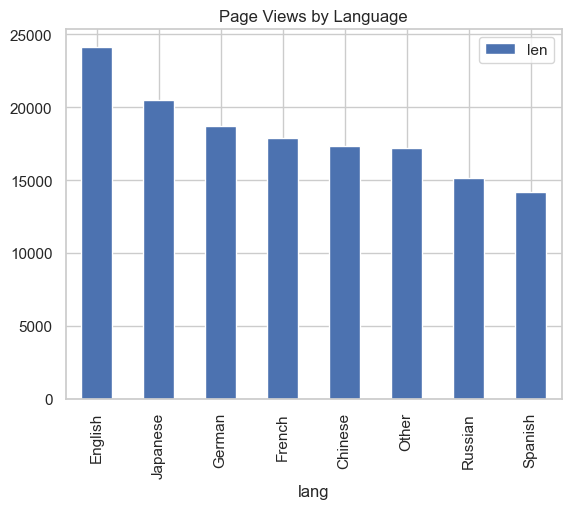

In [151]:
plt.figure(figsize=(10, 8))
cleaned_df.group_by("lang").len().sort("len", descending=True).to_pandas().plot.bar(x="lang", y="len")
plt.title("Page Views by Language");

<b style='padding: 4px 10px 6px 10px;border-radius: 5px;background: #009688;color: #fff;display: inline-block;'>Observations</b>

- From above plot we can that English language has the highest number of views

<Figure size 1000x800 with 0 Axes>

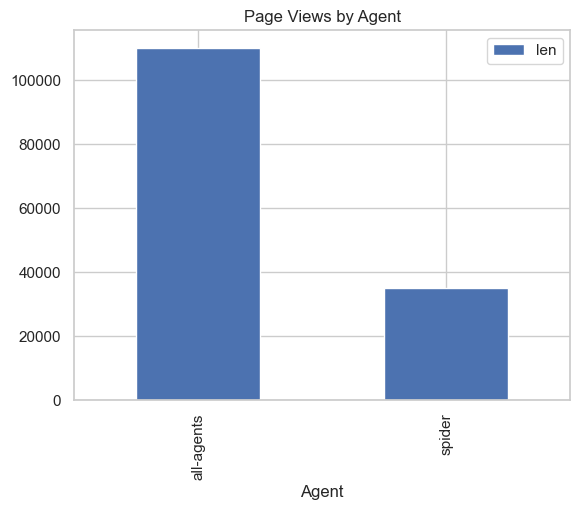

In [134]:
plt.figure(figsize=(10, 8))
cleaned_df.group_by("Agent").len().sort("len", descending=True).to_pandas().plot.bar(x="Agent", y="len")
plt.title("Page Views by Agent");

<b style='padding: 4px 10px 6px 10px;border-radius: 5px;background: #009688;color: #fff;display: inline-block;'>Observations</b>
- From above plot we can see most views are from "all-agents" source

<Figure size 1000x800 with 0 Axes>

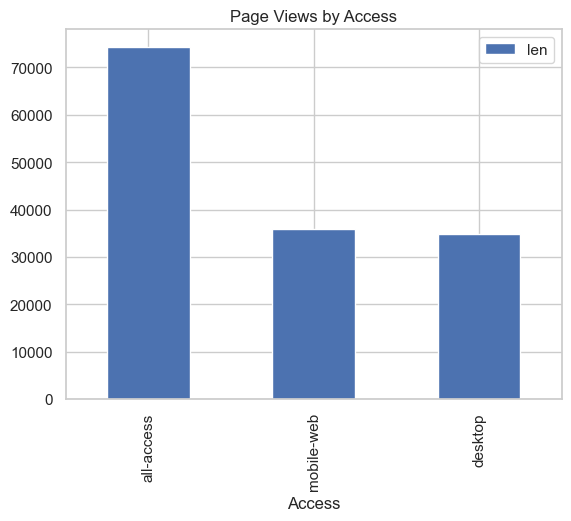

In [135]:
plt.figure(figsize=(10, 8))
cleaned_df.group_by("Access").len().sort("len", descending=True).to_pandas().plot.bar(x="Access", y="len")
plt.title("Page Views by Access");

<b style='padding: 4px 10px 6px 10px;border-radius: 5px;background: #009688;color: #fff;display: inline-block;'>Observations</b>
- From above plot we can see that most views are from "all-access" source

In [172]:
lang_grp = cleaned_df.group_by("lang").sum().drop("Agent", "Access")
lang_grp

shape: (8, 551)
┌──────────┬───────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬───────────┐
│ lang     ┆ 2015-07-0 ┆ 2015-07-0 ┆ 2015-07-0 ┆ … ┆ 2016-12-2 ┆ 2016-12-2 ┆ 2016-12-3 ┆ 2016-12-3 │
│ ---      ┆ 1         ┆ 2         ┆ 3         ┆   ┆ 8         ┆ 9         ┆ 0         ┆ 1         │
│ str      ┆ ---       ┆ ---       ┆ ---       ┆   ┆ ---       ┆ ---       ┆ ---       ┆ ---       │
│          ┆ i32       ┆ i32       ┆ i32       ┆   ┆ i32       ┆ i32       ┆ i32       ┆ i32       │
╞══════════╪═══════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪═══════════╡
│ Other    ┆ 1477069   ┆ 1548788   ┆ 1464346   ┆ … ┆ 3316427   ┆ 2620026   ┆ 2921474   ┆ 2559123   │
│ Spanish  ┆ 15279998  ┆ 14602449  ┆ 13428998  ┆ … ┆ 16578967  ┆ 15648438  ┆ 11562101  ┆ 11079339  │
│ Japanese ┆ 11864936  ┆ 13622479  ┆ 12307000  ┆ … ┆ 16152145  ┆ 17683587  ┆ 19452390  ┆ 24461932  │
│ English  ┆ 84712323  ┆ 84438676  ┆ 80167807  ┆ … ┆ 141278597 ┆ 150557723 ┆ 125404796 ┆ 123624015 │
│ Chinese  ┆ 4147071   ┆ 4152793   ┆ 4125028   ┆ … ┆ 6515403   ┆ 6044182   ┆ 6114003   ┆ 6300124   │
│ German   ┆ 13264635  ┆ 13084303  ┆ 12558048  ┆ … ┆ 19155875  ┆ 18450782  ┆ 17611564  ┆ 16566864  │
│ Russian  ┆ 9466267   ┆ 9630020   ┆ 8925576   ┆ … ┆ 14002376  ┆ 13480581  ┆ 12069020  ┆ 13224530  │
│ French   ┆ 8460177   ┆ 8514332   ┆ 8187395   ┆ … ┆ 13783146  ┆ 13401250  ┆ 12472948  ┆ 11505867  │
└──────────┴───────────┴───────────┴───────────┴───┴───────────┴───────────┴───────────┴───────────┘

In [176]:
df=lang_grp.unpivot(index="lang", variable_name="dates").pivot("lang", index="dates")
df=df.with_columns(
    pl.col("dates").cast(pl.Date),
)

In [177]:
campaign_df = pl.read_csv("../data/processed/Exog_Campaign_eng.csv", has_header=True, ignore_errors=True)
campaign_df

shape: (550, 1)
┌──────┐
│ Exog │
│ ---  │
│ i64  │
╞══════╡
│ 0    │
│ 0    │
│ 0    │
│ 0    │
│ 0    │
│ …    │
│ 1    │
│ 1    │
│ 1    │
│ 0    │
│ 0    │
└──────┘

In [178]:
df=df.hstack(campaign_df)
df.head(10)

shape: (10, 10)
┌────────────┬─────────┬──────────┬──────────┬───┬──────────┬──────────┬─────────┬──────┐
│ dates      ┆ Other   ┆ Spanish  ┆ Japanese ┆ … ┆ German   ┆ Russian  ┆ French  ┆ Exog │
│ ---        ┆ ---     ┆ ---      ┆ ---      ┆   ┆ ---      ┆ ---      ┆ ---     ┆ ---  │
│ date       ┆ i32     ┆ i32      ┆ i32      ┆   ┆ i32      ┆ i32      ┆ i32     ┆ i64  │
╞════════════╪═════════╪══════════╪══════════╪═══╪══════════╪══════════╪═════════╪══════╡
│ 2015-07-01 ┆ 1477069 ┆ 15279998 ┆ 11864936 ┆ … ┆ 13264635 ┆ 9466267  ┆ 8460177 ┆ 0    │
│ 2015-07-02 ┆ 1548788 ┆ 14602449 ┆ 13622479 ┆ … ┆ 13084303 ┆ 9630020  ┆ 8514332 ┆ 0    │
│ 2015-07-03 ┆ 1464346 ┆ 13428998 ┆ 12307000 ┆ … ┆ 12558048 ┆ 8925576  ┆ 8187395 ┆ 0    │
│ 2015-07-04 ┆ 1249447 ┆ 12607803 ┆ 15457627 ┆ … ┆ 11523603 ┆ 8395377  ┆ 8750945 ┆ 0    │
│ 2015-07-05 ┆ 1385036 ┆ 13711974 ┆ 14828618 ┆ … ┆ 13395805 ┆ 8940768  ┆ 8591590 ┆ 0    │
│ 2015-07-06 ┆ 1586847 ┆ 15627539 ┆ 12922630 ┆ … ┆ 14746420 ┆ 9631695  ┆ 8951425 ┆ 0    │
│ 2015-07-07 ┆ 1679560 ┆ 15232641 ┆ 12570816 ┆ … ┆ 14301345 ┆ 9411165  ┆ 8652420 ┆ 0    │
│ 2015-07-08 ┆ 1755740 ┆ 14783419 ┆ 12494311 ┆ … ┆ 14509892 ┆ 9366525  ┆ 8493256 ┆ 0    │
│ 2015-07-09 ┆ 1530950 ┆ 14504467 ┆ 12179762 ┆ … ┆ 13968844 ┆ 9594537  ┆ 8405132 ┆ 0    │
│ 2015-07-10 ┆ 1547281 ┆ 13185904 ┆ 12654331 ┆ … ┆ 13018538 ┆ 10987503 ┆ 7932023 ┆ 0    │
└────────────┴─────────┴──────────┴──────────┴───┴──────────┴──────────┴─────────┴──────┘

In [179]:
df.write_parquet("../data/processed/df.parquet")

# Time Series Analysis

In [84]:
df=pl.read_parquet("../data/processed/df.parquet").to_pandas()

In [85]:
df=df.set_index("dates")
df=df.drop("Other", axis=1)
df

Spanish  Japanese    English  ...   Russian    French  Exog
dates                                      ...                          
2015-07-01  15279998  11864936   84712323  ...   9466267   8460177     0
2015-07-02  14602449  13622479   84438676  ...   9630020   8514332     0
2015-07-03  13428998  12307000   80167807  ...   8925576   8187395     0
2015-07-04  12607803  15457627   83463351  ...   8395377   8750945     0
2015-07-05  13711974  14828618   86198774  ...   8940768   8591590     0
...              ...       ...        ...  ...       ...       ...   ...
2016-12-27  15946677  16124459  145628953  ...  15041813  15282895     1
2016-12-28  16578967  16152145  141278597  ...  14002376  13783146     1
2016-12-29  15648438  17683587  150557723  ...  13480581  13401250     1
2016-12-30  11562101  19452390  125404796  ...  12069020  12472948     0
2016-12-31  11079339  24461932  123624015  ...  13224530  11505867     0

[550 rows x 8 columns]

In [36]:
columns = ['Spanish', 'Japanese', 'English', 'Chinese', 'German', 'Russian', 'French']

In [37]:
columns

['Spanish', 'Japanese', 'English', 'Chinese', 'German', 'Russian', 'French']

**Combined Time Series Plot**

In [86]:
df["Exog_scaled"] = df["Exog"]*df["English"]
filtered_df = df[df["Exog_scaled"] > 0]
df=df.drop("Exog_scaled", axis=1)

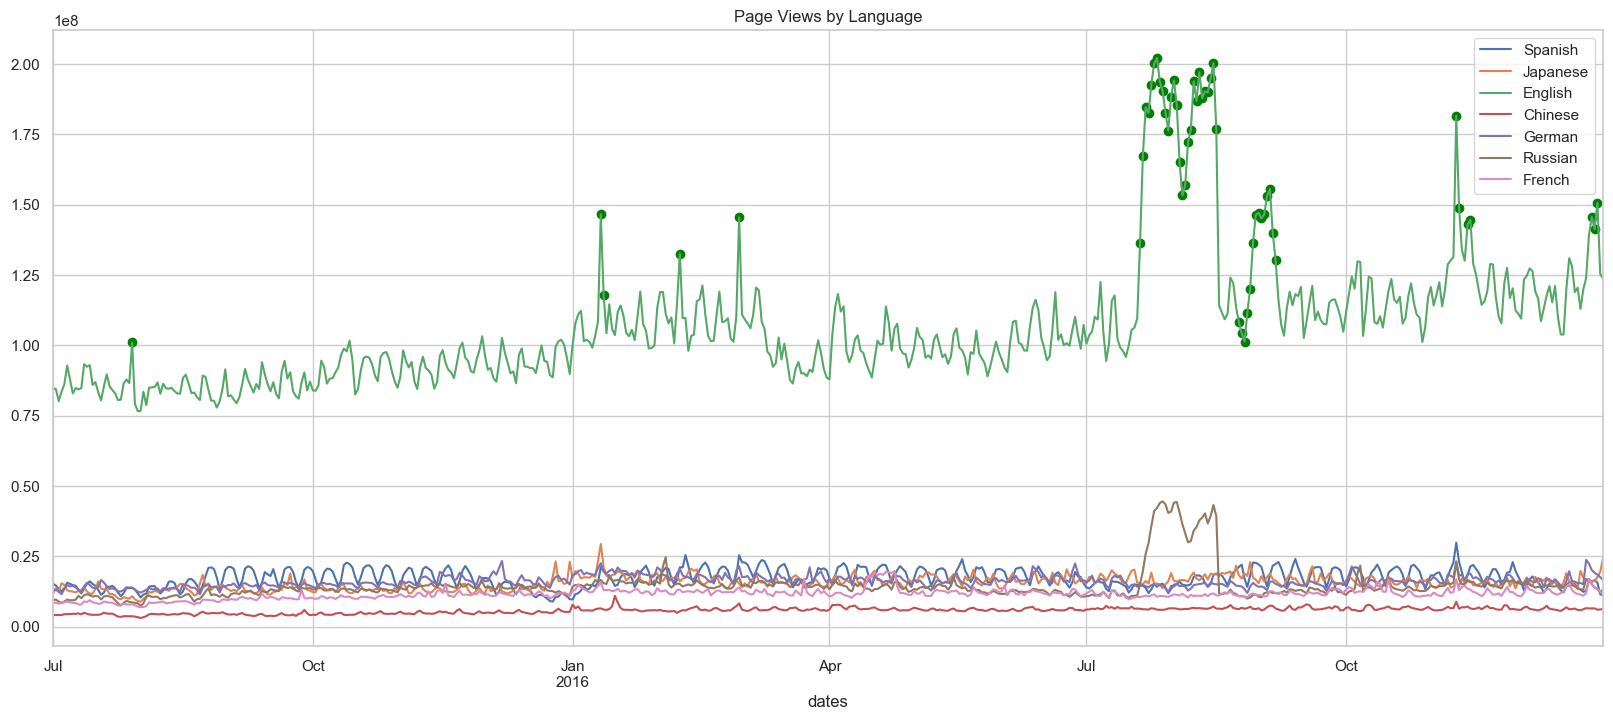

In [87]:
df.drop(["Exog"], axis=1).plot(figsize=(20, 8));
plt.scatter(filtered_df.index, filtered_df["Exog_scaled"], color="green", label="Exog_scaled")
plt.title("Page Views by Language");

<b style='padding: 4px 10px 6px 10px;border-radius: 5px;background: #009688;color: #fff;display: inline-block;'>Observations</b>

- We can see that English language has highest number of page views.
- We can also see a surge in views in the month of August for English and Russian languages.
- This can be due to the campaigns run

**Individual Time Series Plot**

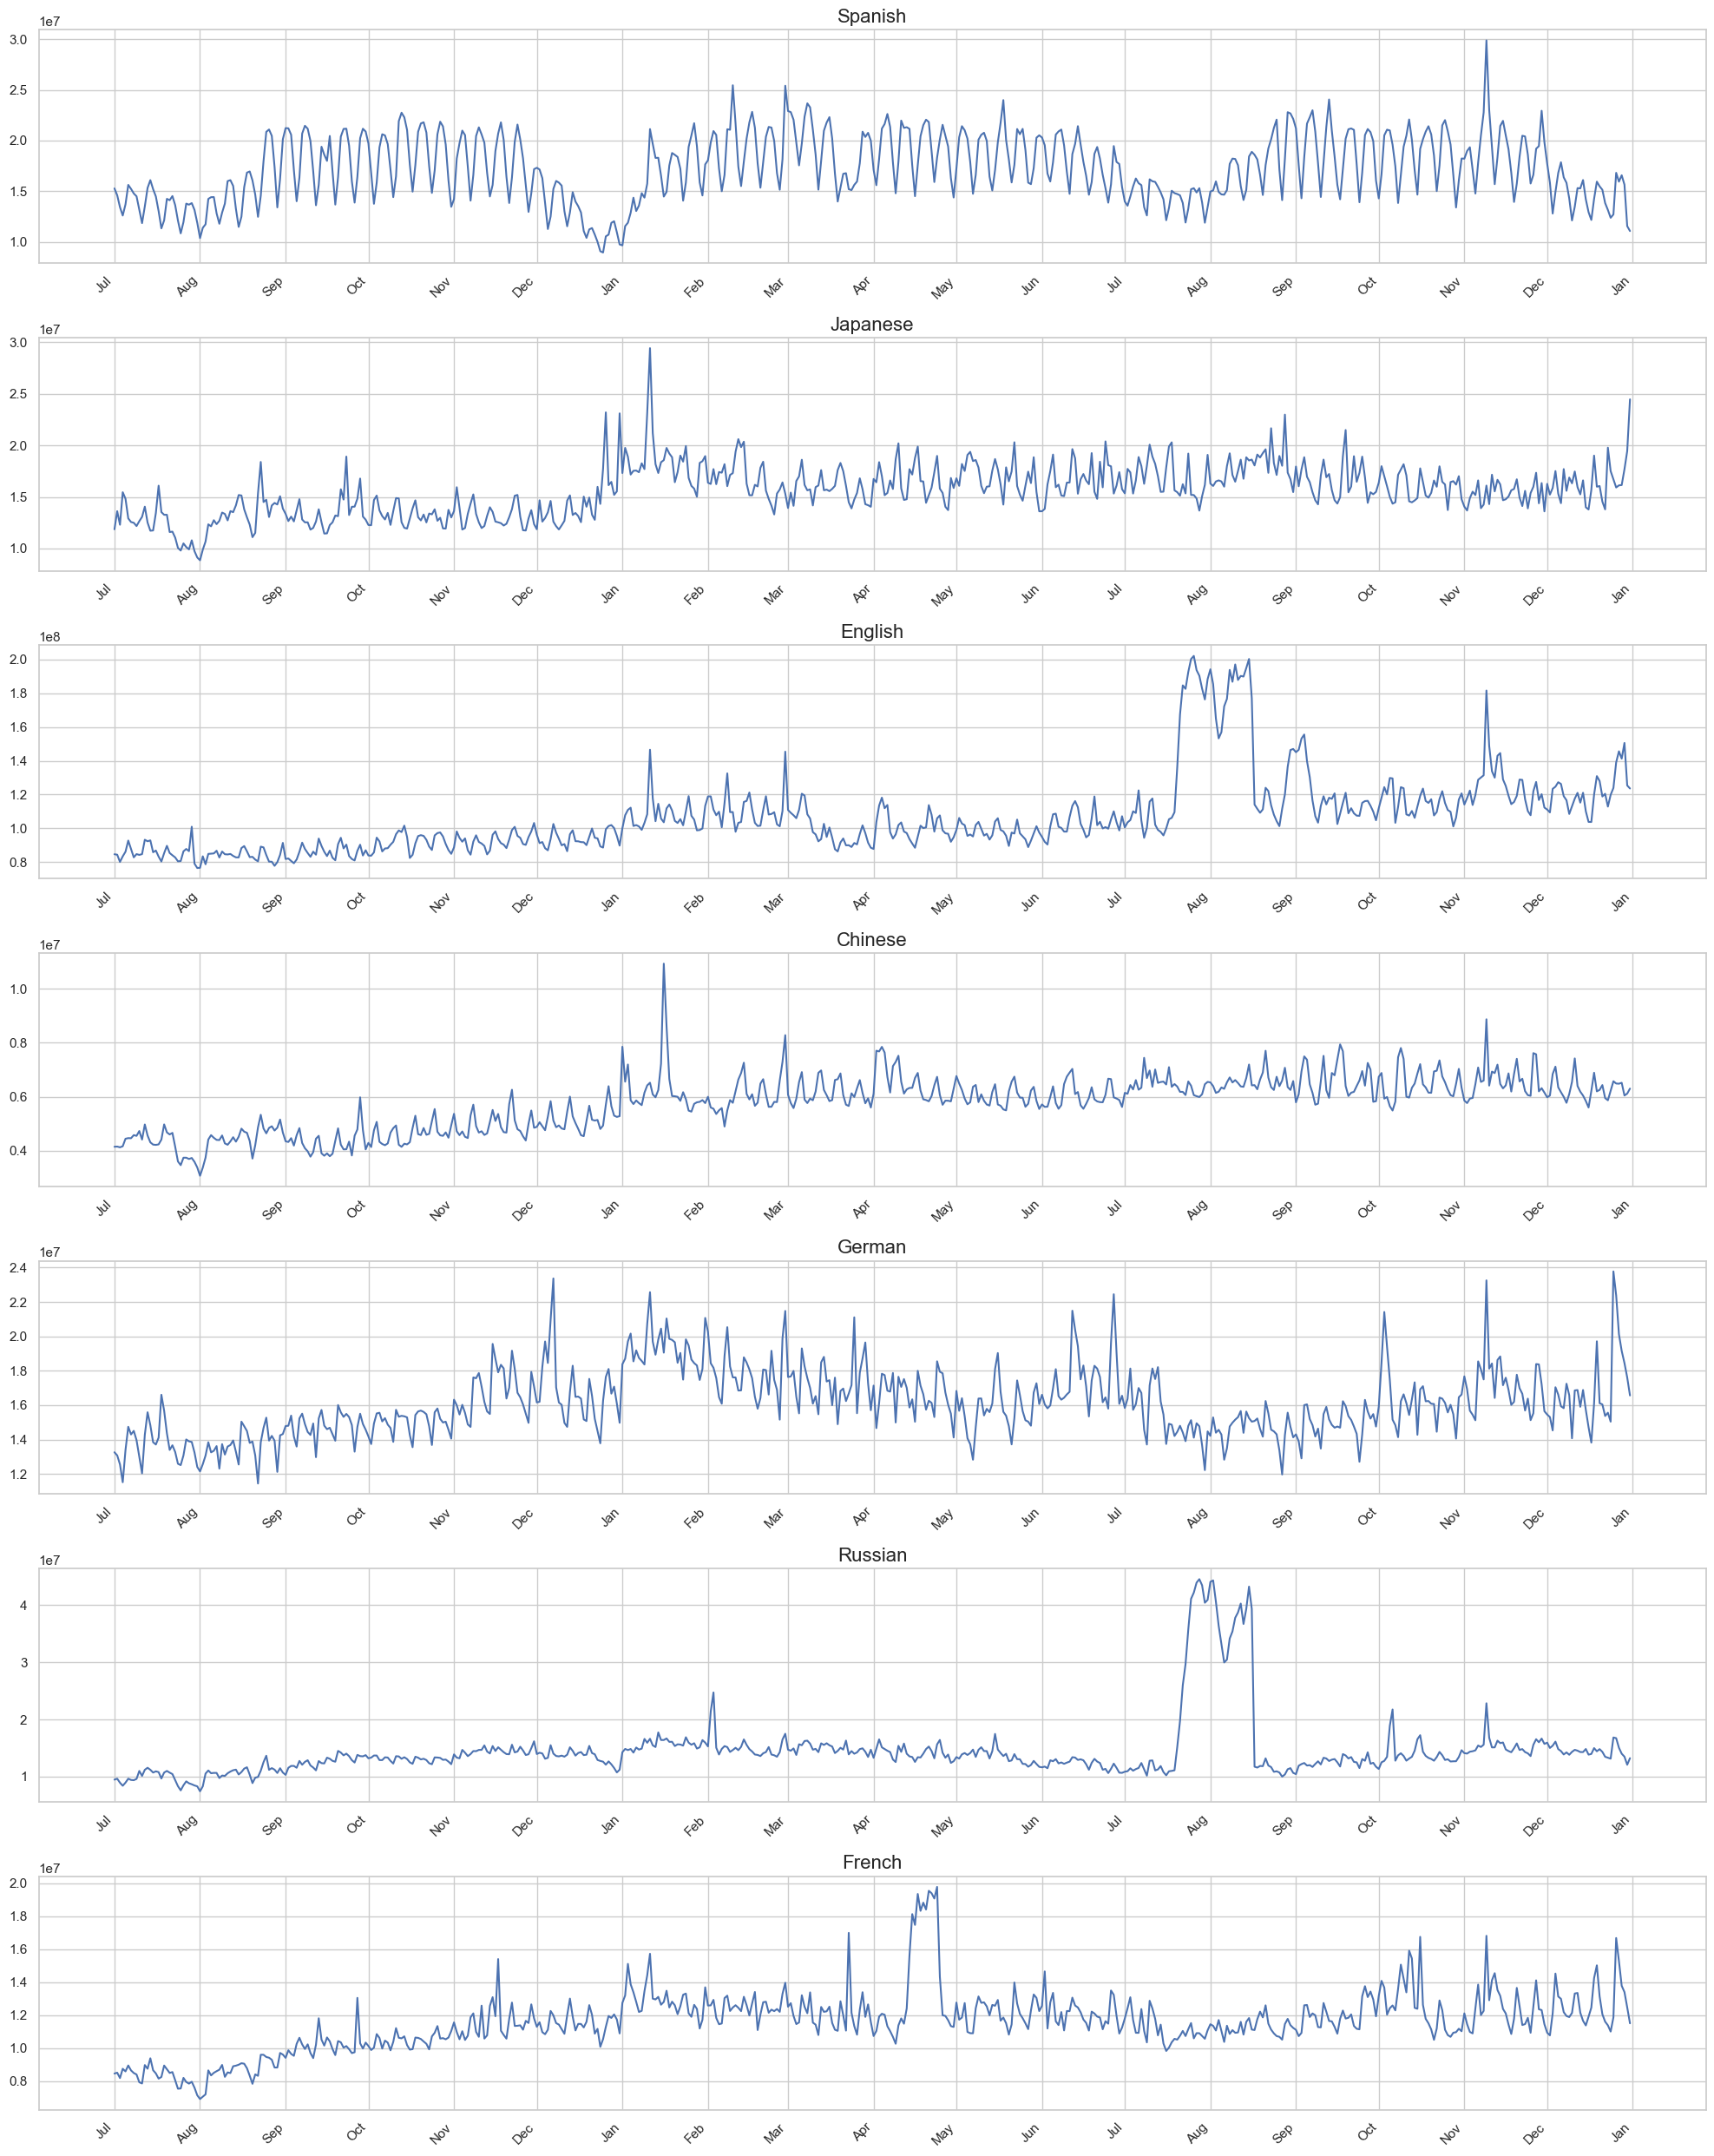

In [41]:
import matplotlib.dates as mdates

fig, ax = plt.subplots(len(columns), 1, figsize=(20, 25))

for i, col in enumerate(columns):
    ax[i].plot(df[col])
    ax[i].set_title(col, fontsize=16)
    ax[i].xaxis.set_major_locator(mdates.MonthLocator())
    ax[i].xaxis.set_major_formatter(mdates.DateFormatter('%b'))
    plt.setp(ax[i].xaxis.get_majorticklabels(), rotation=45, ha='right')

plt.tight_layout()
plt.show()

**Distribution of views count**

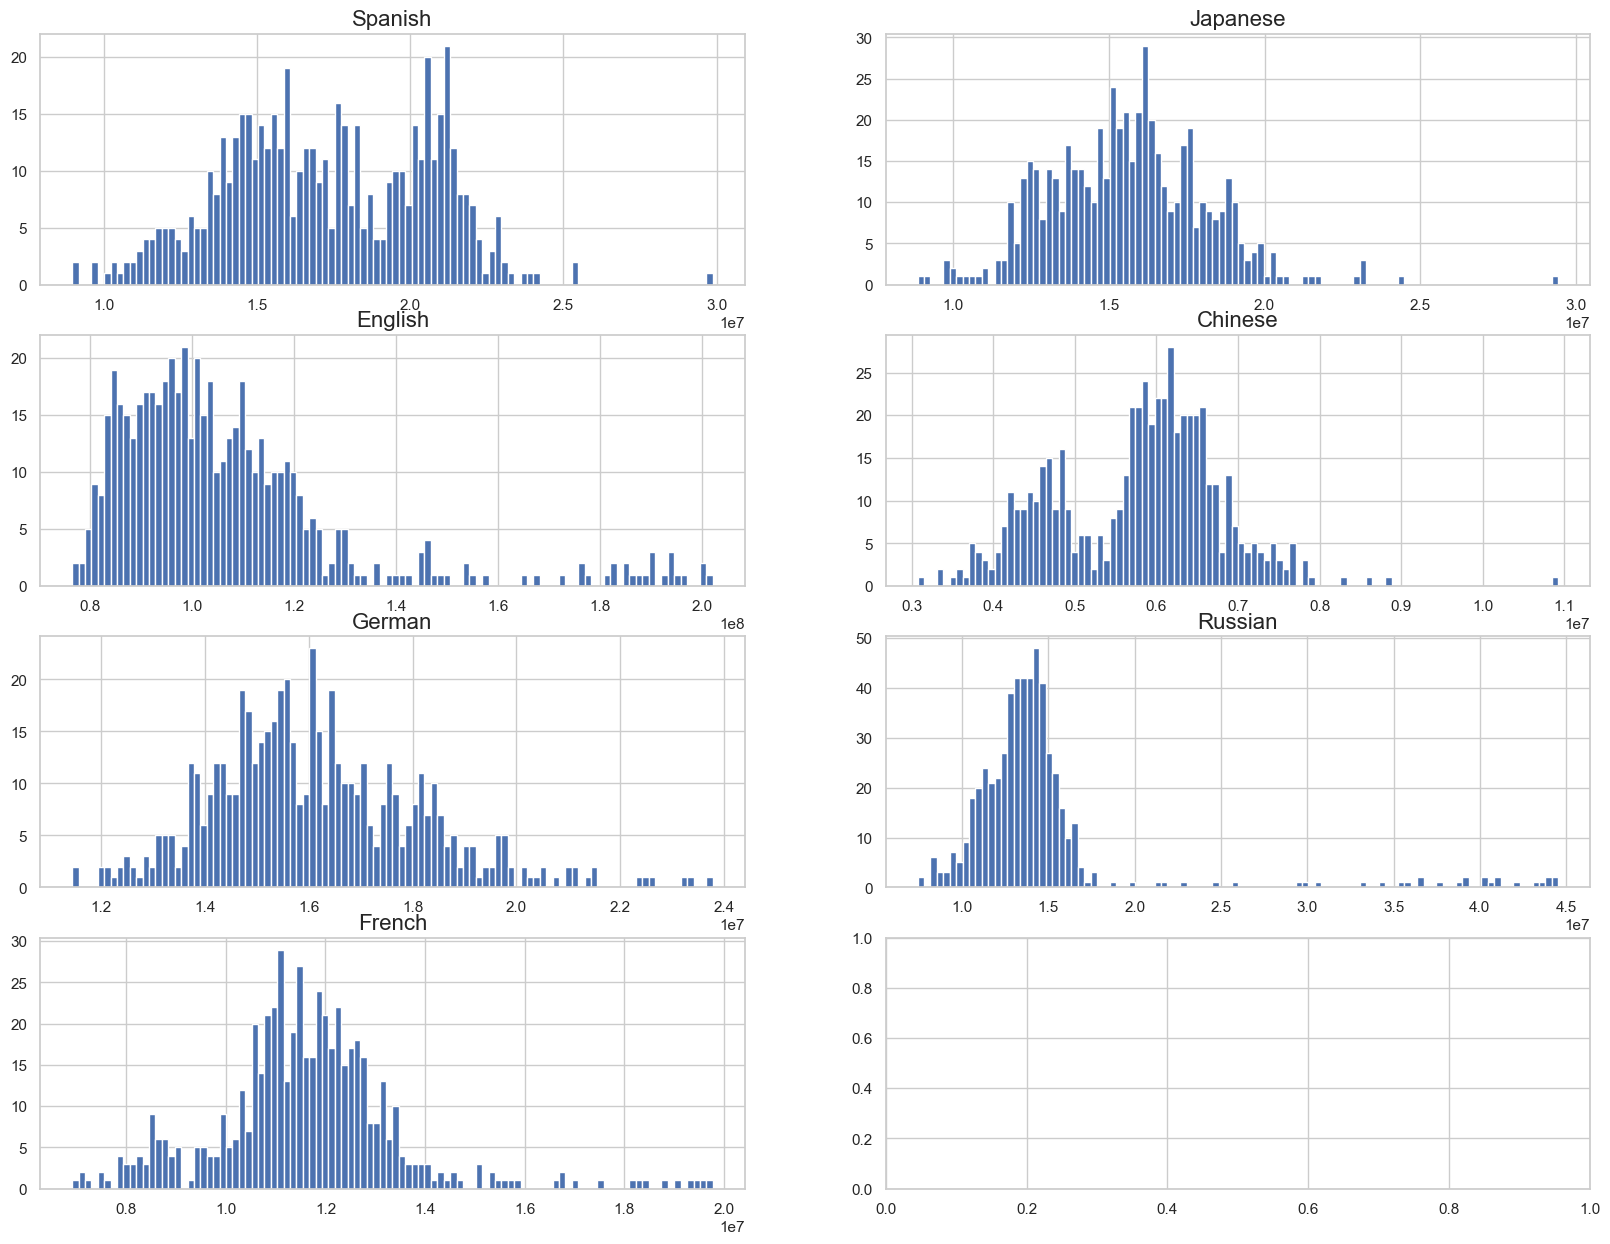

In [42]:
fig, ax = plt.subplots(4, 2, figsize=(20, 15))

for i, col in enumerate(columns):
    df[col].hist(ax=ax[i//2, i%2], bins=100)
    ax[i//2, i%2].set_title(col, fontsize=16)
# plt.tight_layout()


<b style='padding: 4px 10px 6px 10px;border-radius: 5px;background: #009688;color: #fff;display: inline-block;'>Observations</b>

- From above plot we can see that Russian has large number of outliers

# Stationarity Check



**AD Fuller Test**

In [46]:
def is_stationary(series, significance_level=0.05):
    adf_test = adfuller(series)
    p_value = adf_test[1]
    return p_value < significance_level , p_value

In [48]:
adf_df = pd.DataFrame(columns=["Lang", "p-value", "is_stationary"])

for column in columns:
    result, p_value = is_stationary(df[column])
    adf_df = pd.concat([adf_df, pd.DataFrame({"Lang": [column], "p-value": p_value, "is_stationary": result})], ignore_index=True)

adf_df.sort_values("p-value", ascending=False)

C:\Users\v-gautamnaik\AppData\Local\Temp\ipykernel_7352\3790388776.py:5: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  adf_df = pd.concat([adf_df, pd.DataFrame({"Lang": [column], "p-value": p_value, "is_stationary": result})], ignore_index=True)


Lang   p-value is_stationary
3   Chinese  0.447261         False
2   English  0.189574         False
4    German  0.139171         False
1  Japanese  0.102580         False
6    French  0.051539         False
0   Spanish  0.033589          True
5   Russian  0.001864          True

<b style='padding: 4px 10px 6px 10px;border-radius: 5px;background: #009688;color: #fff;display: inline-block;'>Observations</b>

- Above table shows which language time series is stationary and which is not. 
- Only Russian and Spanish language time series are stationary

## Decomposition

**English**

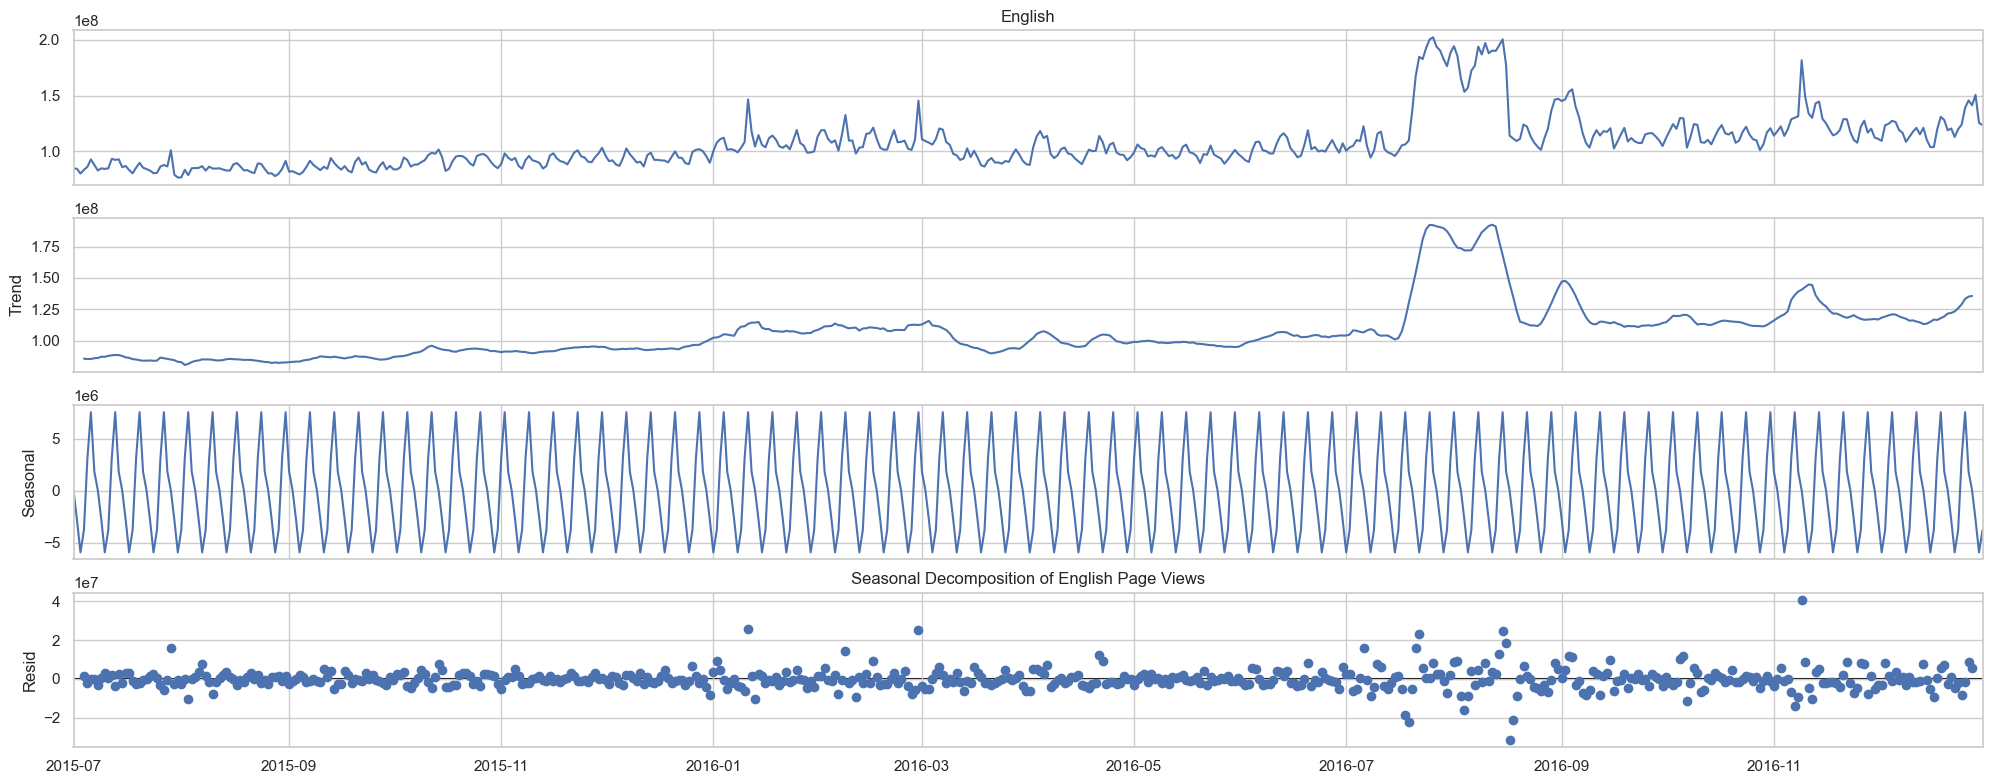

In [48]:
plt.rcParams['figure.figsize'] = (20, 8)
seasonal_decompose(df["English"], model="additive").plot();

<b style='padding: 4px 10px 6px 10px;border-radius: 5px;background: #009688;color: #fff;display: inline-block;'>Observations</b>

- **Trend**: We can see that there is upward trend in the page views count
- **Seasonality**: Based on the seasonal plot we can see that there is presennce of seasonality
- **Residuals**: The residuals are spread around 0 suggesting no underlying trend

**Spanish**

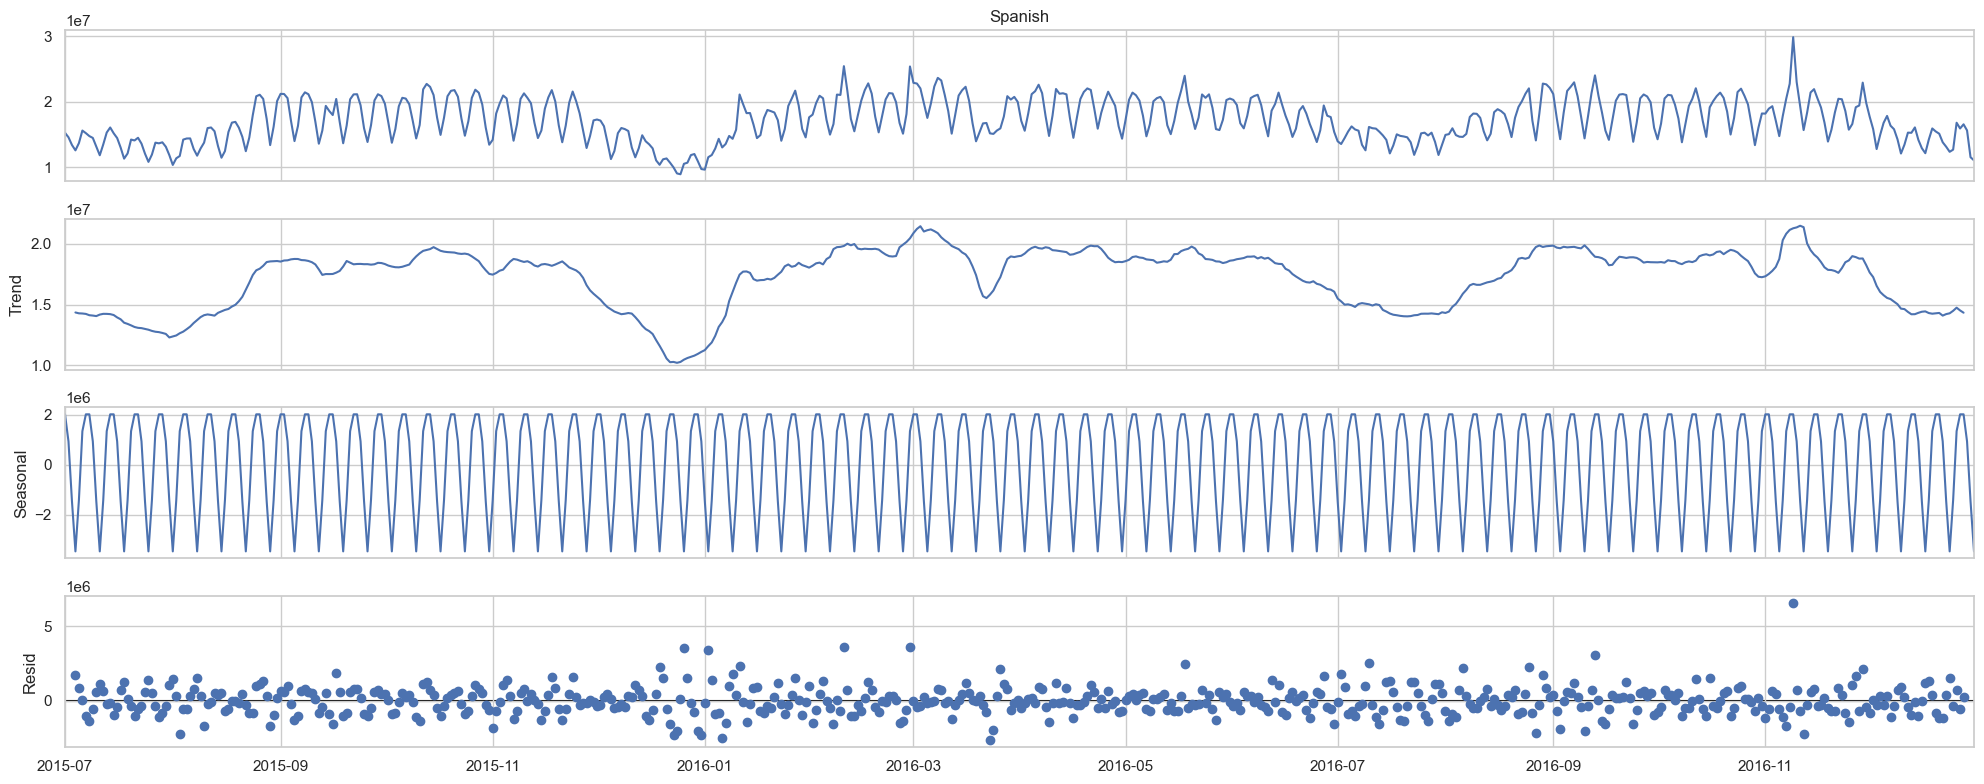

In [50]:
seasonal_decompose(df["Spanish"], model="additive").plot();

<b style='padding: 4px 10px 6px 10px;border-radius: 5px;background: #009688;color: #fff;display: inline-block;'>Observations</b>

- **Trend**: We can see that there is no trend in the page views count
- **Seasonality**: Based on the seasonal plot we can see that there is presennce of seasonality
- **Residuals**: The residuals are spread around 0 suggesting no underlying trend

**Russian**

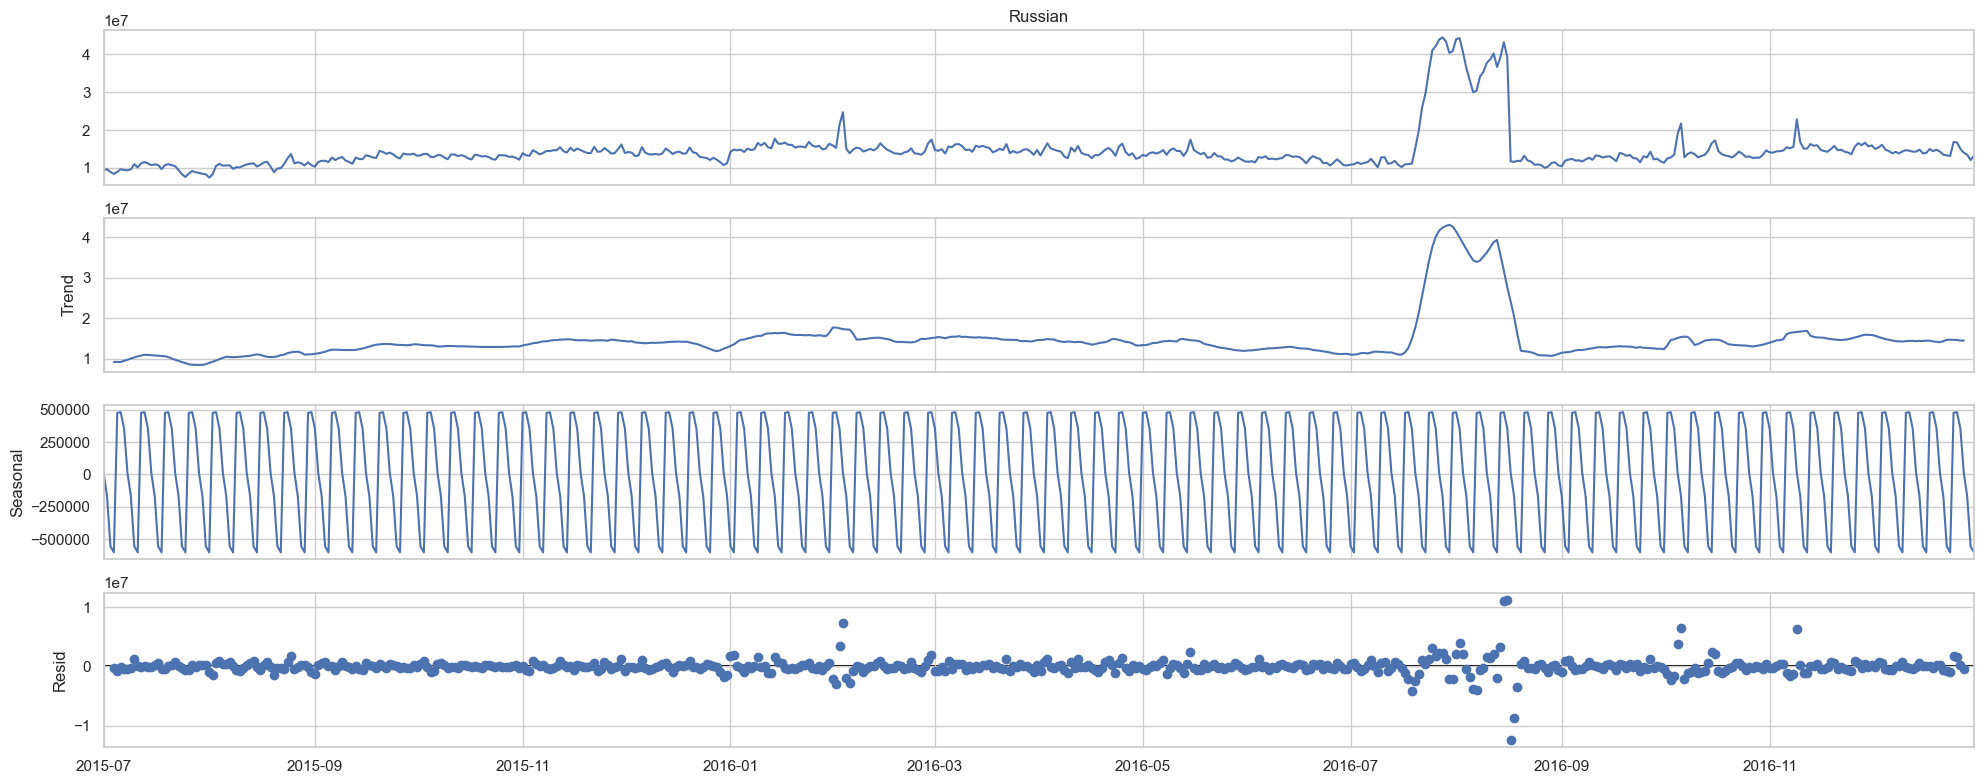

In [52]:
seasonal_decompose(df["Russian"], model="additive").plot();

<b style='padding: 4px 10px 6px 10px;border-radius: 5px;background: #009688;color: #fff;display: inline-block;'>Observations</b>

- **Trend**: We can see that there is small trend in the page views count
- **Seasonality**: Based on the seasonal plot we can see that there is presennce of seasonality
- **Residuals**: The residuals are tightly spread around 0 suggesting no underlying trend

**Japanese**

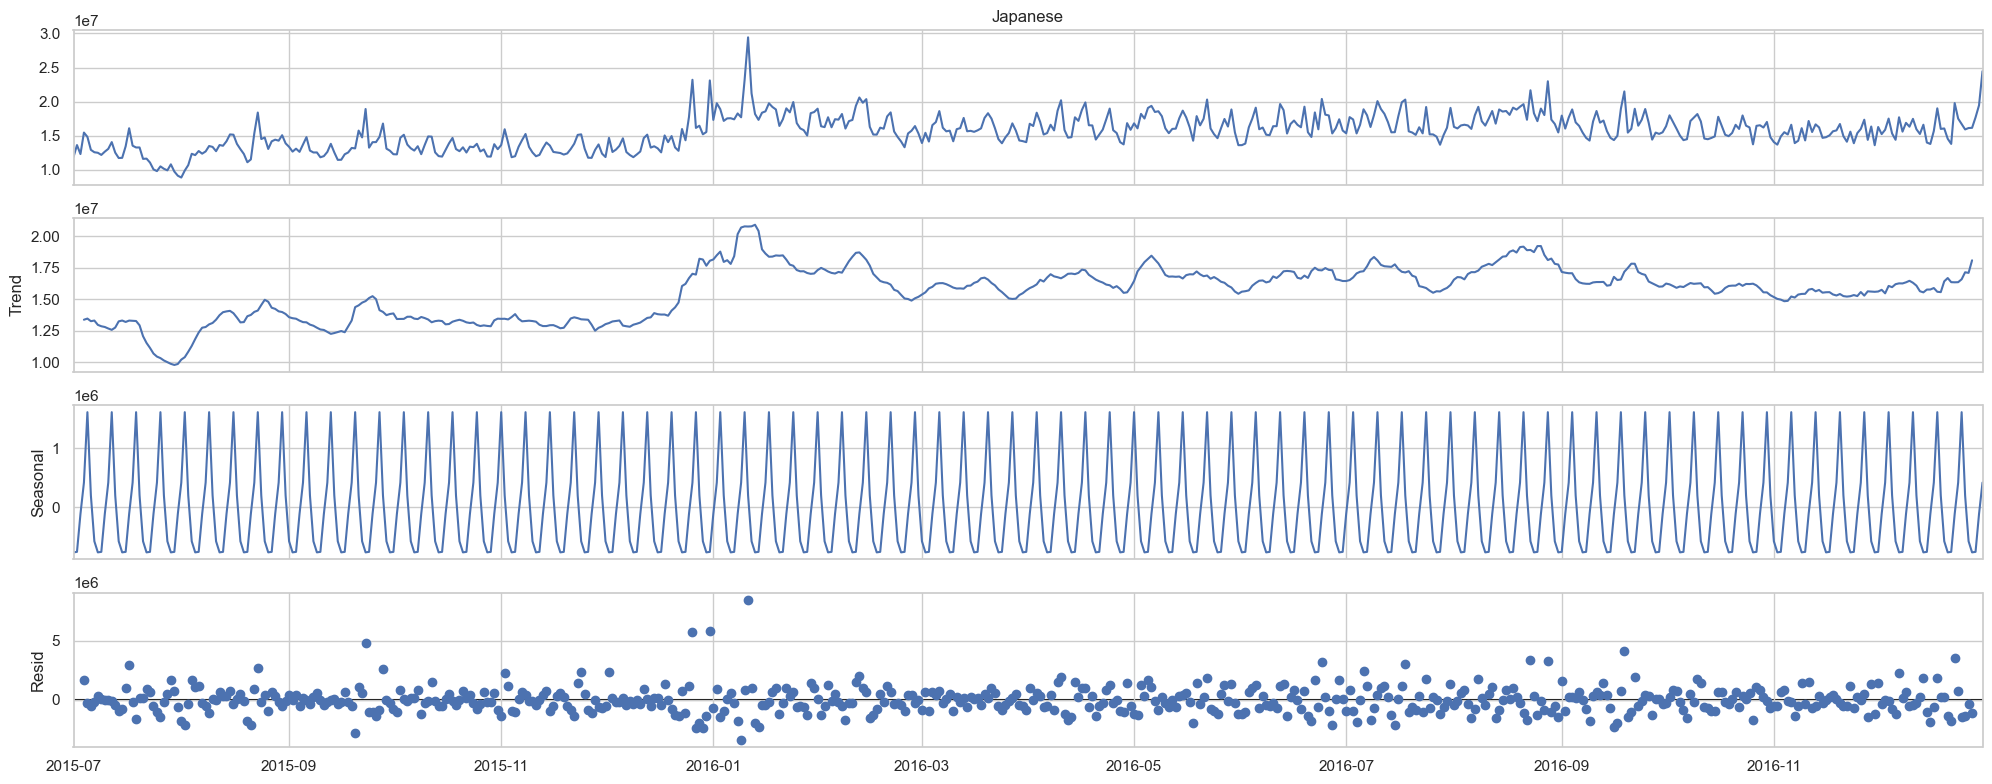

In [54]:
seasonal_decompose(df["Japanese"], model="additive").plot();

<b style='padding: 4px 10px 6px 10px;border-radius: 5px;background: #009688;color: #fff;display: inline-block;'>Observations</b>

- **Trend**: We can see that there was a jump in view but then it is constant
- **Seasonality**: Based on the seasonal plot we can see that there is presennce of seasonality
- **Residuals**: The residuals are evenly spread around 0 suggesting no underlying trend

**French**

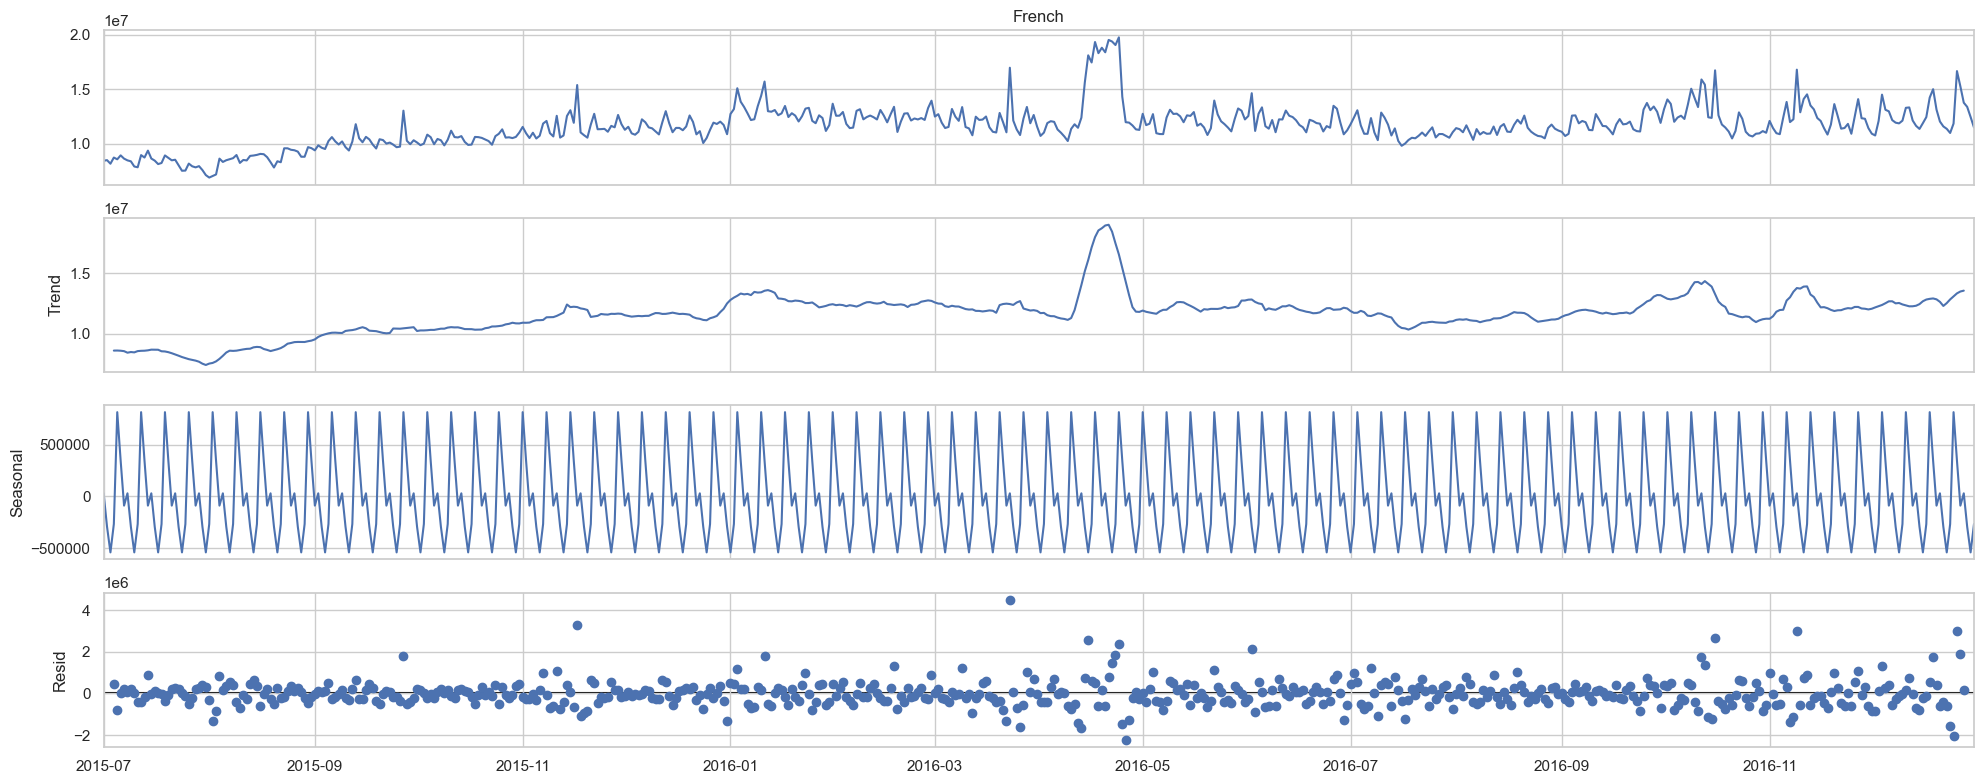

In [56]:
seasonal_decompose(df["French"], model="additive").plot();

<b style='padding: 4px 10px 6px 10px;border-radius: 5px;background: #009688;color: #fff;display: inline-block;'>Observations</b>

- **Trend**: We can see that there is small trend in the page views count
- **Seasonality**: Based on the seasonal plot we can see that there is presennce of seasonality
- **Residuals**: The residuals are evenly spread around 0 suggesting no underlying trend

**German**

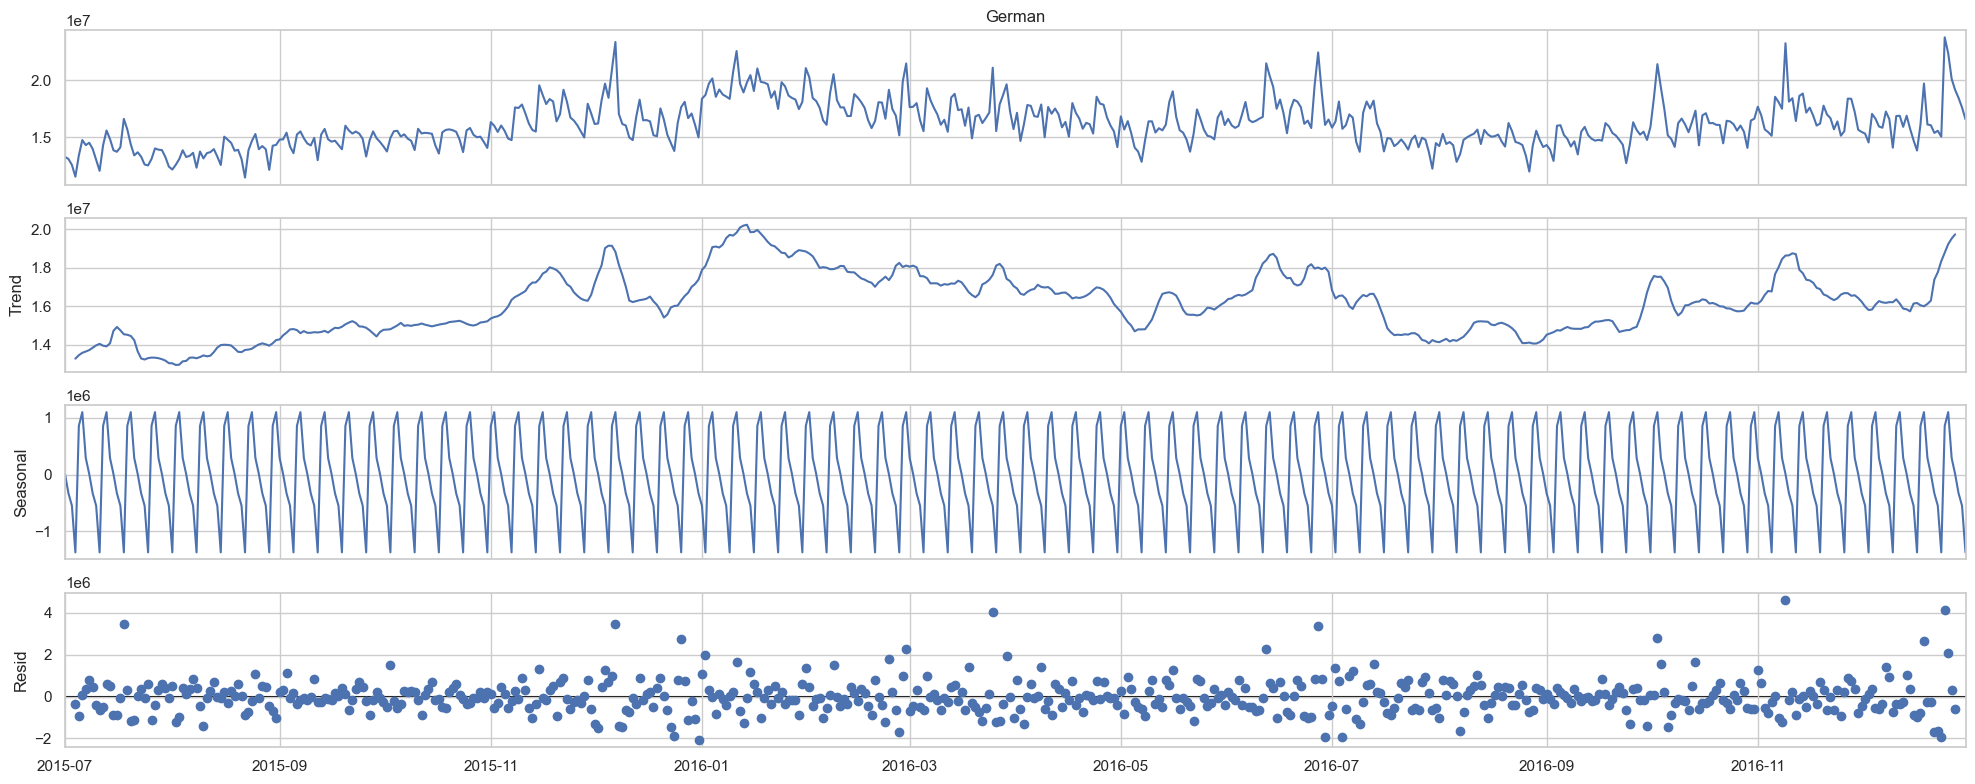

In [57]:
seasonal_decompose(df["German"], model="additive").plot();

<b style='padding: 4px 10px 6px 10px;border-radius: 5px;background: #009688;color: #fff;display: inline-block;'>Observations</b>

- **Trend**: We can see that there are ups and downs in the page views count but no clear trend
- **Seasonality**: Based on the seasonal plot we can see that there is presennce of seasonality
- **Residuals**: The residuals are evenly spread around 0 suggesting no underlying trend

**Chinese**

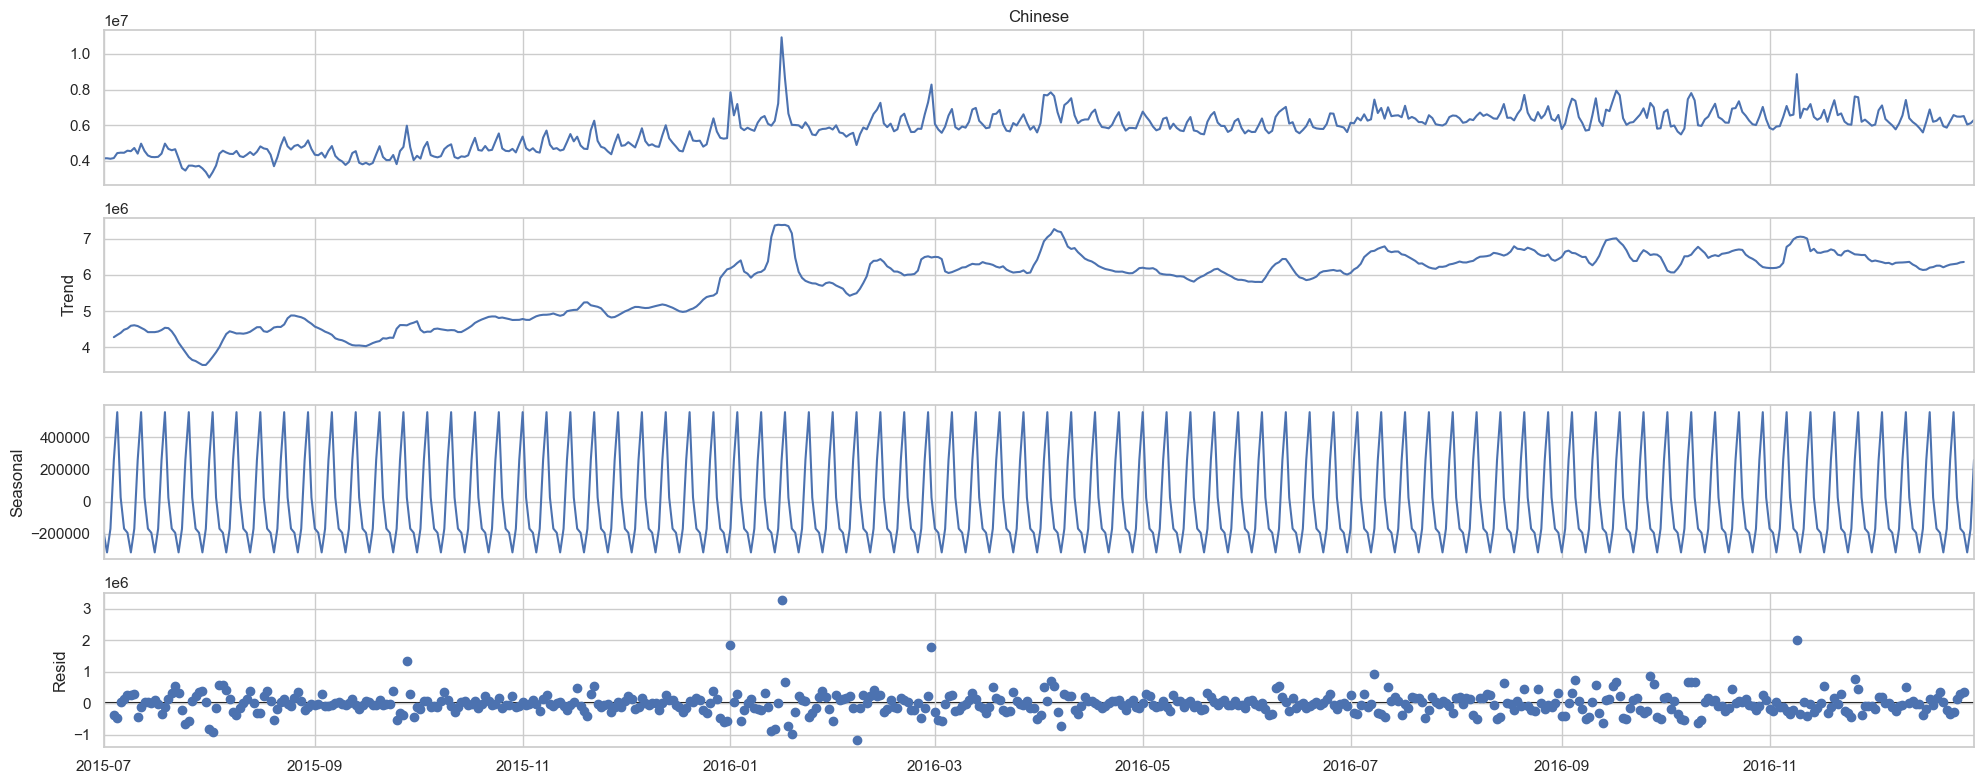

In [58]:
seasonal_decompose(df["Chinese"], model="additive").plot();

<b style='padding: 4px 10px 6px 10px;border-radius: 5px;background: #009688;color: #fff;display: inline-block;'>Observations</b>

- **Trend**: We can see that there was a jump in view but then it is constant
- **Seasonality**: Based on the seasonal plot we can see that there is presennce of seasonality
- **Residuals**: The residuals are evenly spread around 0 suggesting no underlying trend

# Removing Stationarity

In [88]:
df_st = df.copy()

In [89]:
df_st[columns] = df_st[columns].diff()

In [90]:
df_st=df_st.dropna()
df_st

Spanish   Japanese     English  ...    Russian     French  Exog
dates                                         ...                            
2015-07-02  -677549.0  1757543.0   -273647.0  ...   163753.0    54155.0     0
2015-07-03 -1173451.0 -1315479.0  -4270869.0  ...  -704444.0  -326937.0     0
2015-07-04  -821195.0  3150627.0   3295544.0  ...  -530199.0   563550.0     0
2015-07-05  1104171.0  -629009.0   2735423.0  ...   545391.0  -159355.0     0
2015-07-06  1915565.0 -1905988.0   6610795.0  ...   690927.0   359835.0     0
...               ...        ...         ...  ...        ...        ...   ...
2016-12-27  -873730.0   205396.0   6516584.0  ... -1676938.0 -1396984.0     1
2016-12-28   632290.0    27686.0  -4350356.0  ... -1039437.0 -1499749.0     1
2016-12-29  -930529.0  1531442.0   9279126.0  ...  -521795.0  -381896.0     1
2016-12-30 -4086337.0  1768803.0 -25152927.0  ... -1411561.0  -928302.0     0
2016-12-31  -482762.0  5009542.0  -1780781.0  ...  1155510.0  -967081.0     0

[549 rows x 8 columns]

In [76]:
adf_df = pd.DataFrame(columns=["Lang", "p-value", "is_stationary"])

for column in columns:
    result, p_value = is_stationary(df_st[column])
    adf_df = pd.concat([adf_df, pd.DataFrame({"Lang": [column], "p-value": p_value, "is_stationary": result})], ignore_index=True)

adf_df.sort_values("p-value", ascending=False)

C:\Users\v-gautamnaik\AppData\Local\Temp\ipykernel_7352\1076179733.py:5: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  adf_df = pd.concat([adf_df, pd.DataFrame({"Lang": [column], "p-value": p_value, "is_stationary": result})], ignore_index=True)


Lang       p-value is_stationary
0   Spanish  1.499282e-07          True
4    German  2.488111e-10          True
3   Chinese  1.175377e-11          True
2   English  5.285073e-13          True
6    French  1.056177e-17          True
1  Japanese  6.206743e-20          True
5   Russian  2.485269e-30          True

<b style='padding: 4px 10px 6px 10px;border-radius: 5px;background: #009688;color: #fff;display: inline-block;'>Observations</b>
- After applying differencing we can see that all the languages are stationary

# ACF and PACF

In [25]:
params={}
# params["Spanish"] = {
#     "order": (1, 1, 1), p: AR -> PACF , d: Difference, q: MA -> ACF
#     "seasonal_order": (1, 1, 1, 12), P: Seasonal AR, D: Seasonal Difference, Q: Seasonal MA, m: Seasonal Period
# }

In [4]:
df_st=pd.read_parquet("../data/processed/df_st.parquet")

**English**

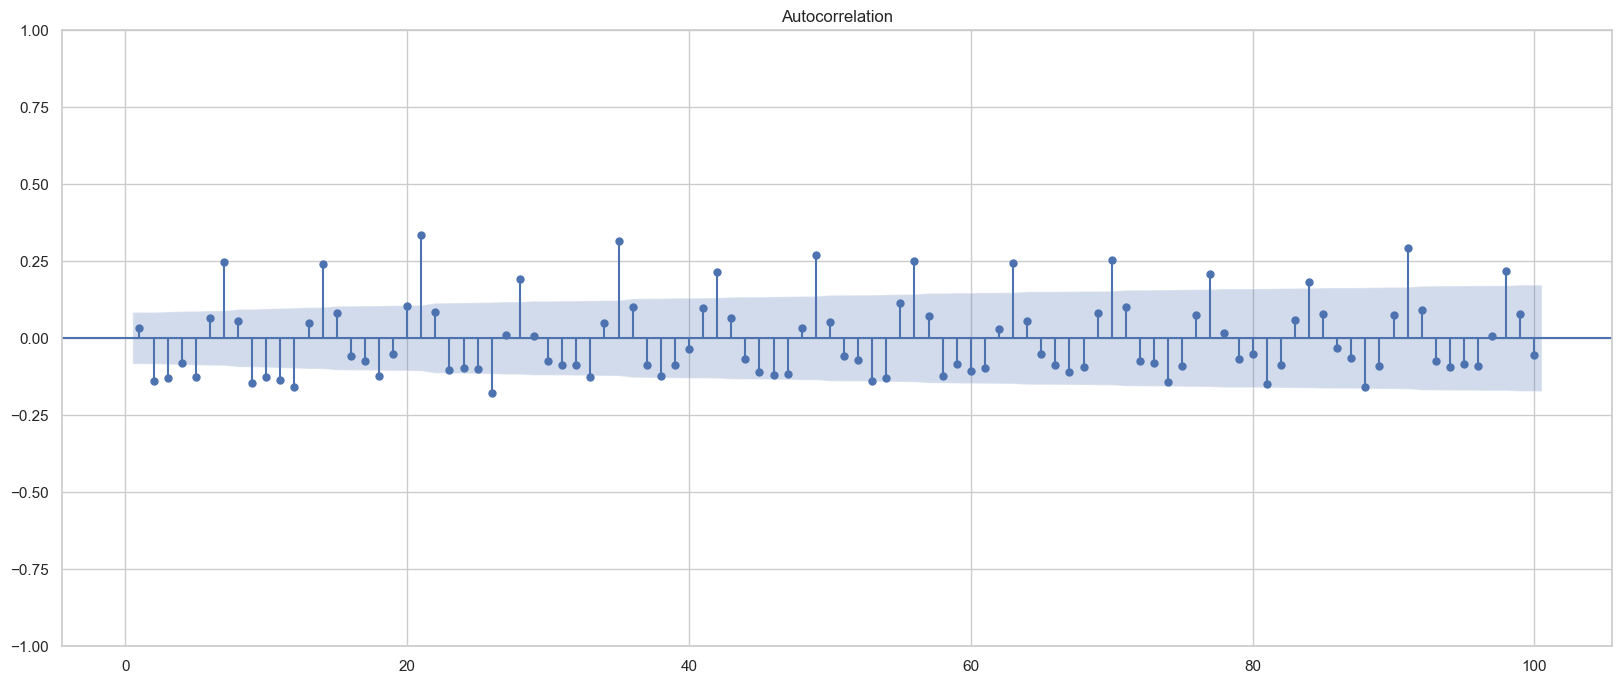

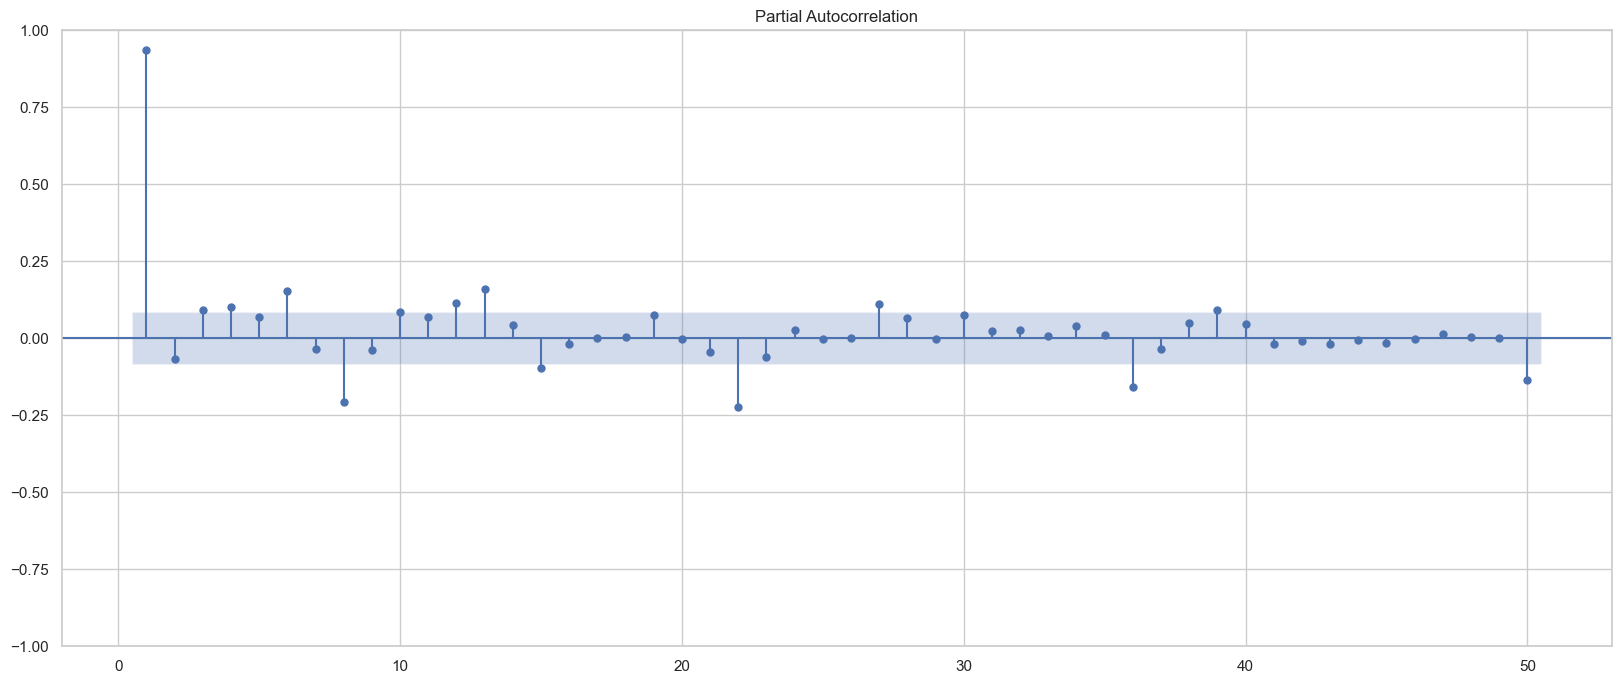

In [77]:
plt.rcParams['figure.figsize'] = (20, 8)
plot_acf(df_st["English"], lags=100, zero=False);
plot_pacf(df["English"], lags=50, zero=False);

In [26]:
params["English"] = {
     "order": (1, 1, 5), 
     "seasonal_order": (1, 0, 1, 7) 
    }

<b style='padding: 4px 10px 6px 10px;border-radius: 5px;background: #009688;color: #fff;display: inline-block;'>Observations</b>



**Spanish**

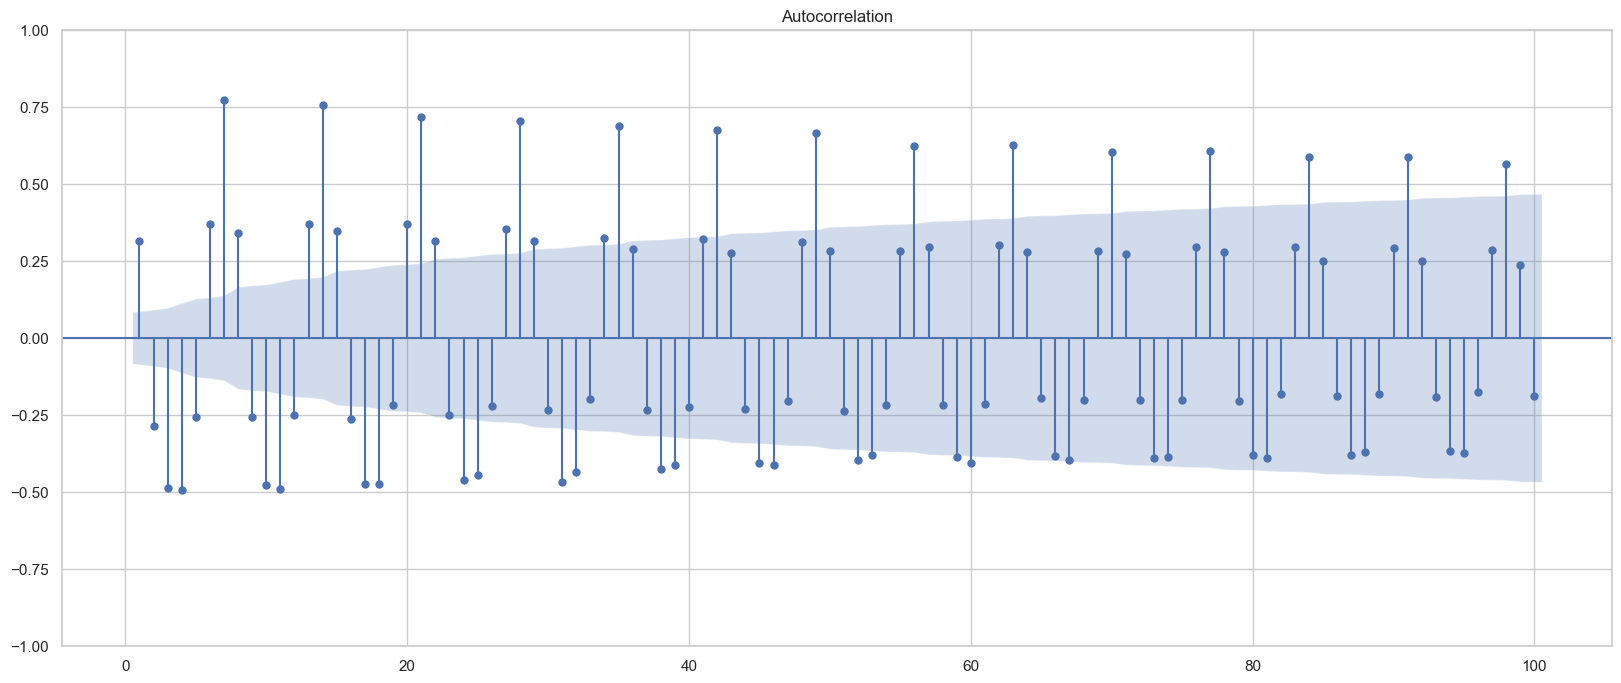

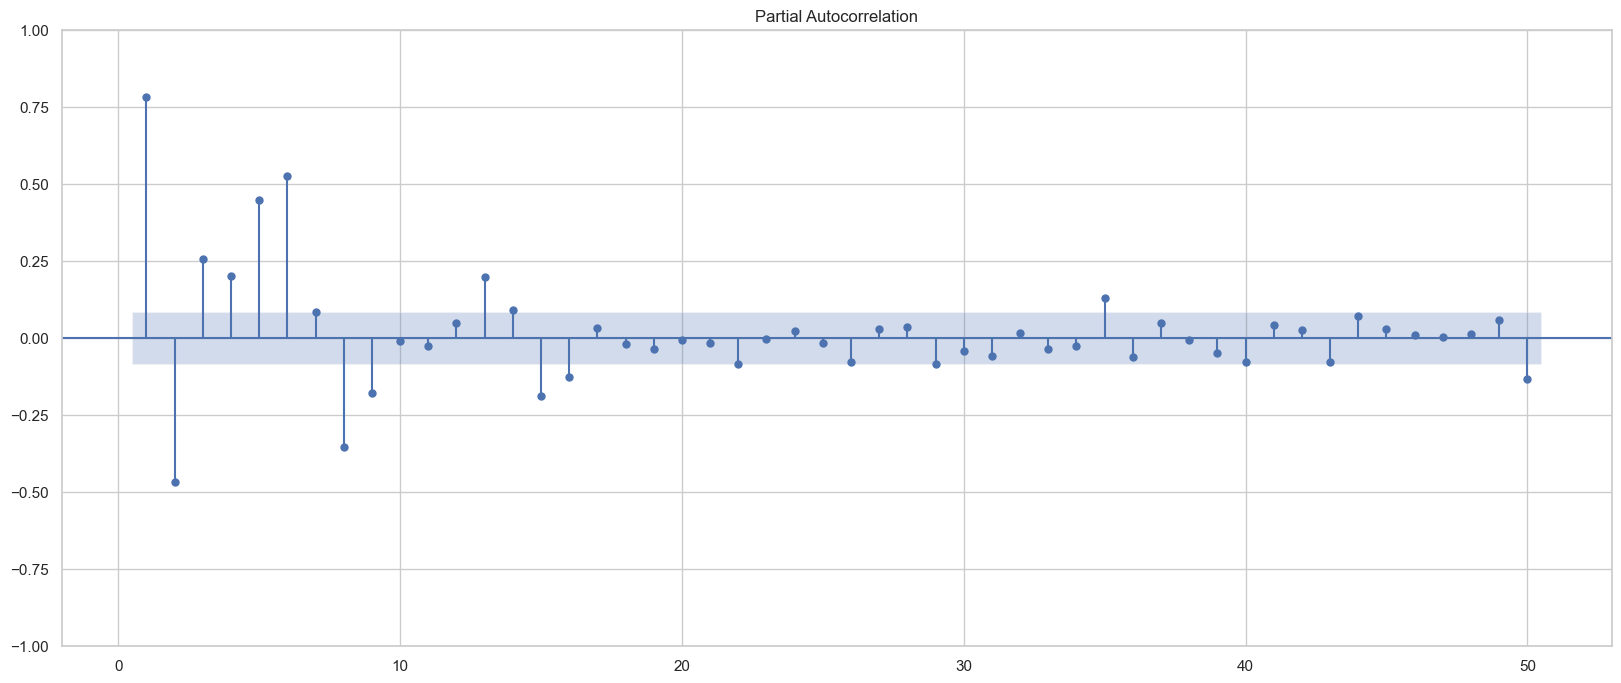

In [78]:
plot_acf(df_st["Spanish"], lags=100, zero=False);
plot_pacf(df["Spanish"], lags=50, zero=False);

In [92]:
params["Spanish"] = {
    "order": (6, 0, 6),
    "seasonal_order": (2, 0, 14, 7),
}

**Russian**

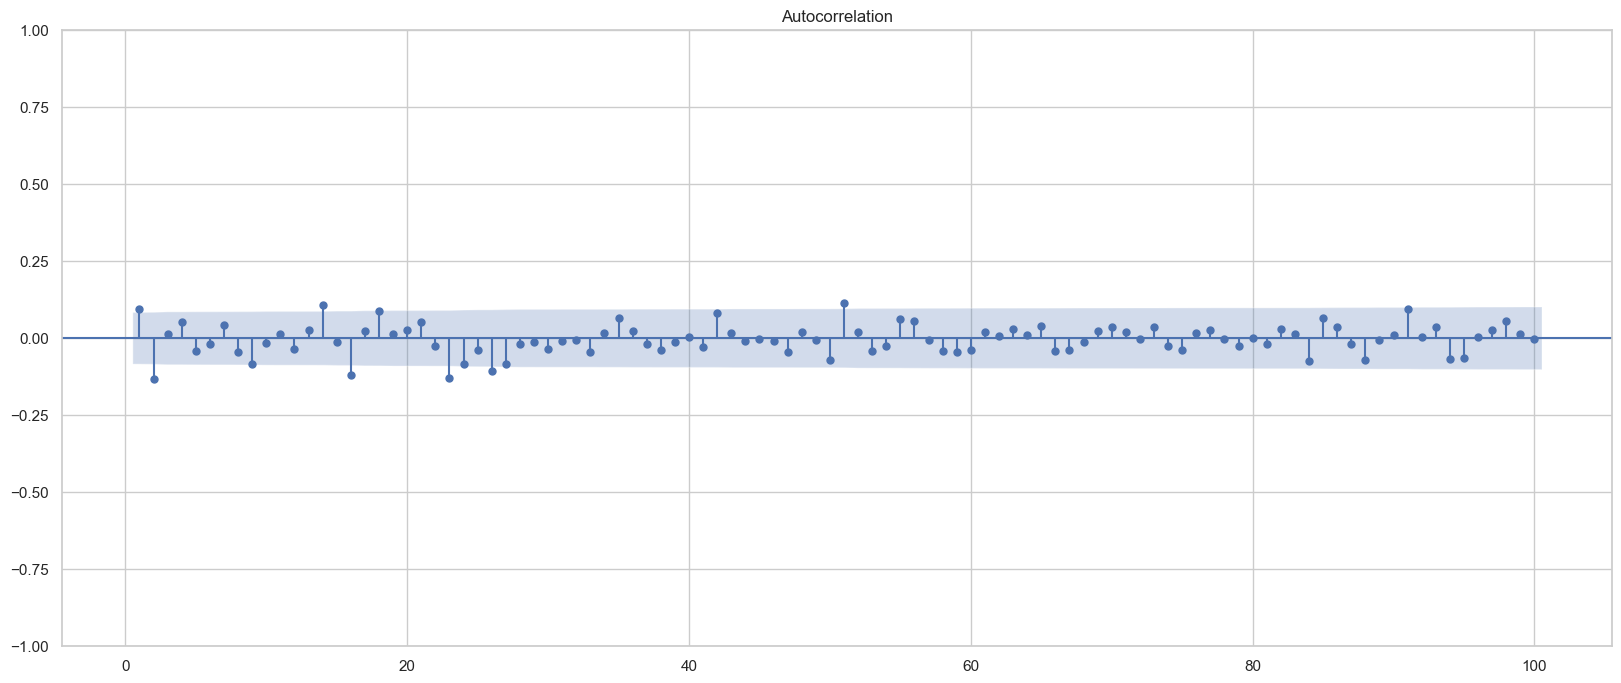

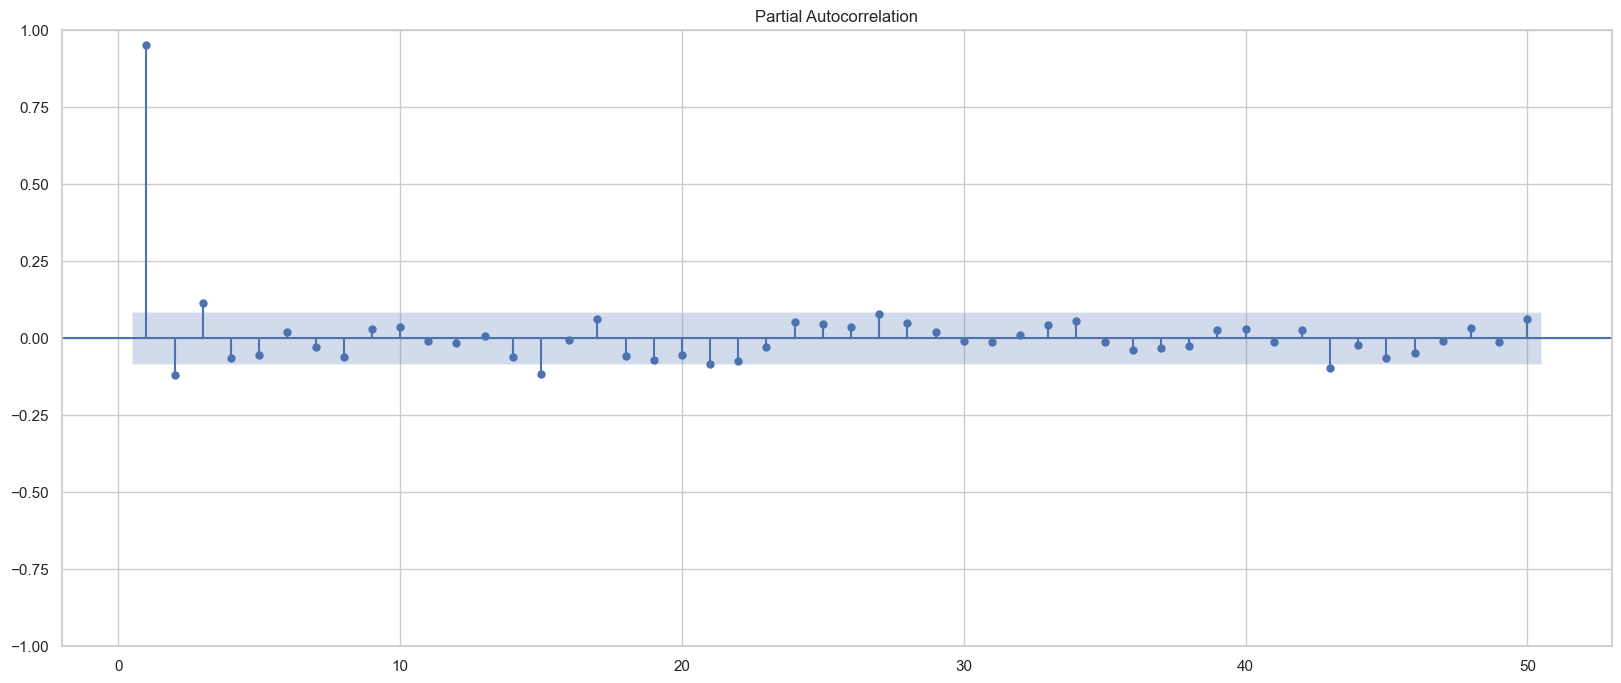

In [79]:
plot_acf(df_st["Russian"], lags=100, zero=False);
plot_pacf(df["Russian"], lags=50, zero=False);

In [93]:
params["Russian"] = {
    "order": (3, 0, 2),
    "seasonal_order": (1, 0, 1, 14),
}


**Japanese**


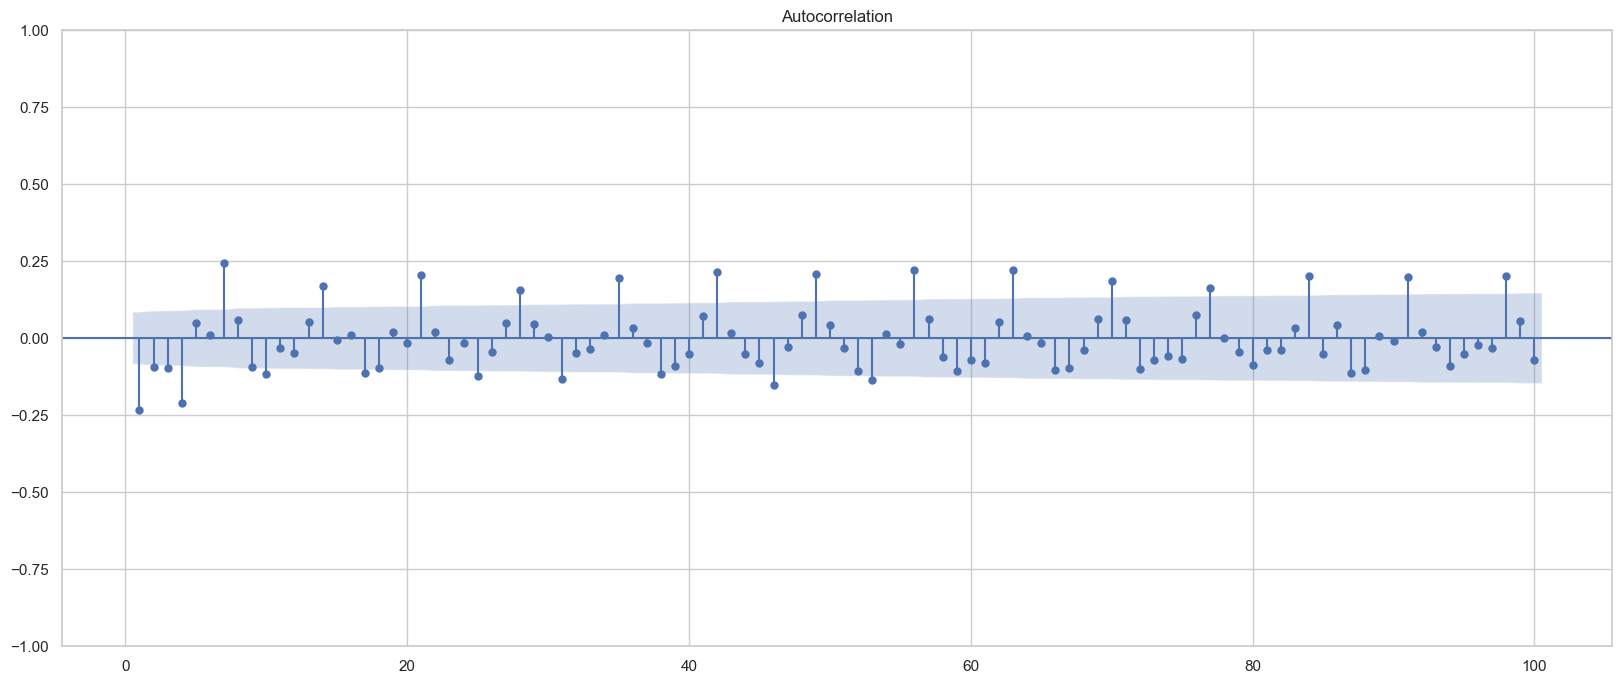

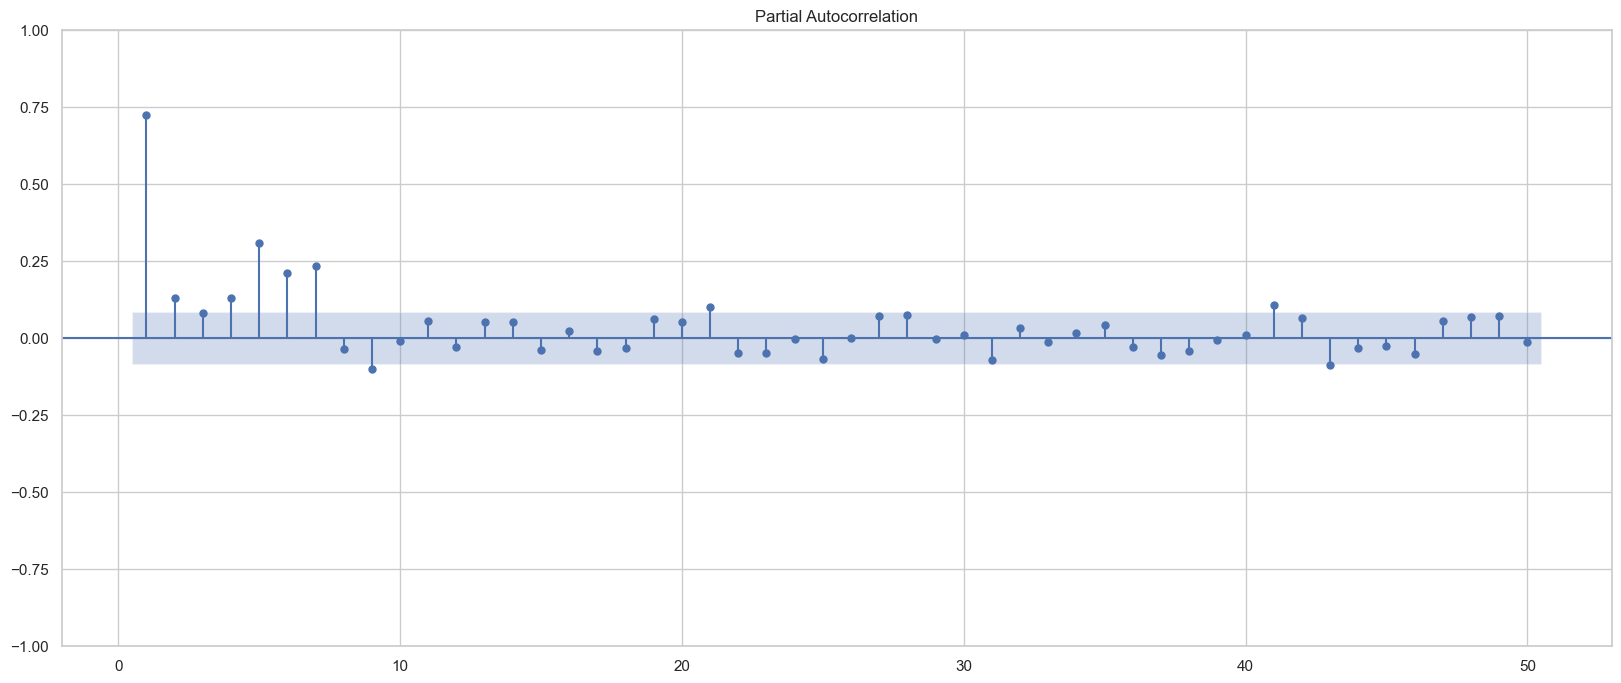

In [80]:
plot_acf(df_st["Japanese"], lags=100, zero=False);
plot_pacf(df["Japanese"], lags=50, zero=False);

In [94]:
params["Japanese"] = {
    "order": (2, 1, 4),
    "seasonal_order": (1, 0, 15, 7),
}


**French**


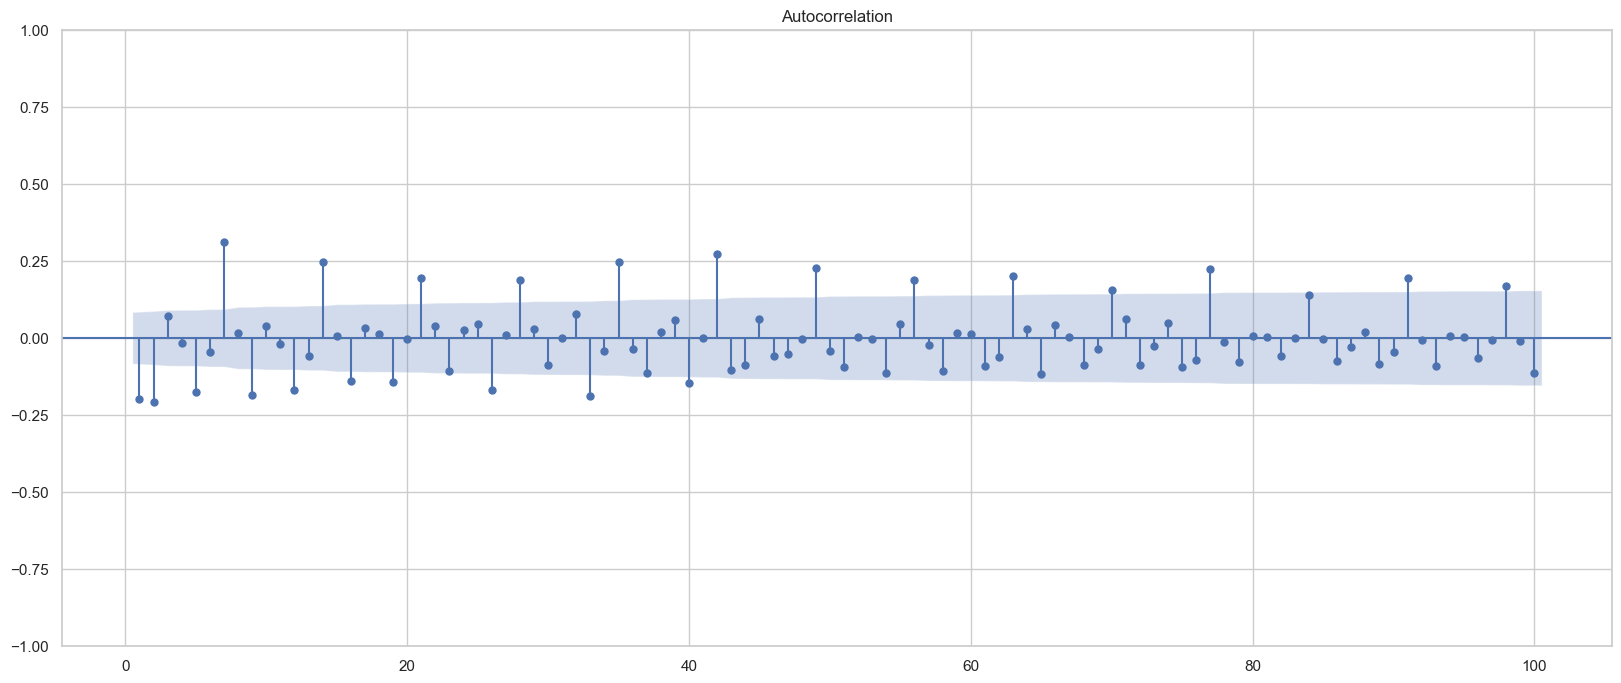

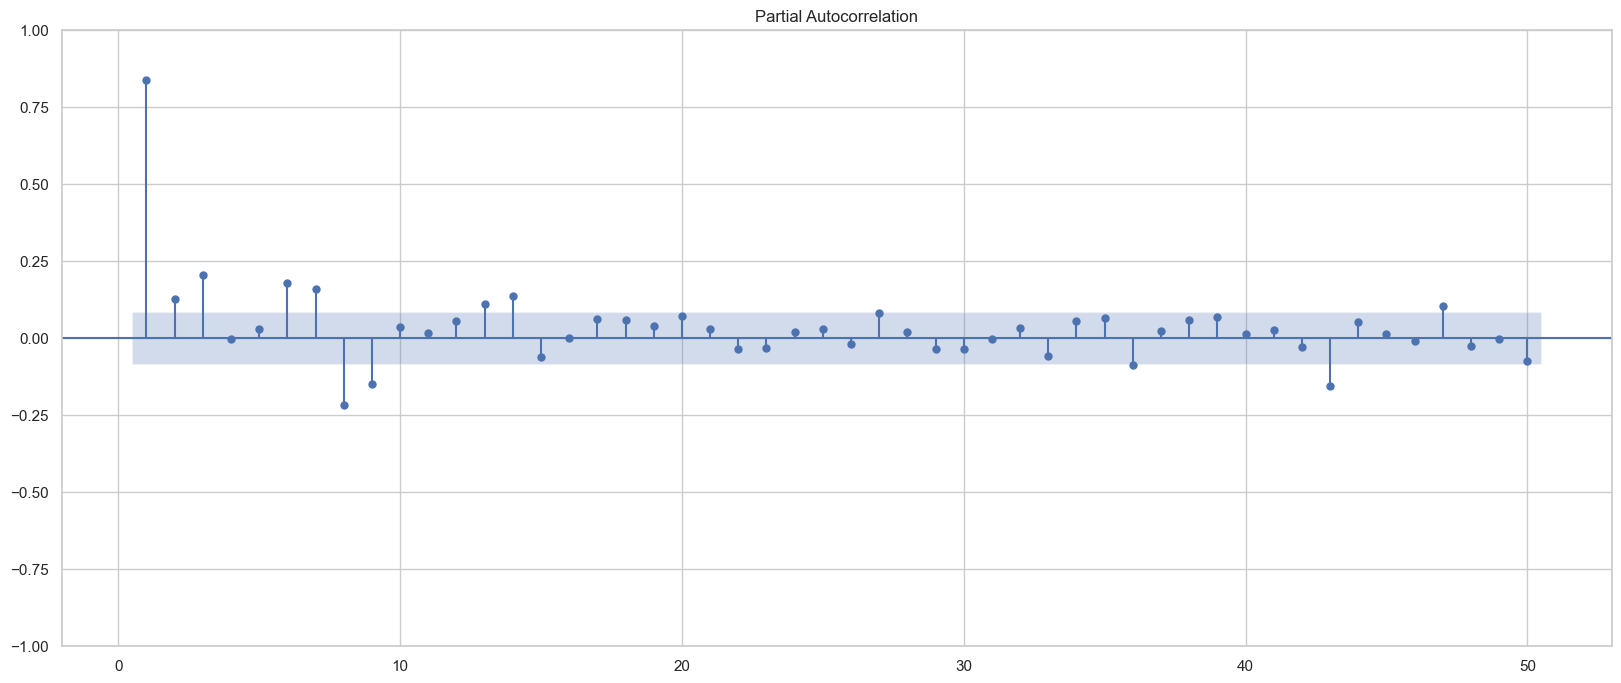

In [81]:
plot_acf(df_st["French"], lags=100, zero=False);
plot_pacf(df["French"], lags=50, zero=False);

In [95]:
params["French"] = {
    "order": (3, 1, 2),
    "seasonal_order": (2, 0, 9, 7),
}

**German**

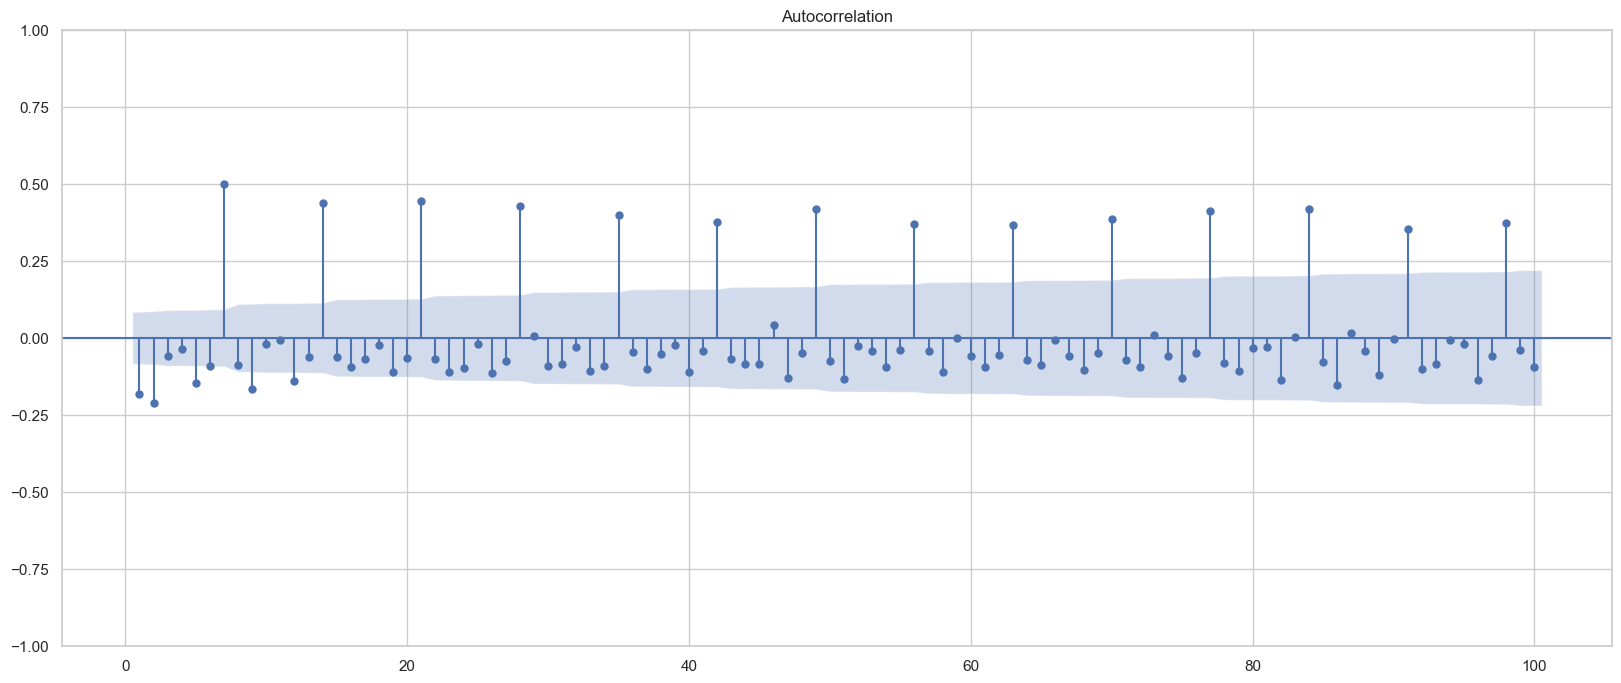

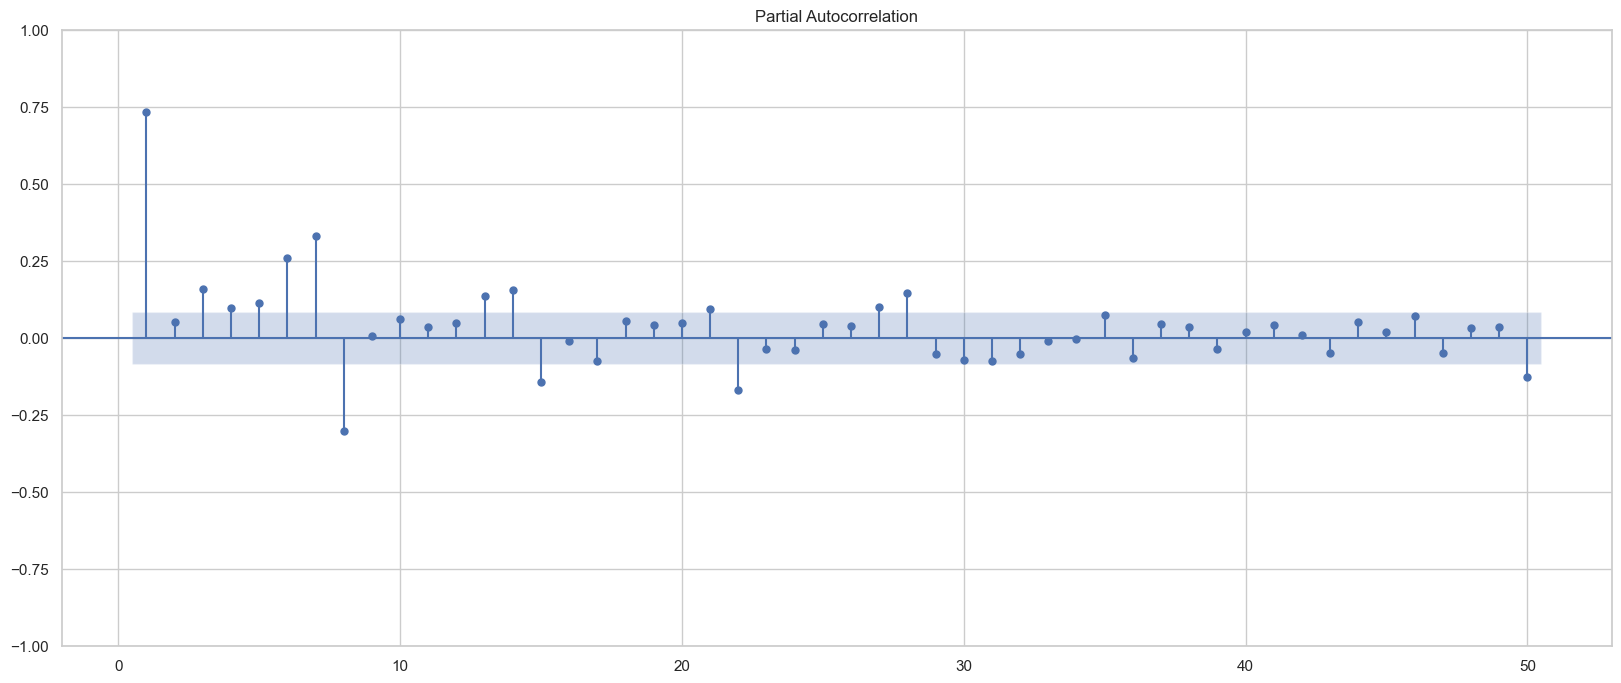

In [82]:
plot_acf(df_st["German"], lags=100, zero=False);
plot_pacf(df["German"], lags=50, zero=False);

In [96]:
params["German"] = {
    "order": (1, 1, 2),
    "seasonal_order": (3, 0, 14, 7),
}


**Chinese**


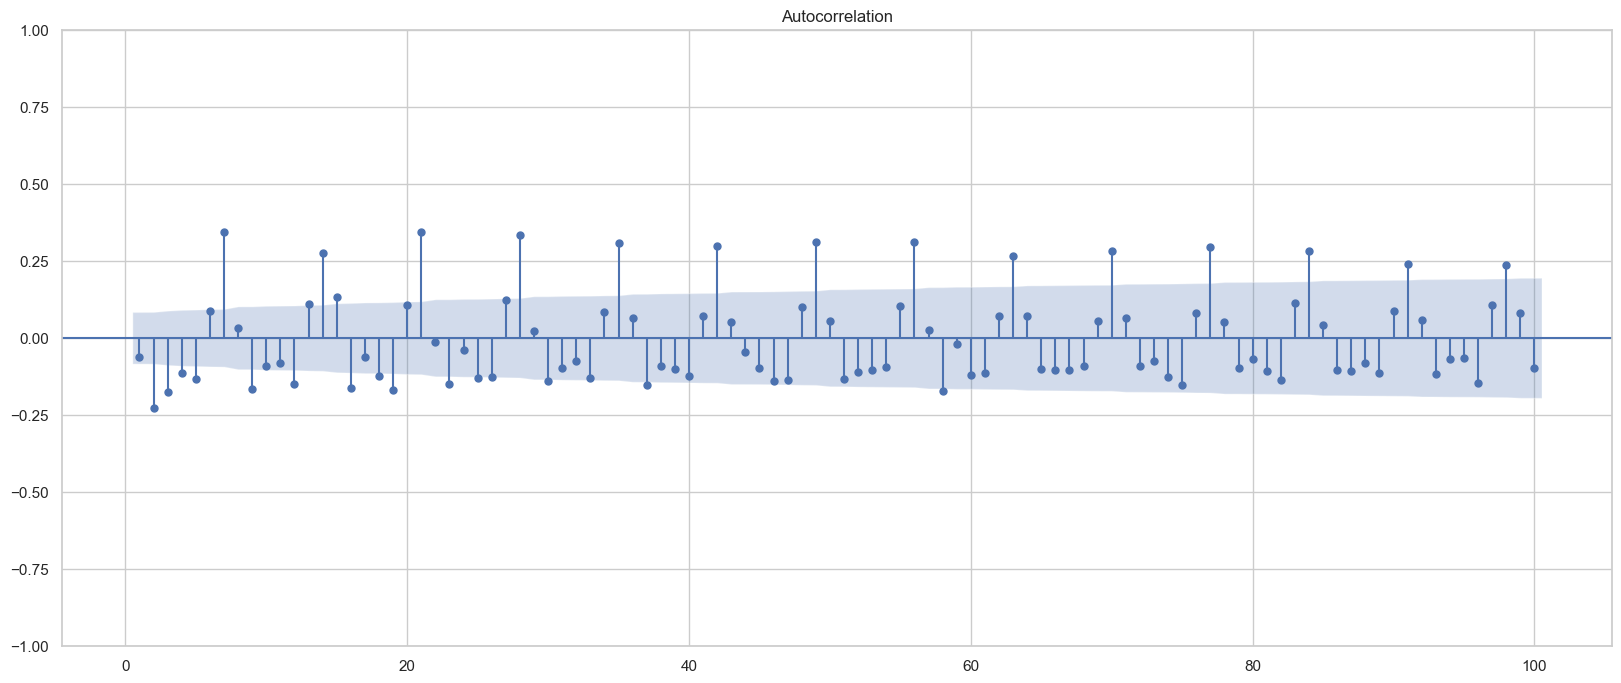

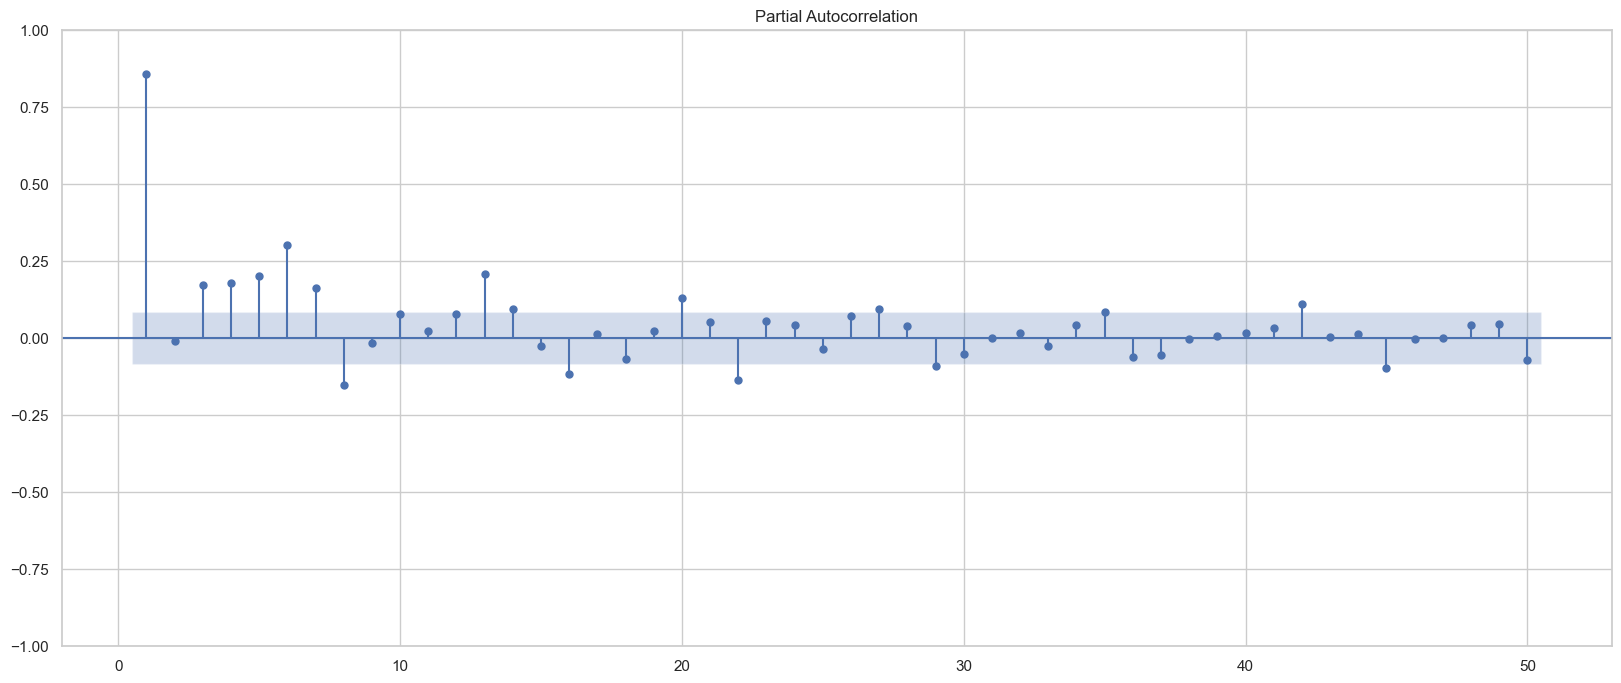

In [83]:
plot_acf(df_st["Chinese"], lags=100, zero=False);
plot_pacf(df["Chinese"], lags=50, zero=False);

In [97]:
params["Chinese"] = {
    "order": (1, 1, 5), 
    "seasonal_order": (4, 0, 14, 7), 
}

In [93]:
df_st.to_parquet("../data/processed/df_st.parquet")
df.to_parquet("../data/processed/df_pandas.parquet")

In [98]:
params
# import json
# with open("../data/processed/params.json", "w") as f:
#     json.dump(params, f)

{'English': {'order': (1, 1, 5), 'seasonal_order': (1, 0, 1, 7)},
 'Spanish': {'order': (6, 1, 6), 'seasonal_order': (2, 0, 14, 7)},
 'Russian': {'order': (3, 1, 2), 'seasonal_order': (1, 0, 1, 14)},
 'Japanese': {'order': (2, 1, 4), 'seasonal_order': (1, 0, 15, 7)},
 'French': {'order': (3, 1, 2), 'seasonal_order': (2, 0, 9, 7)},
 'German': {'order': (1, 1, 2), 'seasonal_order': (4, 0, 14, 7)},
 'Chinese': {'order': (1, 1, 5), 'seasonal_order': (4, 0, 14, 7)}}

# Model Building

In [3]:
df=pd.read_parquet("../data/processed/df_pandas.parquet")

In [18]:
def performance(actual, predicted):
    print('MAE :', round(mae(actual, predicted), 3))
    print('RMSE :', round(mse(actual, predicted)**0.5, 3))
    print('MAPE:', round(mape(actual, predicted), 3))

In [23]:
# time based split
train = df.iloc[:int(0.8*len(df))]
test = df.iloc[int(0.8*len(df)):]

## ARIMA
**Pipeline to handle all languages**

Training Spanish...


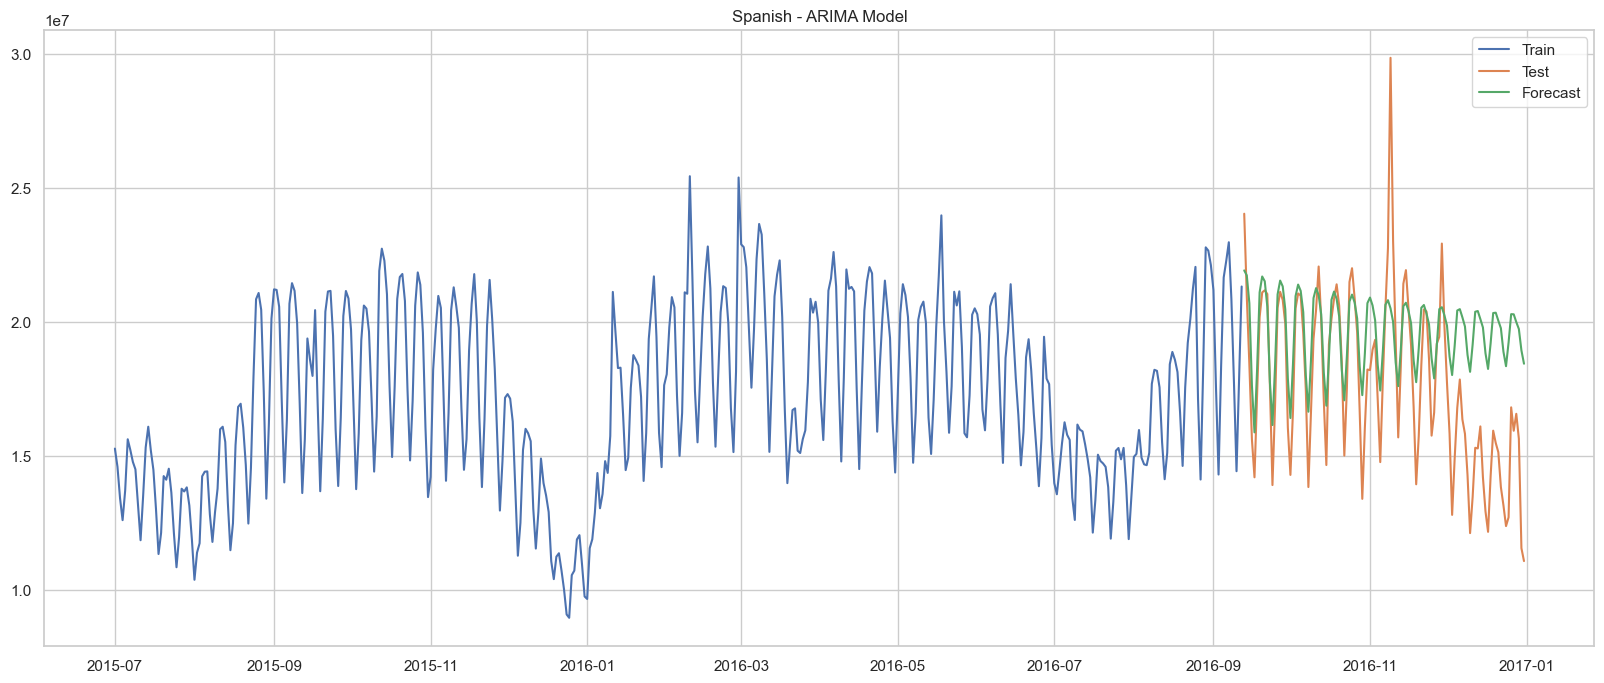

Training Japanese...


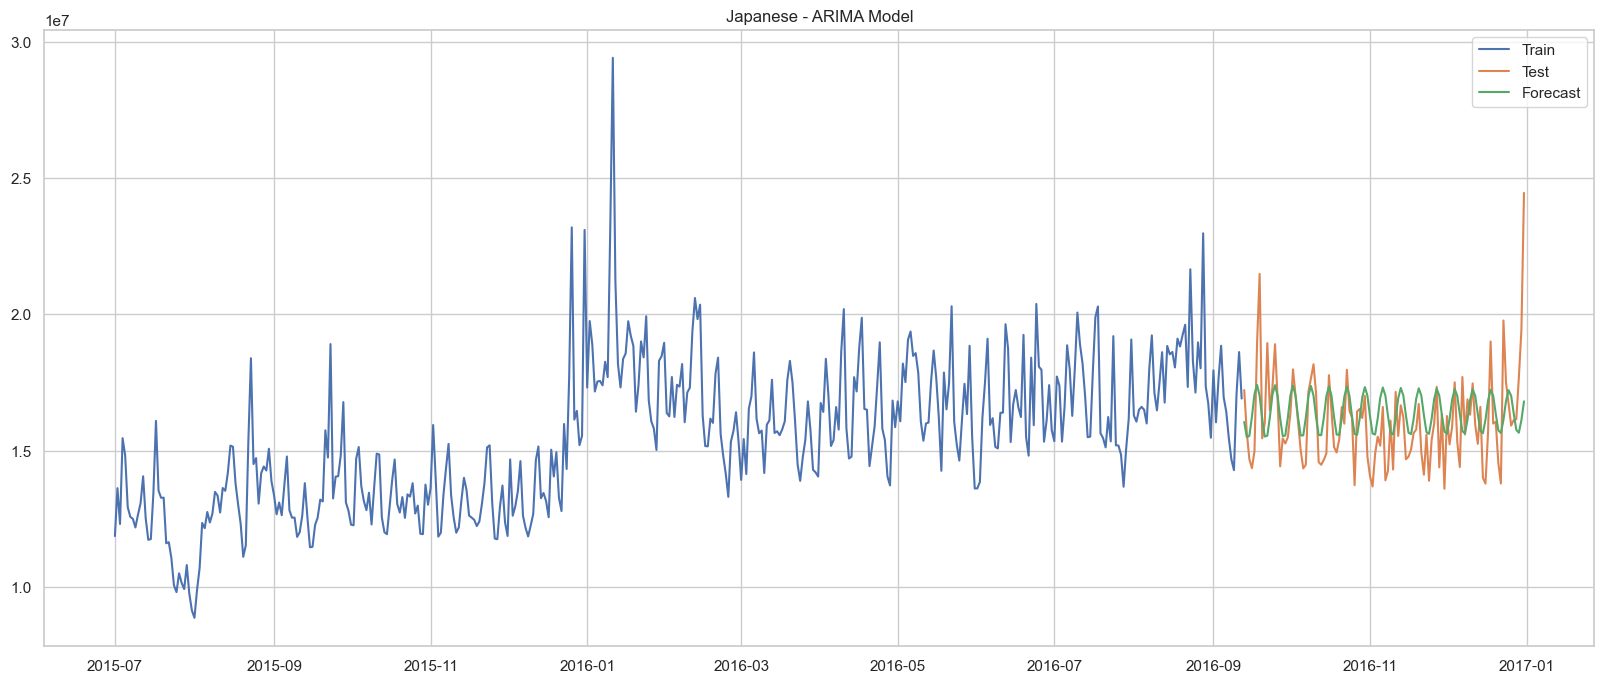

Training English...


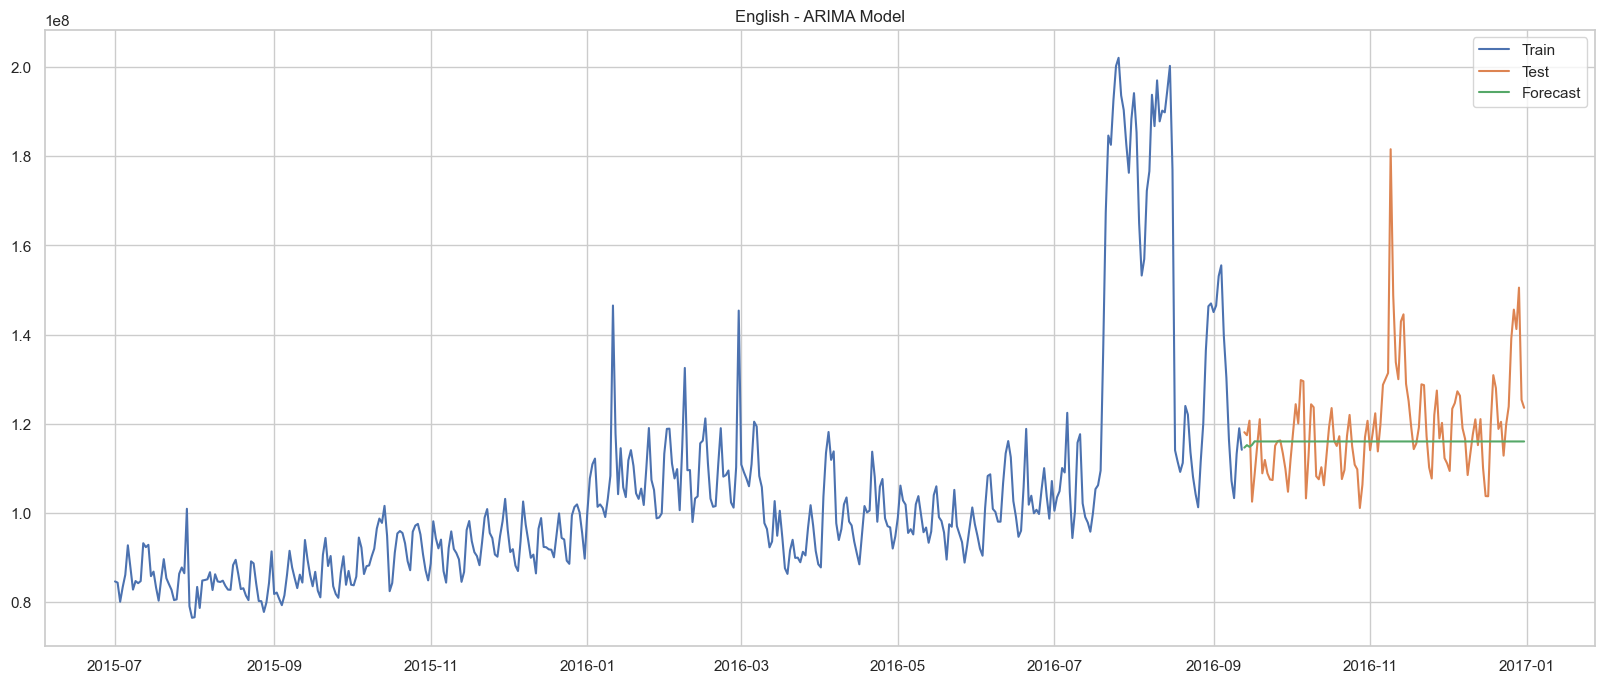

Training Chinese...


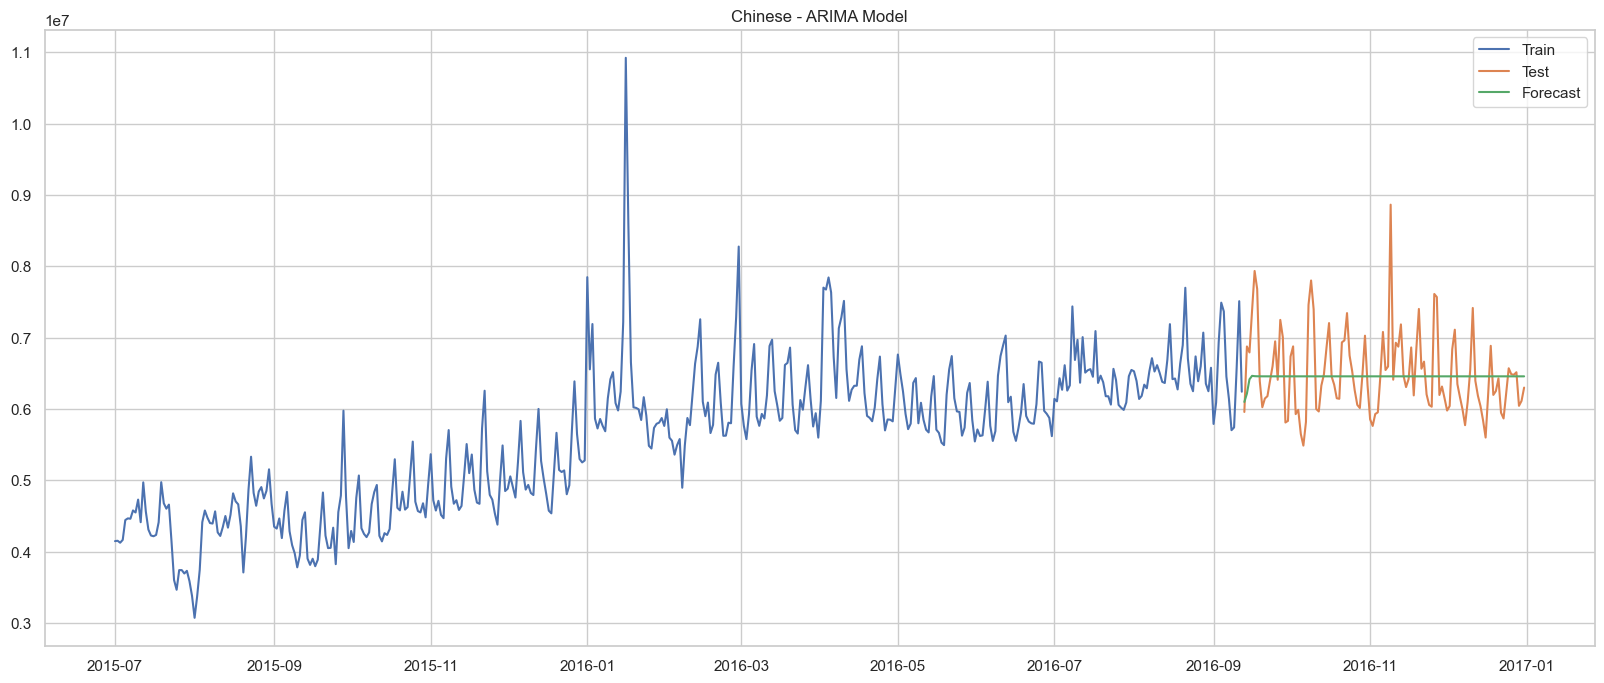

Training German...


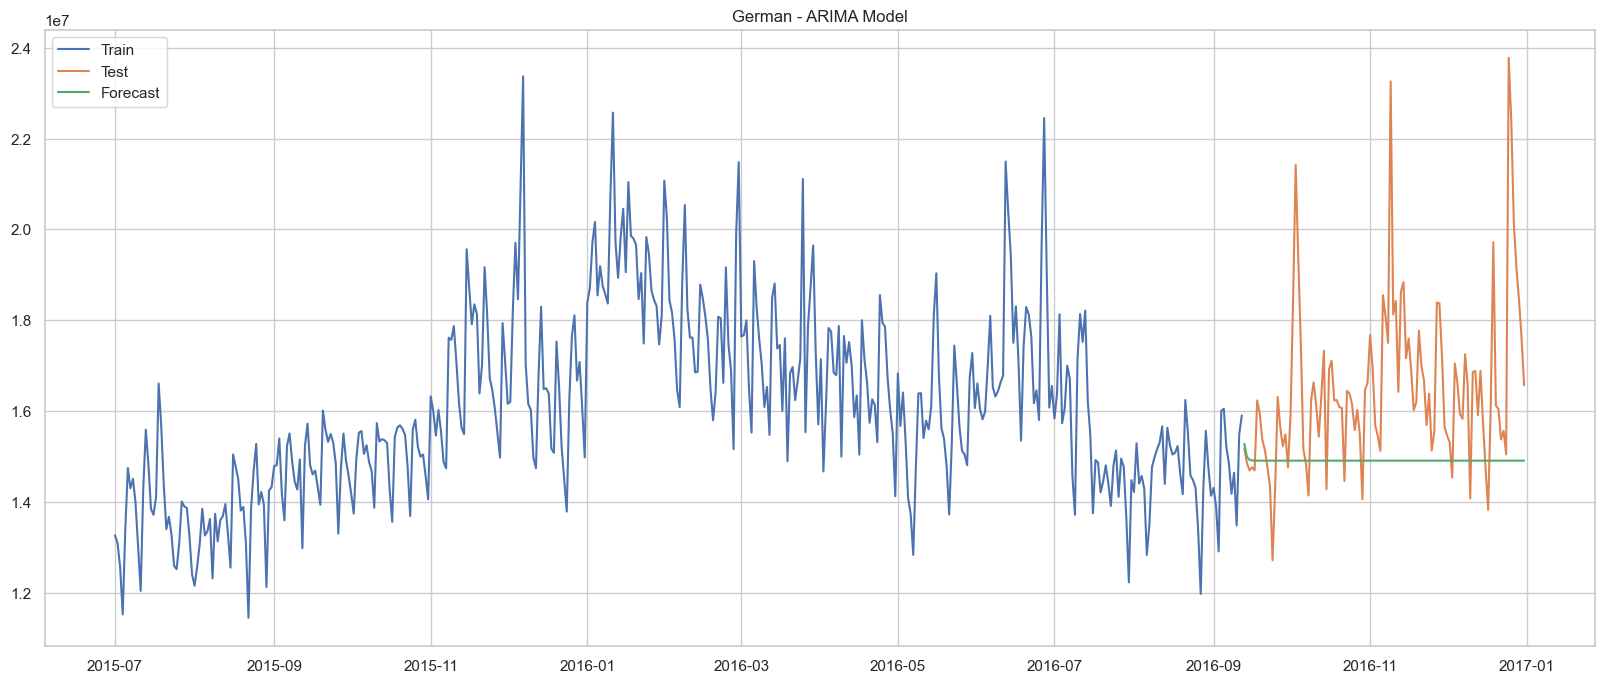

Training Russian...


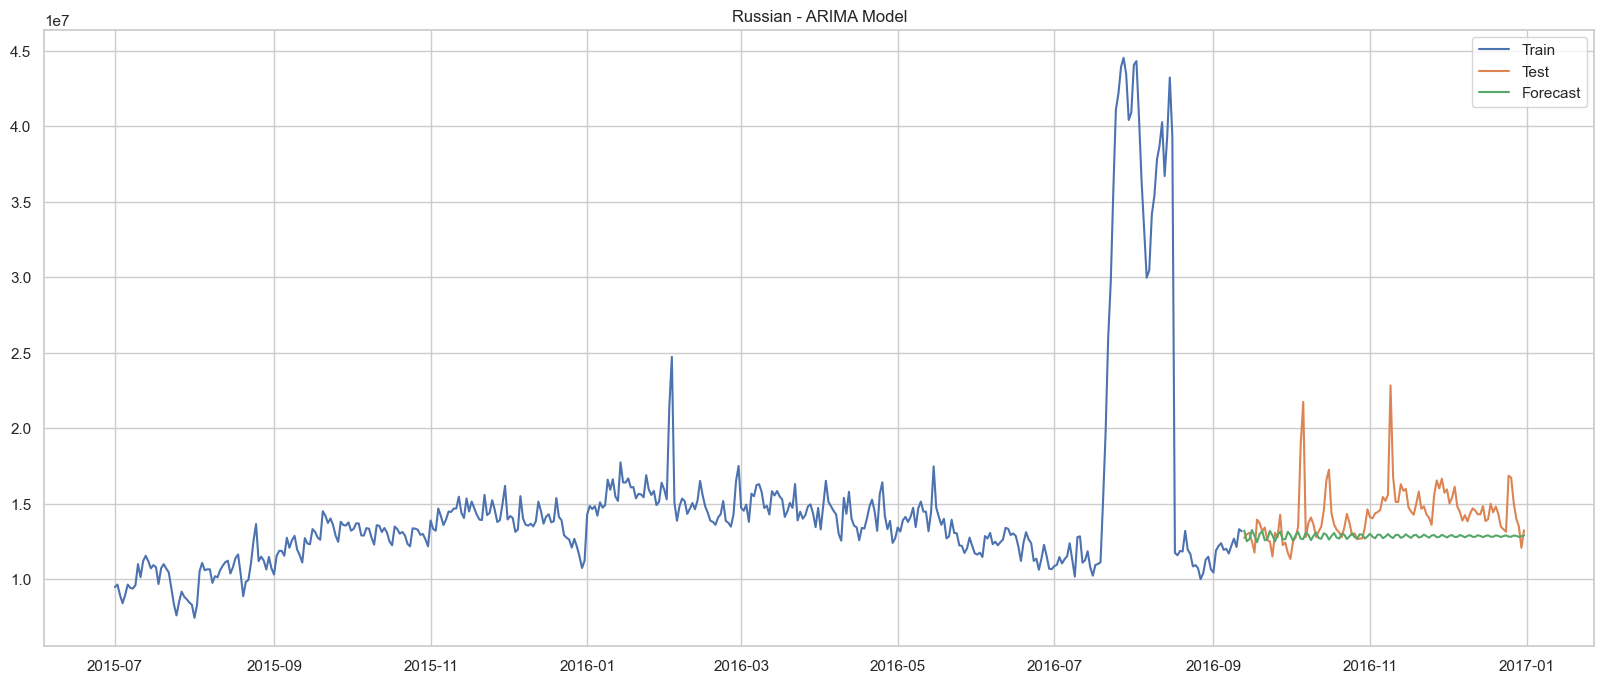

Training French...


c:\Users\v-gautamnaik\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\v-gautamnaik\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


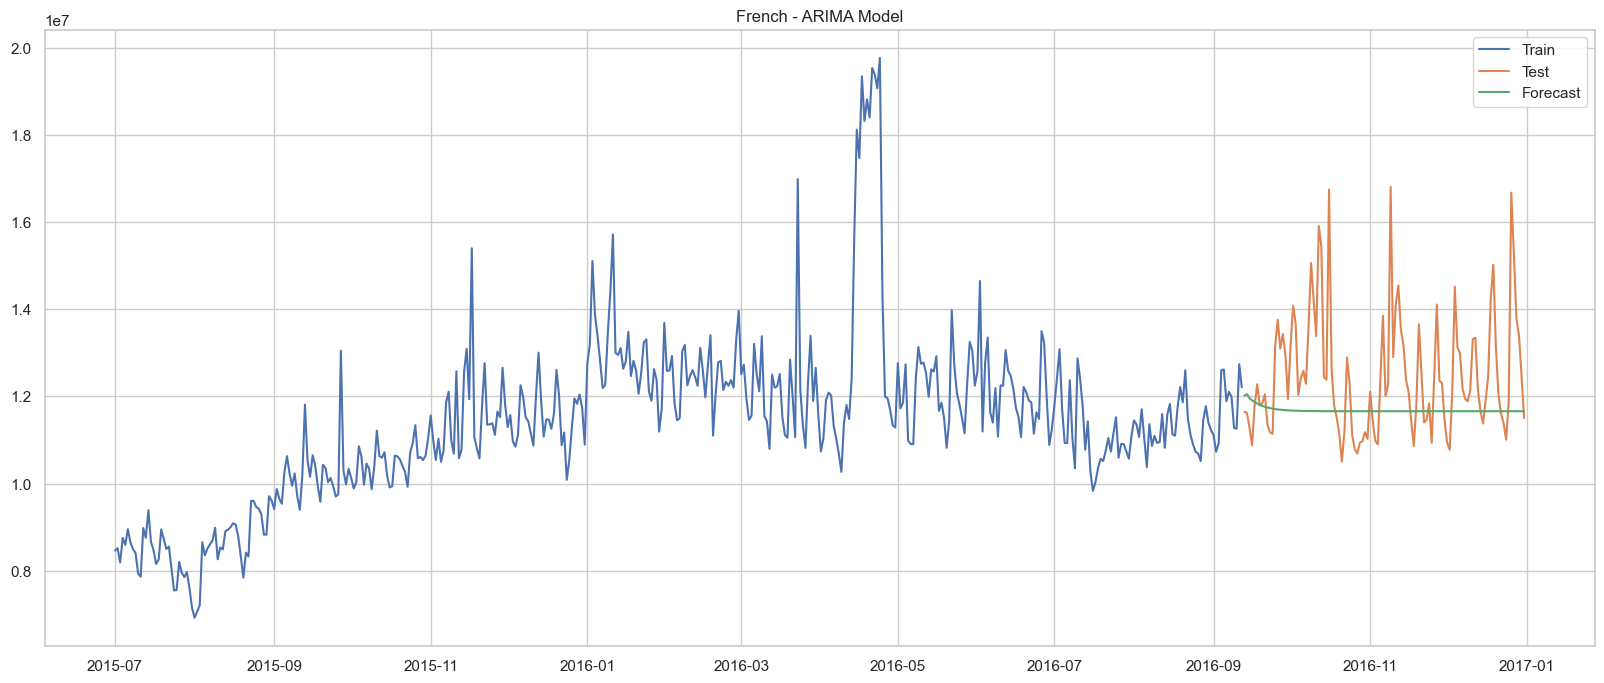

In [99]:
results = []
models={}

for column in columns:
    print(f"Training {column}...")
    model = SARIMAX(train[column], order=params[column]["order"])
    model_fit = model.fit()
    forecast = model_fit.forecast(steps=len(test))
    # models[column] = model_fit
    
    results.append({
        "Language": column,
        'MAE': round(mae(test[column], forecast), 3),
        'RMSE': round(mse(test[column], forecast)**0.5, 3),
        'MAPE': round(mape(test[column], forecast), 3),
        'p': params[column]["order"][0],
        'd': params[column]["order"][1],
        'q': params[column]["order"][2],
    })
    
    # Plotting
    plt.figure(figsize=(20, 8))
    plt.plot(train[column], label="Train")
    plt.plot(test[column], label="Test")
    plt.plot(forecast, label="Forecast")
    plt.title(f"{column} - ARIMA Model")
    plt.legend()
    plt.show()

# Convert results to DataFrame
results_df = pd.DataFrame(results)

In [42]:
results_df.sort_values("MAPE")

Language          MAE          RMSE   MAPE  p  d  q
2   English  8306097.860  1.210796e+07  0.066  1  1  5
3   Chinese   438204.793  5.718531e+05  0.066  1  1  5
6    French  1140287.880  1.596890e+06  0.085  3  1  2
1  Japanese  1524784.613  1.889121e+06  0.097  2  1  1
4    German  1752924.870  2.408183e+06  0.098  1  1  2
5   Russian  1657838.177  2.290341e+06  0.107  3  1  2
0   Spanish  2348818.160  3.101108e+06  0.153  6  1  6

## SARIMA
**Pipeline to handle all languages**

Training Spanish...


c:\Users\v-gautamnaik\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


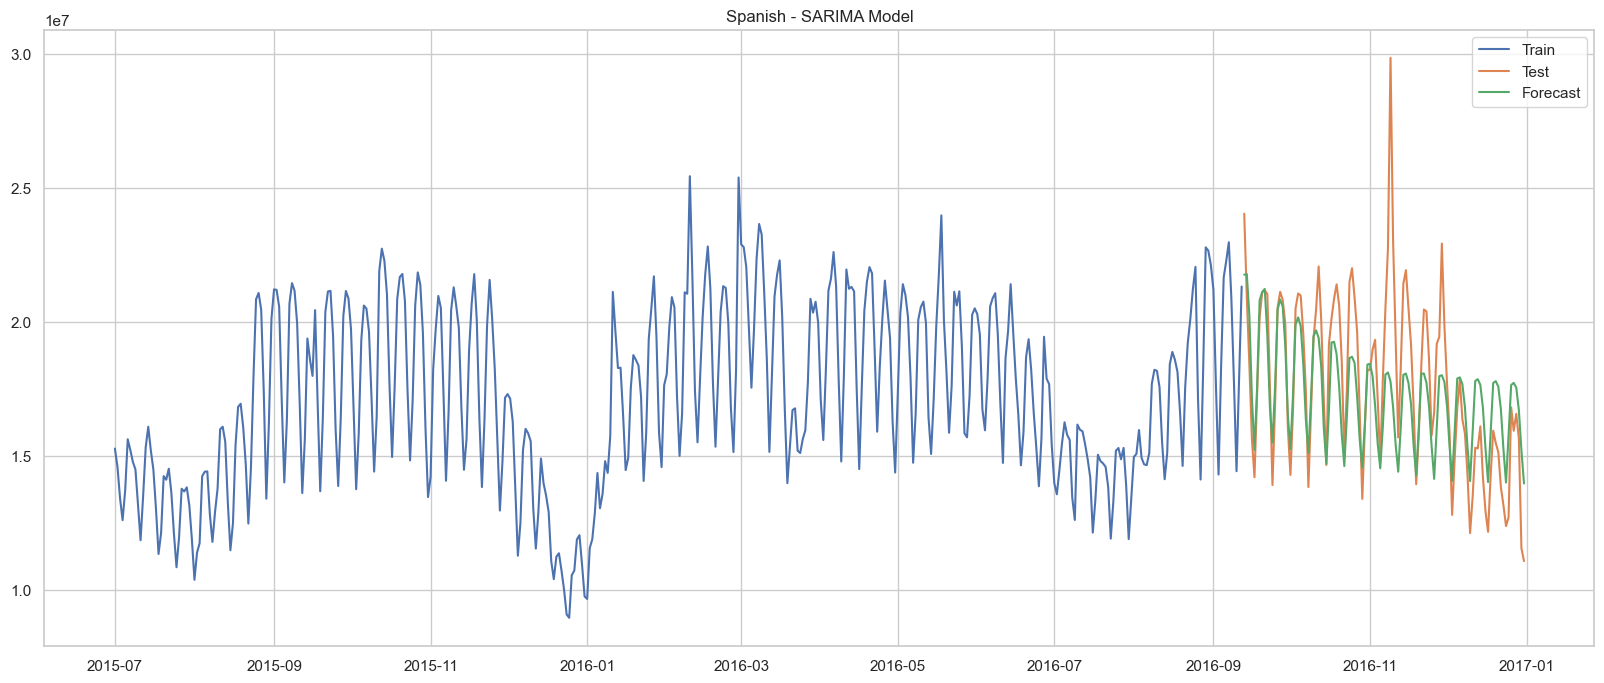

Training Japanese...


c:\Users\v-gautamnaik\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


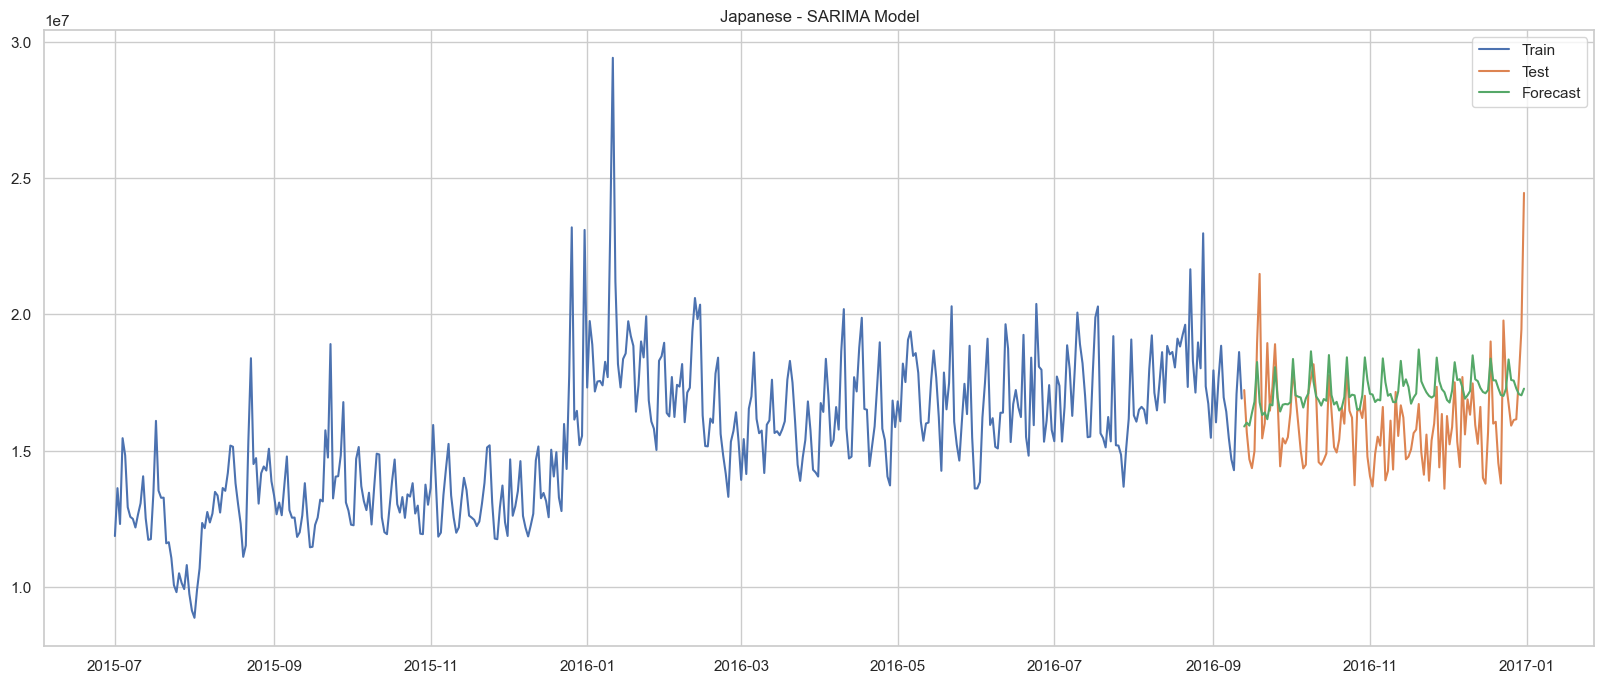

Training English...


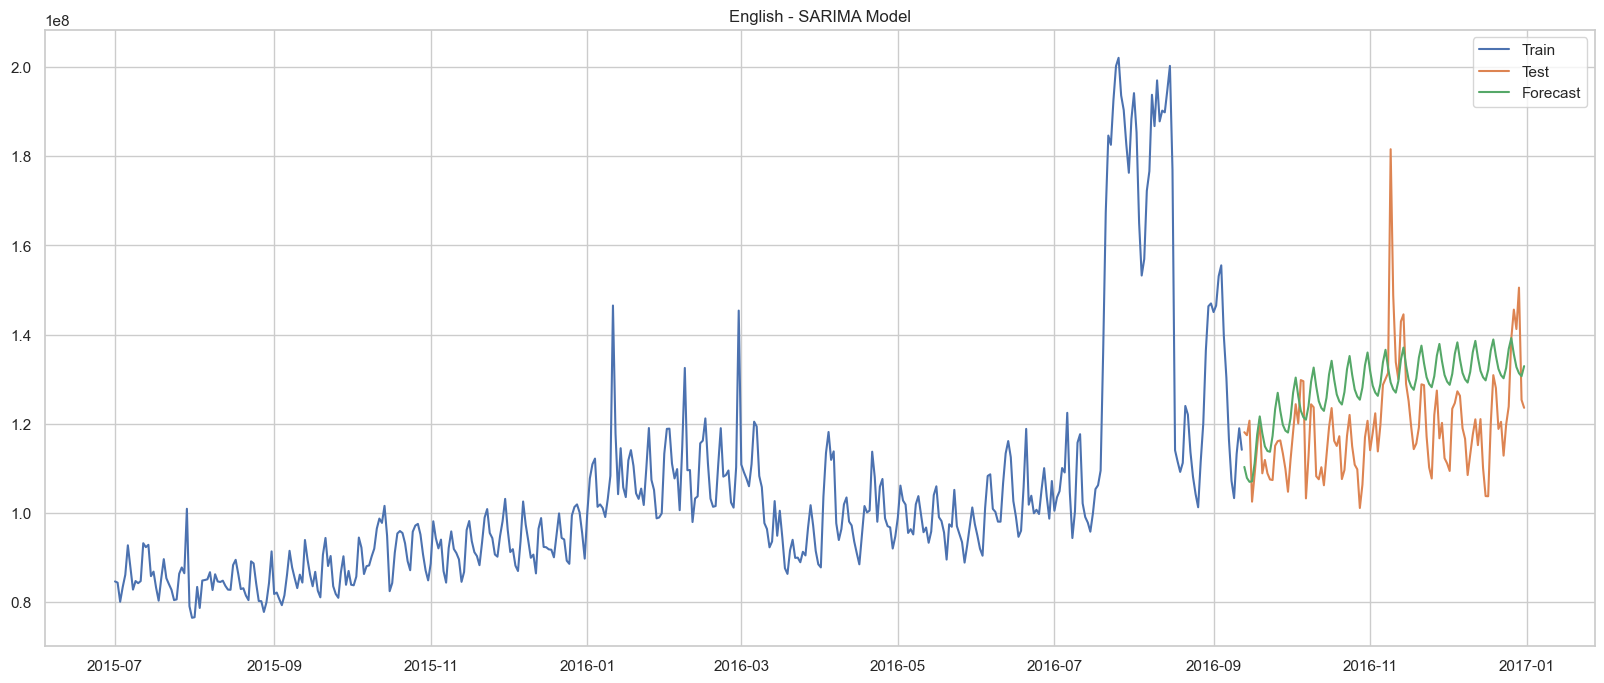

Training Chinese...


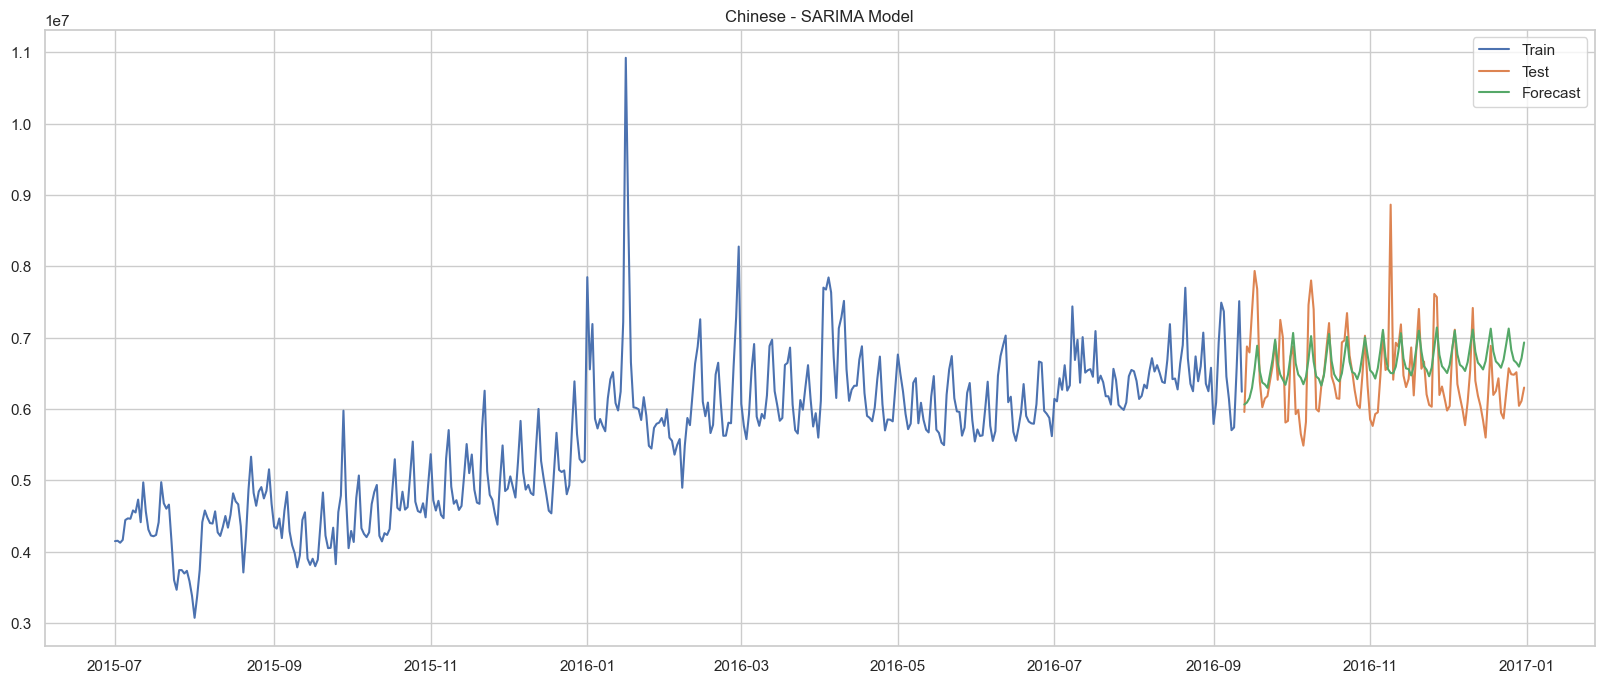

Training German...


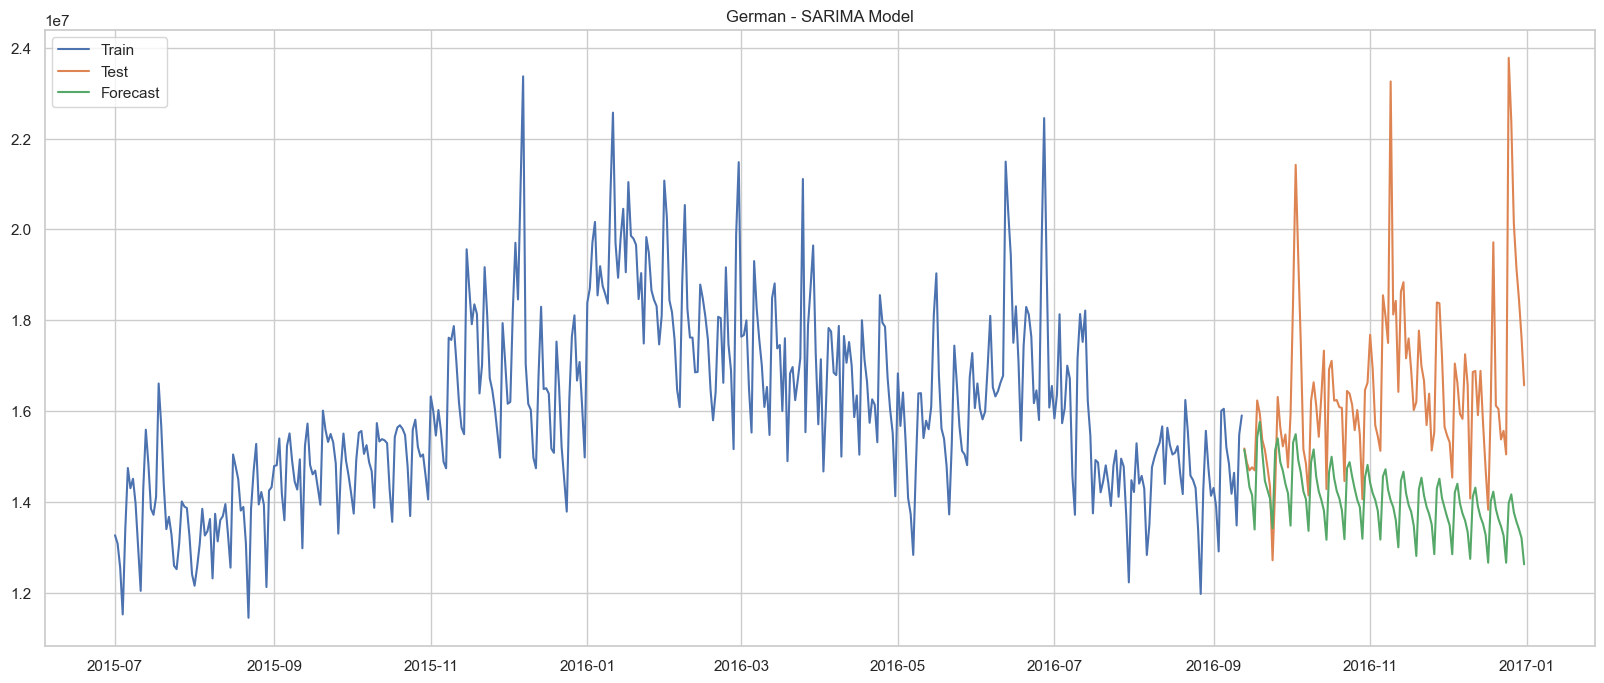

Training Russian...


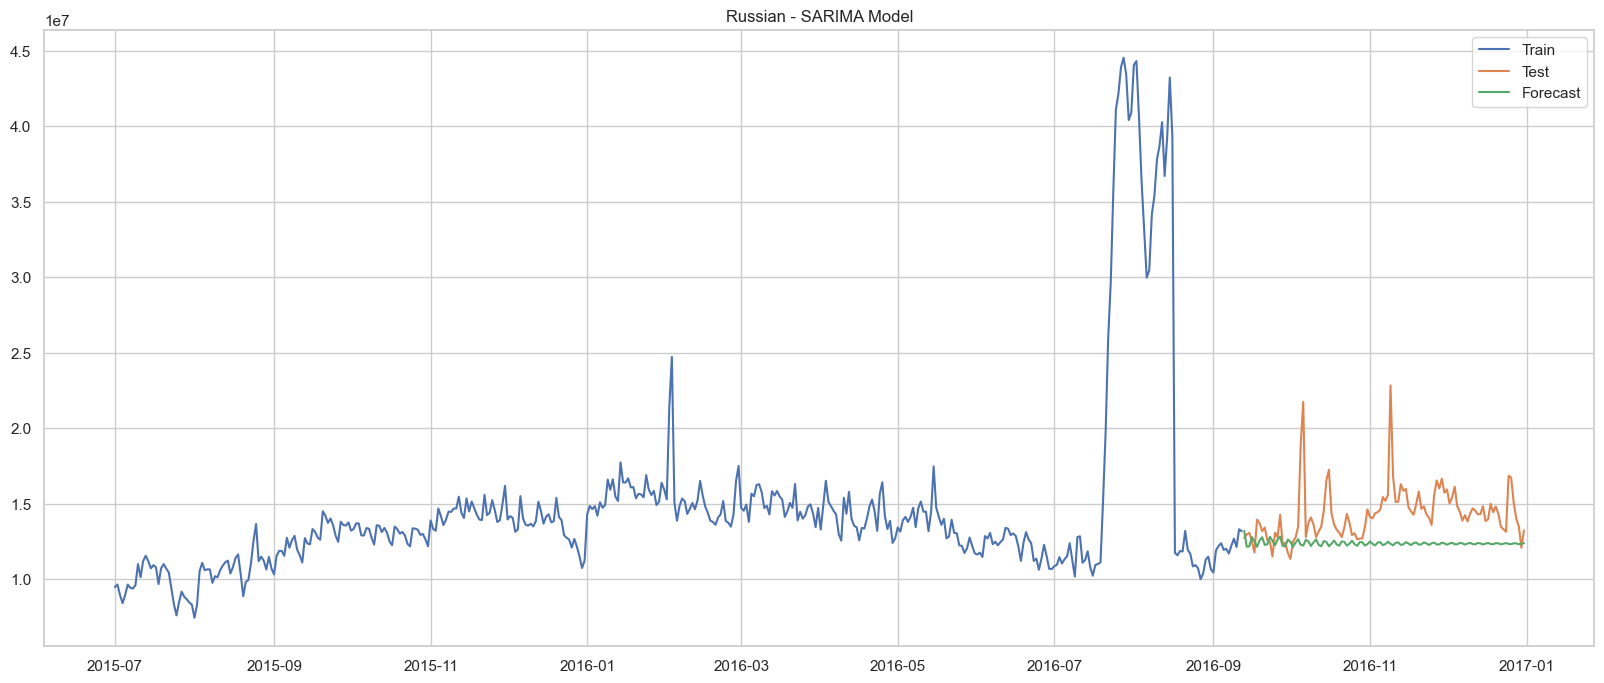

Training French...


c:\Users\v-gautamnaik\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\v-gautamnaik\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


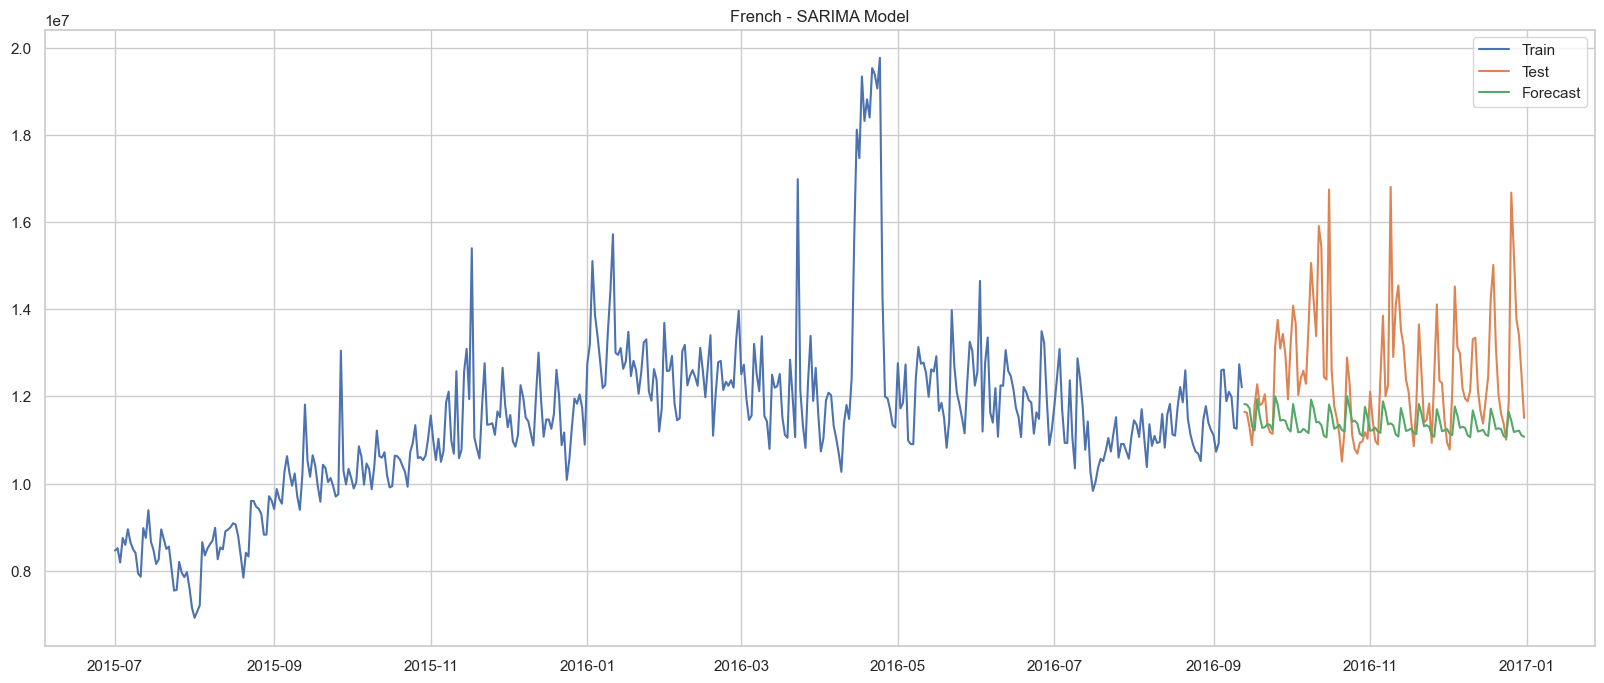

In [101]:
results = []
models={}
cache = {}

for column in columns:

    print(f"Training {column}...")
    model = SARIMAX(train[column], order=params[column]["order"], seasonal_order=params[column]["seasonal_order"])
    model_fit = model.fit()
    forecast = model_fit.forecast(steps=len(test))
    models[column] = model_fit
    
    results.append({
        "Language": column,
        'MAE': round(mae(test[column], forecast), 3),
        'RMSE': round(mse(test[column], forecast)**0.5, 3),
        'MAPE': round(mape(test[column], forecast), 3),
        'p': params[column]["order"][0],
        'd': params[column]["order"][1],
        'q': params[column]["order"][2],
        'P': params[column]["seasonal_order"][0],
        'D': params[column]["seasonal_order"][1],
        'Q': params[column]["seasonal_order"][2],
        'S': params[column]["seasonal_order"][3],
    })
    
    # Plotting
    plt.figure(figsize=(20, 8))
    plt.plot(train[column], label="Train")
    plt.plot(test[column], label="Test")
    plt.plot(forecast, label="Forecast")
    plt.title(f"{column} - SARIMA Model")
    plt.legend()
    plt.show()

# Convert results to DataFrame
results_df = pd.DataFrame(results)

In [102]:
results_df.sort_values("MAPE")

Language           MAE          RMSE   MAPE  p  d  q  P  D   Q   S
3   Chinese  4.226808e+05  5.364987e+05  0.065  1  1  5  4  0  14   7
6    French  1.247096e+06  1.711687e+06  0.092  3  1  2  2  0   9   7
0   Spanish  1.718605e+06  2.293428e+06  0.097  6  1  6  2  0  14   7
1  Japanese  1.599290e+06  1.961434e+06  0.102  2  1  4  1  0  15   7
2   English  1.214013e+07  1.400092e+07  0.103  1  1  5  1  0   1   7
5   Russian  2.022044e+06  2.622408e+06  0.132  3  1  2  1  0   1  14
4    German  2.456478e+06  3.004588e+06  0.141  1  1  2  4  0  14   7

## SARIMAX

In [30]:
params["English"] = { "order": (6, 1, 6), "seasonal_order": (1, 0, 1, 7) }
model = SARIMAX(train["English"], order=params["English"]["order"], exog=train["Exog"], seasonal_order= params["English"]["seasonal_order"] )
model_fit = model.fit()
forecast = model_fit.forecast(steps=len(test), exog=test["Exog"])
performance(test["English"], forecast)

0.052988798444877507

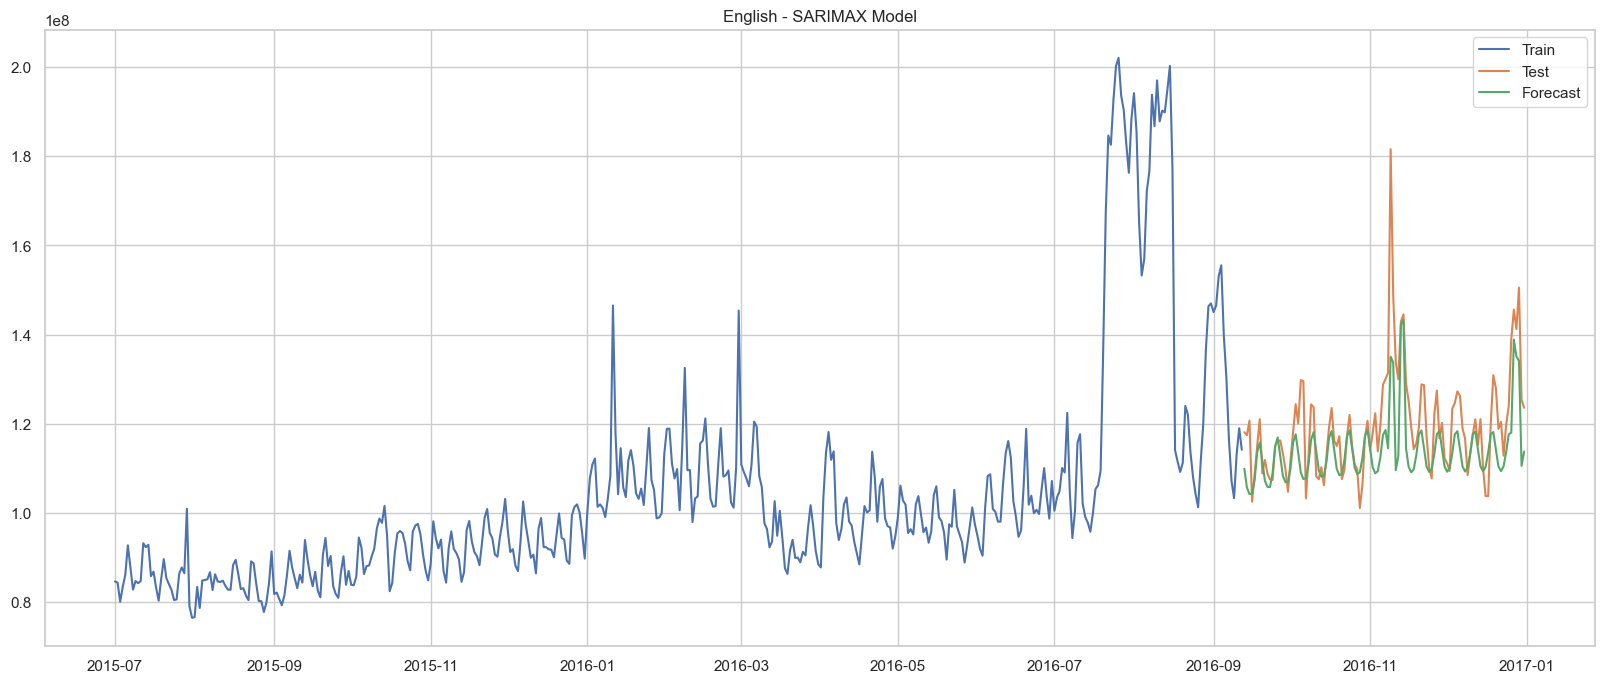

In [31]:
# Plotting
plt.figure(figsize=(20, 8))
plt.plot(train["English"], label="Train")
plt.plot(test["English"], label="Test")
plt.plot(forecast, label="Forecast")
# plt.xlim(test.index.min()-timedelta(days=50), test.index.max())
plt.title("English - SARIMAX Model")
plt.legend()
plt.show()

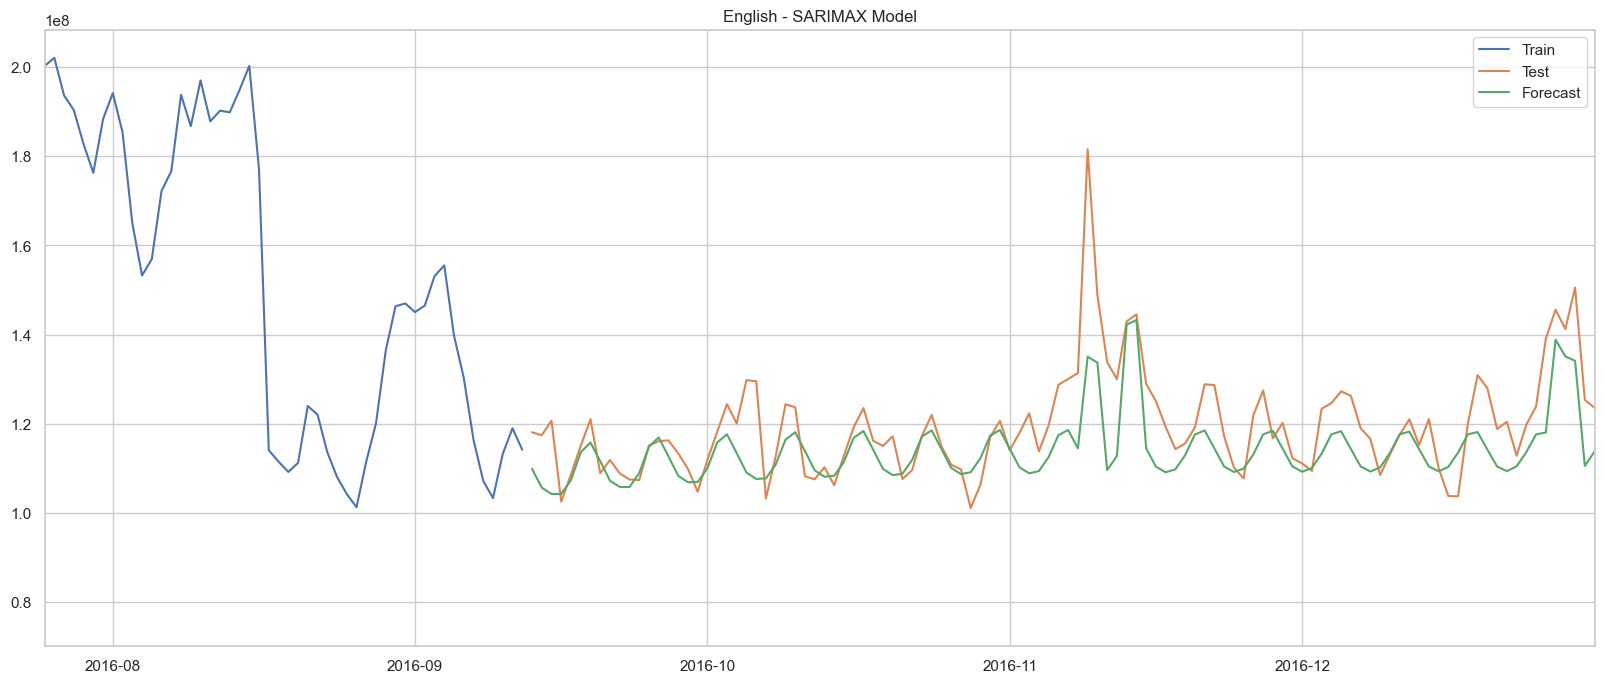

In [32]:
# Plotting
plt.figure(figsize=(20, 8))
plt.plot(train["English"], label="Train")
plt.plot(test["English"], label="Test")
plt.plot(forecast, label="Forecast")
plt.xlim(test.index.min()-timedelta(days=50), test.index.max())
plt.title("English - SARIMAX Model")
plt.legend()
plt.show()

## Hyperparameter Tuning using Optuna

In [5]:
def performance(true_values, predictions):
    return mape(true_values, predictions)

In [ ]:
def objective(trial):

    p = trial.suggest_int('p', 0, 7)  # AR 
    # d = trial.suggest_int('d', 0, 2)  # Diff
    q = trial.suggest_int('q', 0, 7)  # MA 
    P = trial.suggest_int('P', 0, 2)  # Seasonal AR 
    D = trial.suggest_int('D', 0, 1)  # Seasonal diff
    Q = trial.suggest_int('Q', 0, 2)  # Seasonal MA 
    S = 7 # weekly seasonality

    order = (p, 1, q)
    seasonal_order = (P, D, Q, S)
    
    try:
        model = SARIMAX(train["English"], order=order, exog=train["Exog"], seasonal_order=seasonal_order)
        model_fit = model.fit(disp=False) 
        forecast = model_fit.forecast(steps=len(test), exog=test["Exog"])
        
        error = performance(test["English"], forecast)
    except Exception as e:
        error = np.inf

    return error

storage_name = "sqlite:///sarimax_optuna_study.db"

study = optuna.create_study(direction='minimize', study_name="sarimax_study", storage=storage_name, load_if_exists=True)

study.optimize(objective, n_trials=100)

In [75]:
print("Best hyperparameters: ", study.best_trial.params)
print("Best MAPE: ", study.best_value)

Best hyperparameters:  {'p': 3, 'q': 5, 'P': 0, 'D': 1, 'Q': 1}
Best MAPE:  0.04394953148191757


In [77]:
params["English"] = { "order": (3, 1, 5), "seasonal_order": (0, 1, 1, 7) }
model = SARIMAX(train["English"], order=params["English"]["order"], exog=train["Exog"], seasonal_order= params["English"]["seasonal_order"] )
model_fit = model.fit()
forecast = model_fit.forecast(steps=len(test), exog=test["Exog"])
performance(test["English"], forecast)

0.04394953148191757

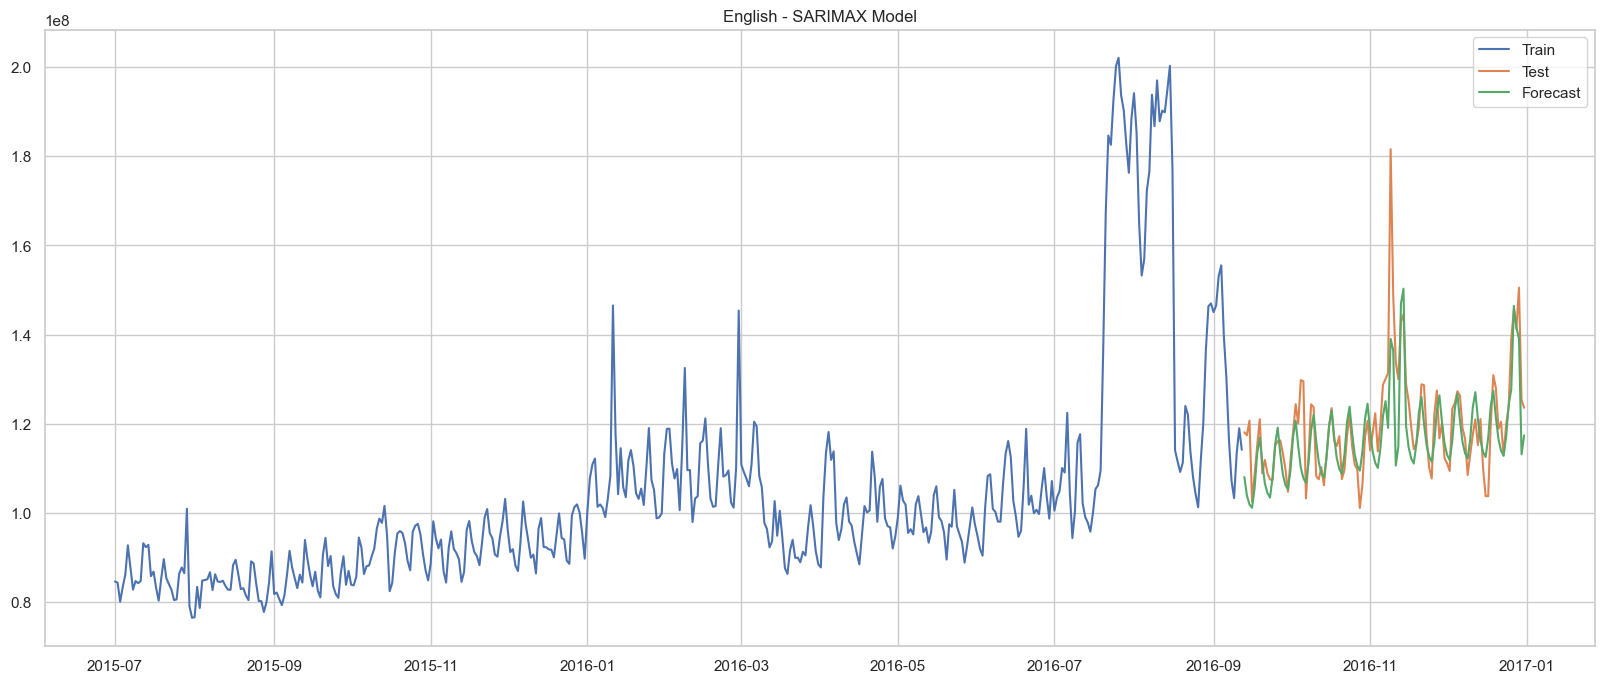

In [78]:
plt.figure(figsize=(20, 8))
plt.plot(train["English"], label="Train")
plt.plot(test["English"], label="Test")
plt.plot(forecast, label="Forecast")
# plt.xlim(test.index.min()-timedelta(days=50), test.index.max())
plt.title("English - SARIMAX Model")
plt.legend()
plt.show()

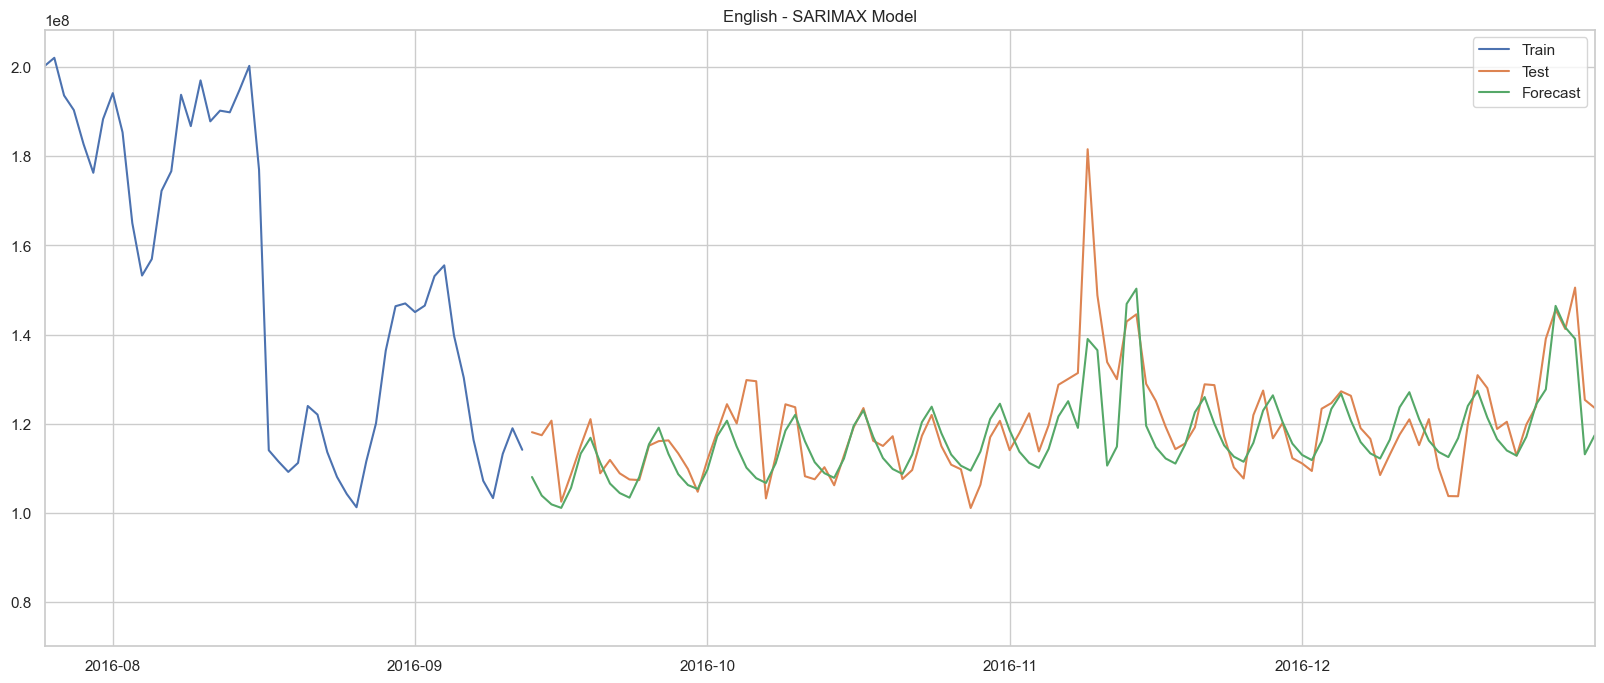

In [79]:
# Plotting
plt.figure(figsize=(20, 8))
plt.plot(train["English"], label="Train")
plt.plot(test["English"], label="Test")
plt.plot(forecast, label="Forecast")
plt.xlim(test.index.min()-timedelta(days=50), test.index.max())
plt.title("English - SARIMAX Model")
plt.legend()
plt.show()

## Prophet Model

**Pipeline to handle all languages**

02:28:40 - cmdstanpy - INFO - Chain [1] start processing
02:28:40 - cmdstanpy - INFO - Chain [1] done processing


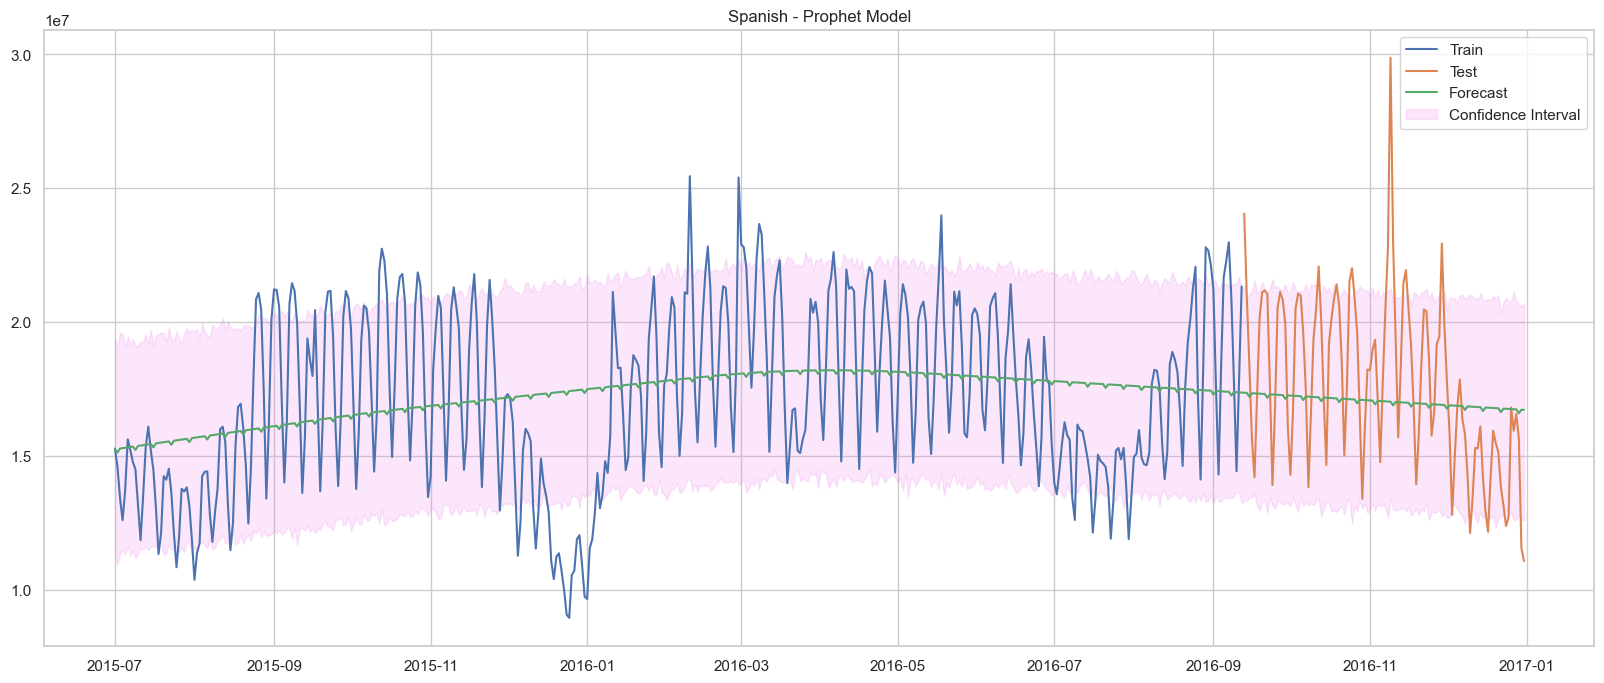

02:28:41 - cmdstanpy - INFO - Chain [1] start processing
02:28:41 - cmdstanpy - INFO - Chain [1] done processing


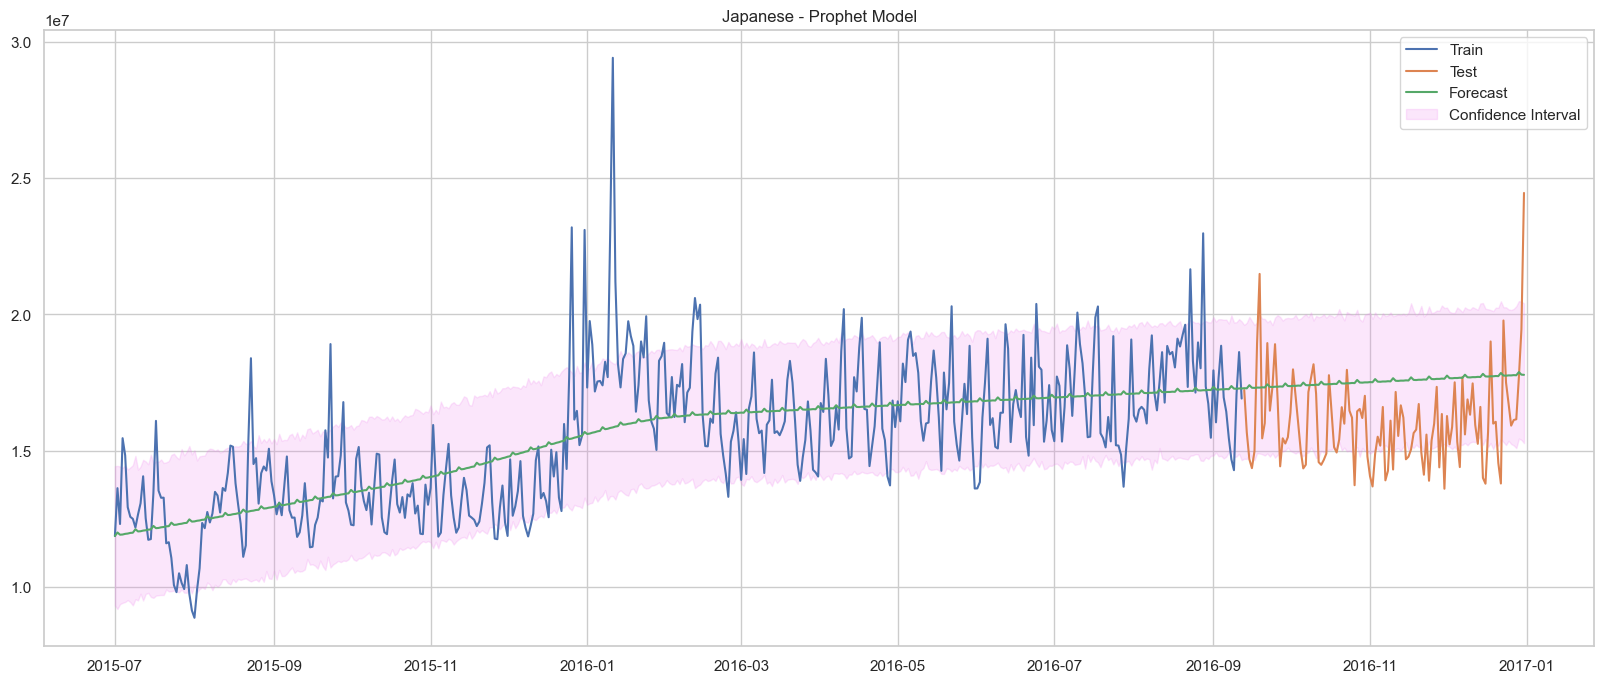

02:28:41 - cmdstanpy - INFO - Chain [1] start processing
02:28:41 - cmdstanpy - INFO - Chain [1] done processing


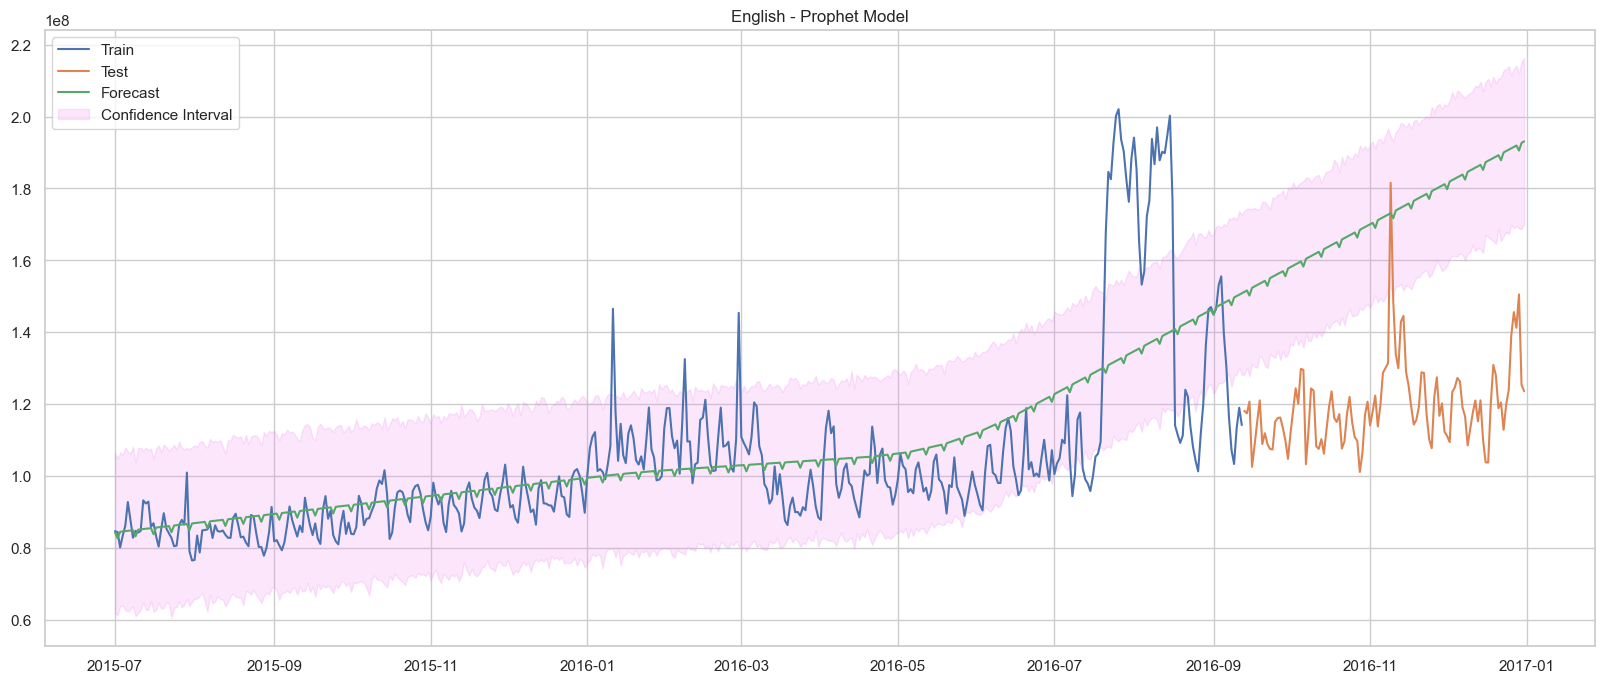

02:28:42 - cmdstanpy - INFO - Chain [1] start processing
02:28:42 - cmdstanpy - INFO - Chain [1] done processing


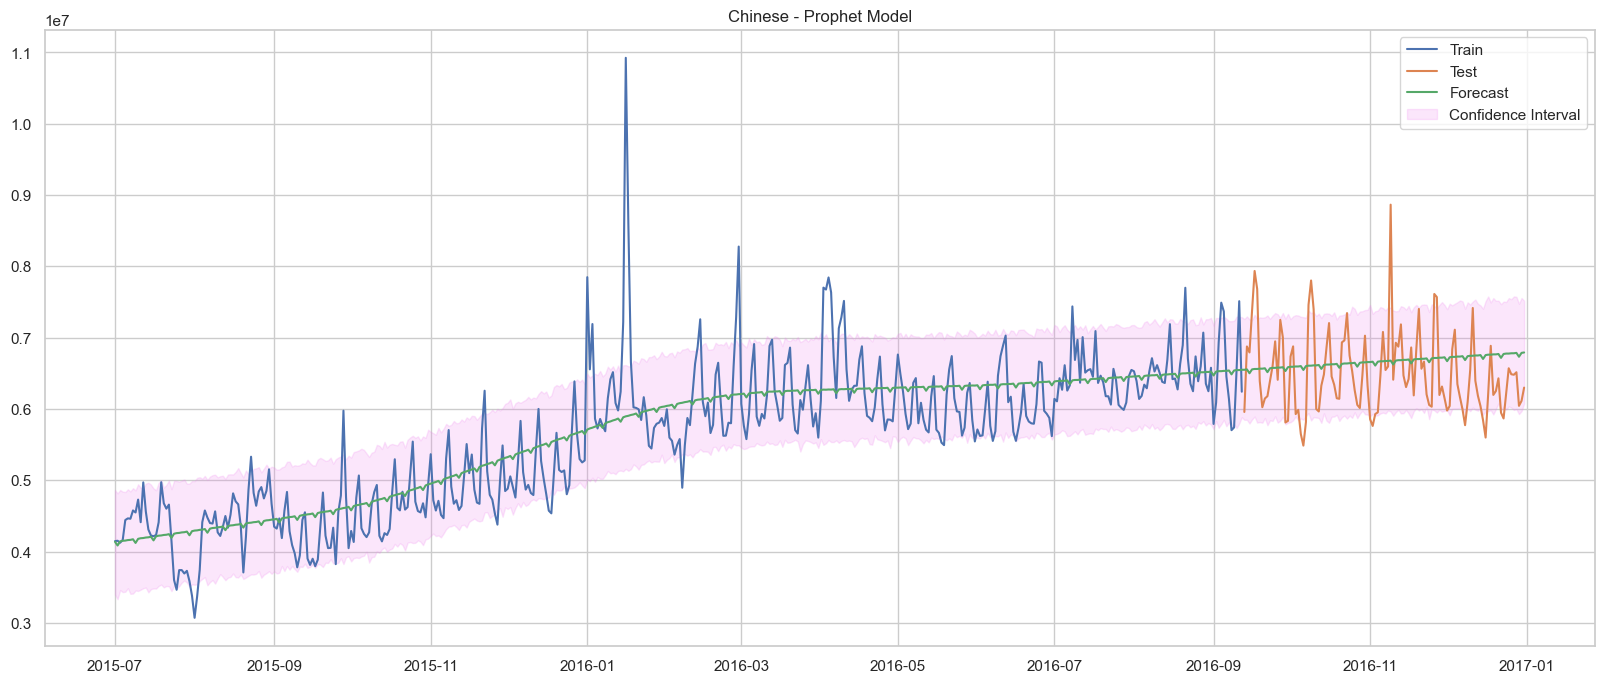

02:28:42 - cmdstanpy - INFO - Chain [1] start processing
02:28:42 - cmdstanpy - INFO - Chain [1] done processing


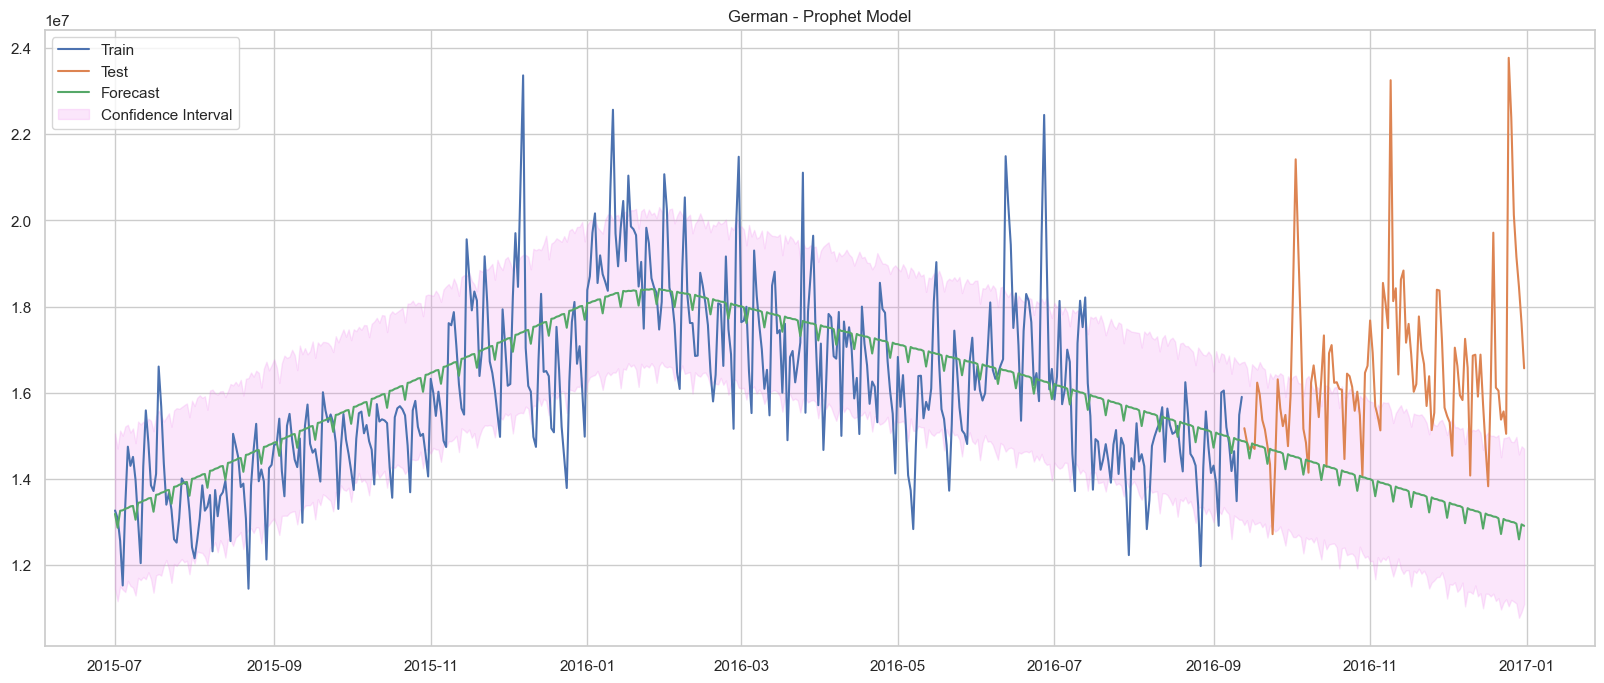

02:28:43 - cmdstanpy - INFO - Chain [1] start processing
02:28:43 - cmdstanpy - INFO - Chain [1] done processing


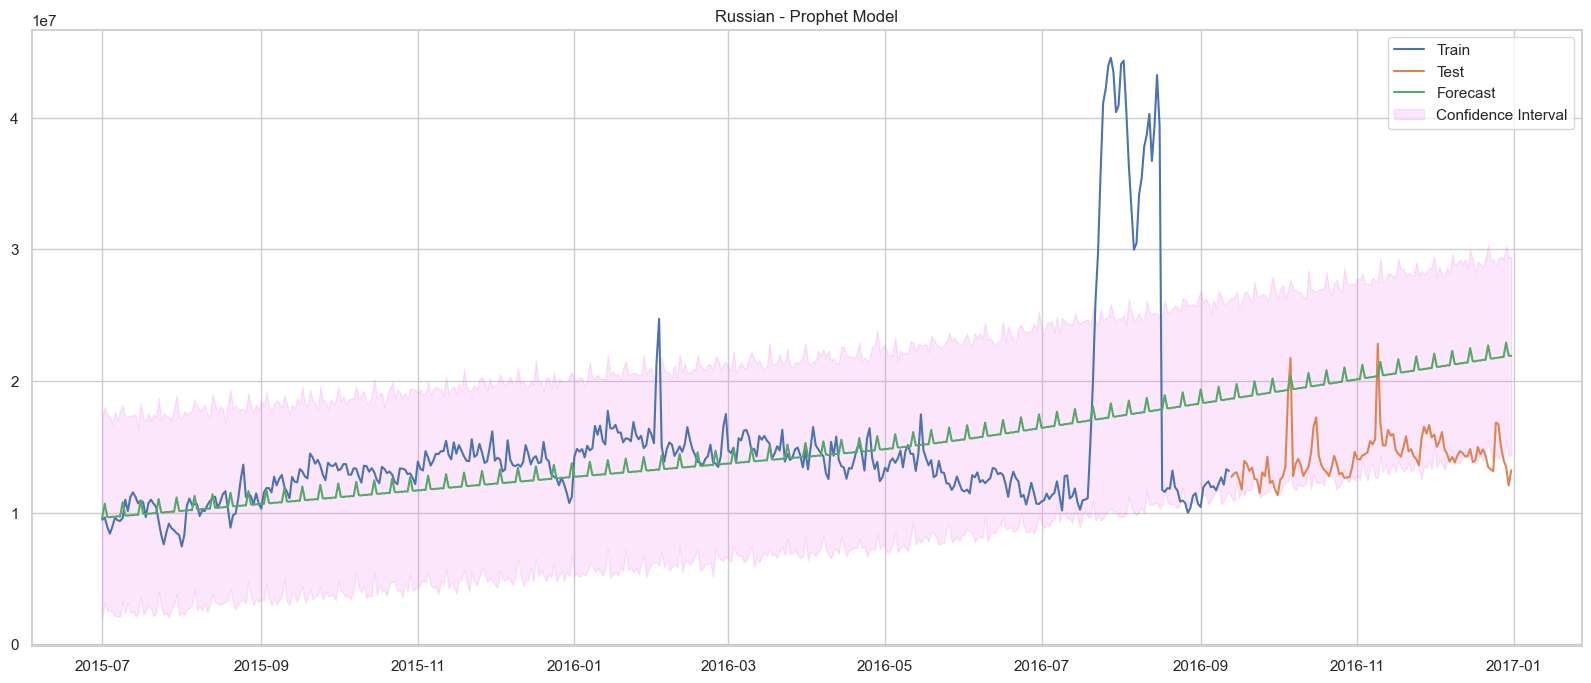

02:28:43 - cmdstanpy - INFO - Chain [1] start processing
02:28:43 - cmdstanpy - INFO - Chain [1] done processing


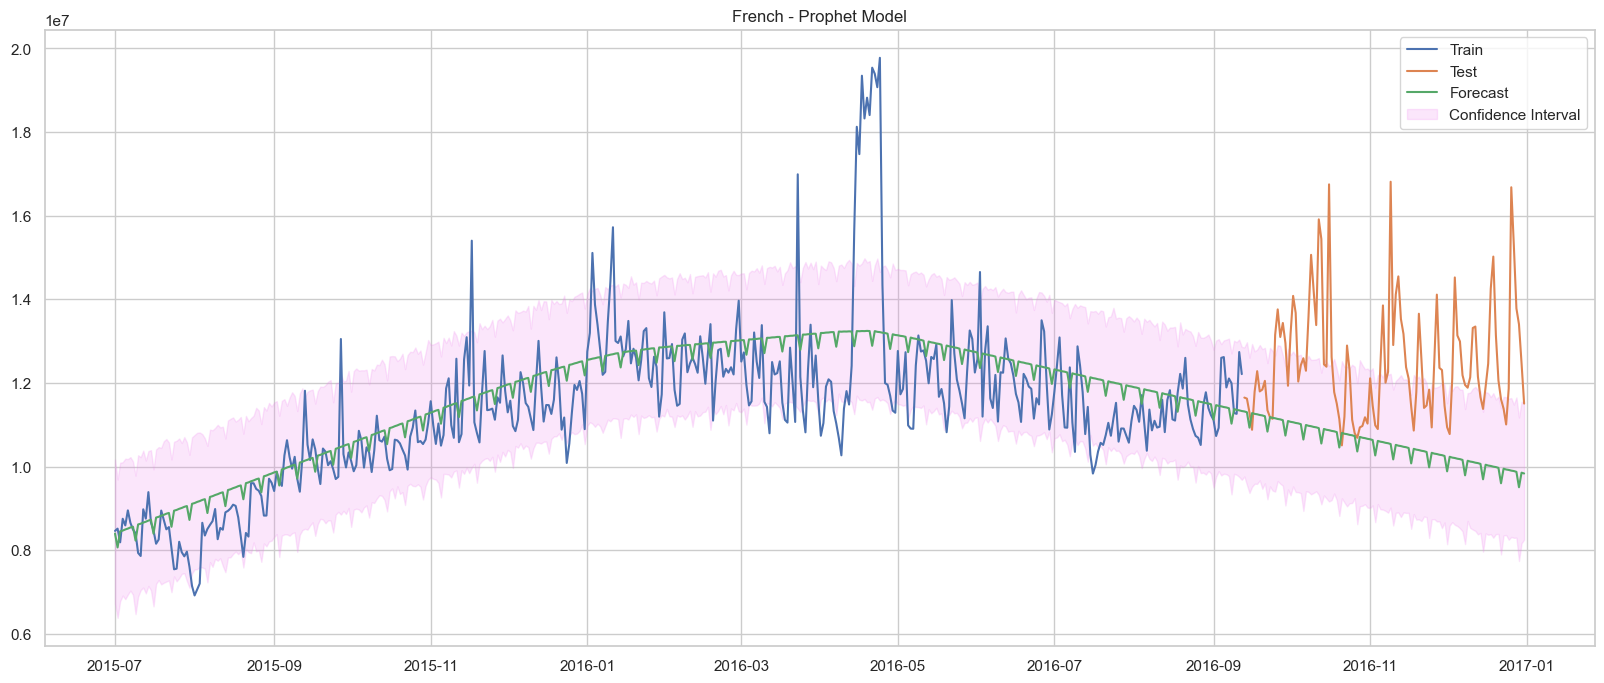

In [17]:
# prophet for all languages
results = []
for column in columns:
    fb_df = pd.DataFrame({
        "ds": df.index,
        "y": df[column],
    }).reset_index(drop=True)

    train = fb_df.iloc[:int(0.8*len(fb_df))]
    test = fb_df.iloc[int(0.8*len(fb_df)):]

    m = Prophet( weekly_seasonality=True )
    m.fit(train)

    future = m.make_future_dataframe(periods=len(test), freq="D")

    forecast = m.predict(future)

    forecast = forecast.set_index("ds")
    train = train.set_index("ds")
    test = test.set_index("ds")

    plt.figure(figsize=(20, 8))
    plt.plot(train["y"], label="Train")
    plt.plot(test["y"], label="Test")
    plt.plot(forecast["yhat"], label="Forecast")
    plt.fill_between(forecast.index, forecast["yhat_lower"], forecast["yhat_upper"], color='violet', alpha=0.2, label="Confidence Interval")
    plt.title(f"{column} - Prophet Model")
    plt.legend()
    plt.show()

    results.append({
        "Language": column,
        'MAPE': performance(test["y"], forecast.loc[test.index, "yhat"]),
    })

In [18]:
pd.DataFrame(results).sort_values("MAPE")

Language      MAPE
3   Chinese  0.079152
1  Japanese  0.123545
0   Spanish  0.147672
6    French  0.149335
4    German  0.154803
5   Russian  0.447796
2   English  0.448351

02:49:37 - cmdstanpy - INFO - Chain [1] start processing
02:49:37 - cmdstanpy - INFO - Chain [1] done processing


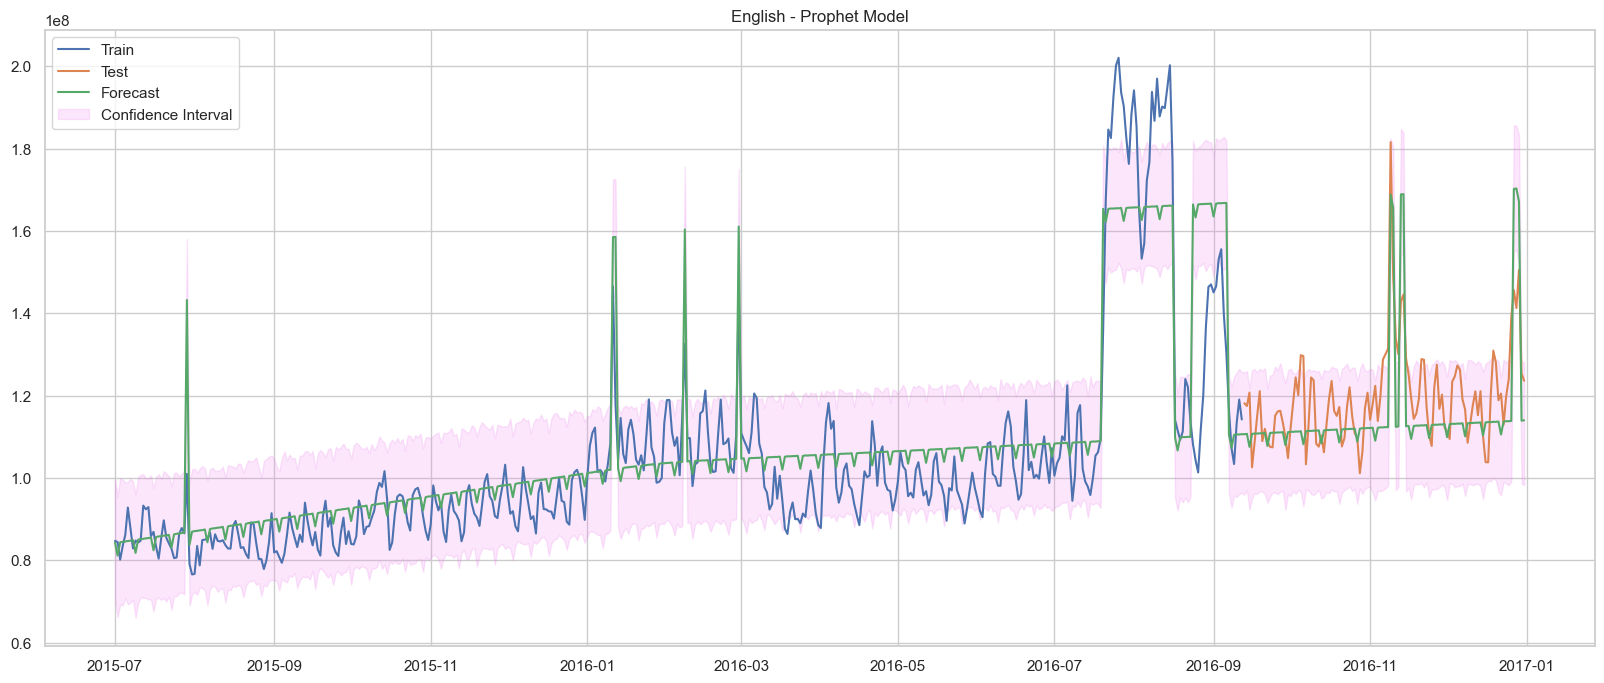

In [19]:
fb_df_english = pd.DataFrame({
    "ds": df.index,
    "y": df["English"],
    "regressor": df["Exog"]
}).reset_index(drop=True)

train = fb_df_english.iloc[:int(0.8*len(fb_df_english))]
test = fb_df_english.iloc[int(0.8*len(fb_df_english)):]
m = Prophet( weekly_seasonality=True)
m.add_regressor('regressor')
m.fit(train)
future = m.make_future_dataframe(periods=len(test))
future["regressor"] = fb_df_english["regressor"]
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper','regressor']].tail()
forecast = forecast.set_index("ds")

train = train.set_index("ds")
test = test.set_index("ds")

plt.figure(figsize=(20, 8))
plt.plot(train["y"], label="Train")
plt.plot(test["y"], label="Test")
plt.plot(forecast["yhat"], label="Forecast")
plt.fill_between(forecast.index, forecast["yhat_lower"], forecast["yhat_upper"], color='violet', alpha=0.2, label="Confidence Interval")
plt.title("English - Prophet Model")
plt.legend()
plt.show()

In [20]:
performance(test["y"], forecast.loc[test.index, "yhat"])

0.06769322066744596